# Description of Experiment


The most recent version of this notebook is at https://github.com/nickjeffrey/cisis23igpl

This jupyter notebook builds on previous works at https://github.com/nickjeffrey/ensemble_learning

This notebook explores the use of Deep Learning classifiers, which are then fed to an Ensemble Learning model to see if the accuracy can be improved.

This notebook used the following hardware / software resources:  Intel Core i7-10710U (6 core, 12 thread), 64GB RAM, 1TB SSD, Windows 11, Sci-kit Learn, Keras.

# Outstanding Tasks
- When creating Deep Learning models with multiple layers, the accuracy values keep getting saved to same variable names, so only the last values are retained for final comparison and graphing.  Consider having unique variable names for each iteration, or even better, put them all into a dictonary that can later be queried to figure out the best model and save the variable names back for later comparison.

# Definitions:

In the context of neural network models, the test loss and test accuracy are performance metrics used to evaluate the model's performance on unseen data, specifically the test set.

Test Loss:

- The test loss measures how well the model is performing on the test set. It represents the average loss (e.g., cross-entropy loss) incurred by the model when making predictions on the test data.
- Lower test loss indicates better performance, as it means that the model's predictions are closer to the actual labels.
However, it's important to consider the scale and nature of the loss function used. For instance, a test loss of 0.1 might be good for one problem but poor for another, depending on the context.


Test Accuracy:

- The test accuracy measures the proportion of correctly classified samples in the test set.
It is calculated by dividing the number of correctly classified samples by the total number of samples in the test set.
- Higher test accuracy indicates better performance, as it means that the model is making more correct predictions.
However, accuracy alone might not provide a complete picture, especially if the classes are imbalanced or if different types of errors have different costs.


In summary, test loss and test accuracy are two important metrics used to assess the performance of a SimpleRNN model on unseen data. Lower test loss and higher test accuracy generally indicate better performance, but it's essential to consider other factors such as the nature of the problem, class imbalance, and potential costs associated with different types of errors.

# Import Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing   import LabelEncoder
from collections import Counter

# Miscellaneous packages
import time                                           #for calculating elapsed time for training tasks
import os                                             #for checking if file exists
import socket                                         #for getting FQDN of local machine
import math                                           #square root function
import sys


# Packages from scikit-learn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV       #for hyperparameter optimization
from sklearn.model_selection import cross_val_score    #for cross fold validation
from sklearn.metrics         import make_scorer        #used by GridSearchCV
from sklearn.metrics         import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.preprocessing   import StandardScaler
from sklearn.linear_model    import LogisticRegression
from sklearn.naive_bayes     import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.svm             import SVC
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.neural_network  import MLPClassifier      #neural network classifier
from sklearn.ensemble        import BaggingClassifier, VotingClassifier, StackingClassifier, AdaBoostClassifier, GradientBoostingClassifier   #Packages for Ensemble Learning

# packages for balancing classes
from imblearn.under_sampling import RandomUnderSampler  #may need to install with: conda install -c conda-forge imbalanced-learn
from imblearn.over_sampling  import SMOTE               #may need to install with: conda install -c conda-forge imbalanced-learn

# Deep Learning classifiers

import tensorflow as tf
from tensorflow.keras.models     import Sequential
from tensorflow.keras.layers     import Dense, Dropout, SimpleRNN, LSTM, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses     import binary_crossentropy
from tensorflow.keras.metrics    import Accuracy


In [2]:
# # KerasClassifier was moved to scikeras in version 2.13.0, so you will need to install the package, but this will break other things!

# import importlib.util

# # Check if scikeras is installed
# if importlib.util.find_spec("scikeras") is None:
#   print("scikeras is not installed, attempting installation now.")
#   !pip install scikeras
# else:
#   print("scikeras is already installed.")


# # after confirming the scikeras package was installed, you can now import KerasClassifier,
# #  which is used for SimpleRNN hyperparameter optimization
# from scikeras.wrappers import KerasClassifier, KerasRegressor

In [3]:
# WARNING: do not use tensorflow.keras.wrappers.scikit_learn
# DEPRECATED. Use [Sci-Keras](https://github.com/adriangb/scikeras) instead.
# See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


# import pkg_resources

# # Get a list of installed packages and their versions
# installed_packages = {package.key: package.version for package in pkg_resources.working_set}

# # Uninstall TensorFlow if installed version is greater than 2.12.0
# if 'tensorflow' in installed_packages and installed_packages['tensorflow'] > '2.12.0':
#   pip.main(['uninstall', '-y', 'tensorflow'])
#   print("TensorFlow uninstalled successfully")
# else:
#   print("Did not find a version of TensorFlow greater than 2.12.0")



# # Check if TensorFlow is installed and its version is greater than 2.12.0
# if 'tensorflow' in installed_packages and installed_packages['tensorflow'] == '2.12.0':
#   print("TensorFlow 2.12.0 is already installed")
# else:
#   print("Installing TensorFlow 2.12.0")
#   pip.main(['install', 'tensorflow==2.12.0'])



# # At this point, tensorflow 2.12.0 is installed, so import the package we want
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# # Print the installed version of KerasClassifier
# #print("Installed version of KerasClassifier:", KerasClassifier.__version__)
# KerasClassifier

# #!pip uninstall -y tensorflow
# #!pip install tensorflow==2.12.0

# Define functions

In [4]:
# function to show missing values in dataset

def get_type_missing(df):
    df_types = pd.DataFrame()
    df_types['data_type'] = df.dtypes
    df_types['missing_values'] = df.isnull().sum()
    return df_types.sort_values(by='missing_values', ascending=False)

In [5]:
# function to create a confusion matrix

def visualize_confusion_matrix(y_test, y_pred):
    #
    ## Calculate accuracy
    #accuracy = accuracy_score(y_test, y_pred)
    #print("Accuracy:", accuracy)
    #
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    #
    # visualize confusion matrix with more detailed labels
    # https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
    #
    group_names = ['True Negative','False Positive','False Negative','True Positive']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize=(3.5, 2.0))  #default figsize is 6.4" wide x 4.8" tall, shrink to 3.5" wide 2.0" tall
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    # use the .ravel function to pull out TN,TP,FN,TP
    # https://analytics4all.org/2020/05/07/python-confusion-matrix/
    TN, FP, FN, TP = cm.ravel()

    # calculate different metrics
    Accuracy = (( TP + TN) / ( TP + TN + FP + FN))
    Sensitivity = TP / (TP + FN)
    Specificity = TN / (TN + FP)
    GeometricMean = math.sqrt(Sensitivity * Specificity)

    # Precision is the ratio of true positive predictions to the total number of positive predictions made by the model
    # average=binary for  binary classification models, average=micro for multiclass classification, average=weighted to match classification_report
    Precision = precision_score(y_test, y_pred, average='weighted')

    # Recall is the ratio of true positive predictions to the total number of actual positive instances in the data.
    # average=binary for  binary classification models, average=micro for multiclass classification, average=weighted to match classification_report
    Recall = recall_score(y_test, y_pred, average='weighted')

    # F1-score is a metric that considers both precision and recall, providing a balance between the two.
    # average=binary for  binary classification models, average=micro for multiclass classification, average=weighted to match classification_report
    F1 = f1_score(y_test, y_pred, average='weighted')

    # add details below graph to help interpret results
    print('\n\n')
    print('Confusion matrix\n\n', cm)
    print('\nTrue Negatives  (TN) = ', TN)
    print('False Positives (FP) = ', FP)
    print('False Negatives (FN) = ', FN)
    print('True Positives  (TP) = ', TP)
    print ('\n')
    print ("Accuracy:       ", Accuracy)
    print ("Sensitivity:    ", Sensitivity)
    print ("Specificity:    ", Specificity)
    print ("Geometric Mean: ", GeometricMean)
    print ('\n')
    print ("Precision:       ", Precision)
    print ("Recall:          ", Recall)
    print ("f1-score:        ", F1)

    print('\n------------------------------------------------\n')
    # We want TN and TP to be approximately equal, because this indicates the dataset is well balanced.
    # If TN and TP are very different, it indicates imbalanced data, which can lead to low accuracy due to overfitting
    #if (TN/TP*100 < 40 or TN/TP*100 > 60):   #we want TN and TP to be approximately 50%, if the values are below 40% or over 60%, generate a warning
    #    print("WARNING: the confusion matrix shows that TN and TP are very imbalanced, may lead to low accuracy!")
    #
    return cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1





In [6]:
# function to report on model accuracy (TP, FP, FN, FP), precision, recall, f1-score
# this function does not provide anything additional to the results from the previous function

def model_classification_report(cm, y_test, y_pred):
    report = classification_report(y_test, y_pred, digits=4)
    print('\n')
    print("Classification Report: \n", report)
    print('\n\n\n')



In [7]:
# function to show elapsed time for running notebook

# start a timer so we can calculate the total runtime of this notebook
notebook_start_time = time.time()  #seconds since epoch

def show_elapsed_time():
    #
    # Get the current time as a struct_time object
    current_time_struct = time.localtime()

    # Format the struct_time as a string (yyyy-mm-dd HH:MM:SS format)
    current_time_str = time.strftime("%Y-%m-%d %H:%M:%S", current_time_struct)

    # Display the current time in HH:MM:SS format
    print("Current Time:", current_time_str)

    # show a running total of elapsed time for the entire notebook
    notebook_end_time = time.time()  #seconds since epoch
    print(f"The entire notebook runtime so far is {(notebook_end_time-notebook_start_time)/60:.0f} minutes")

show_elapsed_time()

Current Time: 2024-05-15 20:19:27
The entire notebook runtime so far is 0 minutes


In [8]:
# create a function to plot Training Loss and Validation Loss for Neural Network classifiers

def plot_loss_history(train_loss_history_unoptimized, train_loss_history_optimized, val_loss_history_unoptimized, val_loss_history_optimized, epoch_count):
    if len(train_loss_history_unoptimized) == 0 or len(train_loss_history_optimized) == 0 or len(val_loss_history_unoptimized) == 0 or len(val_loss_history_optimized) == 0:
        print("ERROR: cannot find loss history, using all zeros")
        raise ValueError ("ERROR: Cannot find loss history, please investigate!")
    #
    # sanity check to confirm the same number of epochs were used before and after hyperparameter optimization
    if len(train_loss_history_unoptimized) != len(train_loss_history_optimized) or len(val_loss_history_unoptimized) != len(val_loss_history_optimized):
        raise ValueError ("ERROR: different number of epochs used before and after hyperparameter optimziation")

    # Create two subplots side by side
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))  # Create two subplots side by side

    # Plot for loss before optimization
    axs[0].plot(train_loss_history_unoptimized, label='Train Loss before optimizing', color='blue', linestyle='--')
    axs[0].plot(val_loss_history_unoptimized, label='Validation Loss before optimizing', color='red', linestyle='--')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Train / Val Loss before optimization')
    axs[0].legend()
    axs[0].grid(True)

    # Plot for loss after optimization
    axs[1].plot(train_loss_history_optimized, label='Train Loss after optimizing', color='blue', linestyle='-')
    axs[1].plot(val_loss_history_optimized, label='Validation Loss after optimizing', color='red', linestyle='-')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].set_title('Train / Val Loss after optimization')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

    # the lines should be very close to converging by the final epoch
    # since list indexes start at 0 instead of 1, use epoch_count-1 as the index for the last value
    # maximum acceptable divergence
    divergence_threshold = 0.01
    divergence_unoptimized = abs(train_loss_history_unoptimized[epoch_count-1] - val_loss_history_unoptimized[epoch_count-1])
    divergence_optimized   = abs(train_loss_history_optimized[epoch_count-1]   - val_loss_history_optimized[epoch_count-1])
    if divergence_optimized > divergence_threshold:
        print(f"WARNING, after optimization, loss divergence is {divergence_optimized}, which greater than threshold of {divergence_threshold}, please continue tuning this model.")
    else:
        print(f"After optimization, loss divergence is {divergence_optimized:.3f}, which is <= threshold of {divergence_threshold}, this model has acceptable loss.")

# Example usage:
#epoch_count = 5
#train_loss_history_unoptimized = [1, 2, 3, 4, 5]
#train_loss_history_optimized = [1, 2, 3, 4, 5]
#val_loss_history_unoptimized = [1, 2, 3, 4, 5]
#val_loss_history_optimized = [1, 2, 3, 4, 5]
#plot_loss_history(train_loss_history_unoptimized, train_loss_history_optimized, val_loss_history_unoptimized, val_loss_history_optimized, epoch_count)



In [9]:
# create a function to plot Training Accuracy and Validation Accuracy for Neural Network classifiers

def plot_accuracy_history(train_accuracy_history_unoptimized, train_accuracy_history_optimized, val_accuracy_history_unoptimized, val_accuracy_history_optimized, epoch_count):
    # sanity check to confirm the required values have already been collected
    if len(train_accuracy_history_unoptimized) == 0 or len(train_accuracy_history_optimized) == 0 or len(val_accuracy_history_unoptimized) == 0 or len(val_accuracy_history_optimized) == 0:
        print("ERROR: cannot find accuracy history")
        raise ValueError ("ERROR: Cannot find accuracy history, please investigate!")
    # sanity check to confirm the same number of epochs were used before and after hyperparameter optimization
    if len(train_accuracy_history_unoptimized) != len(train_accuracy_history_optimized) or len(val_accuracy_history_unoptimized) != len(val_accuracy_history_optimized):
        raise ValueError ("ERROR: different number of epochs used before and after hyperparameter optimziation")


    # Create two subplots side by side
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))  # Create two subplots side by side

    # Plot for accuracy before optimization
    axs[0].plot(train_accuracy_history_unoptimized, label='Train Accuracy before optimizing',      color='blue', linestyle='--')
    axs[0].plot(val_accuracy_history_unoptimized,   label='Validation Accuracy before optimizing', color='red',  linestyle='--')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_title('Train / Val Accuracy before optimization')
    axs[0].legend()
    axs[0].grid(True)

    # Plot for accuracy after optimization
    axs[1].plot(train_accuracy_history_optimized, label='Train Accuracy after optimizing',      color='blue', linestyle='-')
    axs[1].plot(val_accuracy_history_optimized,   label='Validation Accuracy after optimizing', color='red',  linestyle='-')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Train / Val Accuracy after optimization')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

    # the lines should be very close to converging by the final epoch
    # since list indexes start at 0 instead of 1, use epoch_count-1 as the index for the last value
    # maximum acceptable divergence
    divergence_threshold = 0.01
    divergence_unoptimized = abs(train_accuracy_history_unoptimized[epoch_count-1] - val_accuracy_history_unoptimized[epoch_count-1])
    divergence_optimized   = abs(train_accuracy_history_optimized[epoch_count-1]   - val_accuracy_history_optimized[epoch_count-1])
    if divergence_optimized > divergence_threshold:
        print(f"WARNING, after optimization, accuracy divergence is {divergence_optimized}, which greater than threshold of {divergence_threshold}, please continue tuning this model.")
    else:
        print(f"After optimization, accuracy divergence is {divergence_optimized:.3f}, which is <= threshold of {divergence_threshold}, this model has acceptable accuracy.")

# Example usage:
#epoch_count = 10
#train_accuracy_history_unoptimized = [1, 2, 3, 4, 5, 6, 7, 8, 9, 0.5]
#train_accuracy_history_optimized = [1, 2, 3, 4, 5, 6, 7, 8, 9, 0.4]
#val_accuracy_history_unoptimized = [1, 2, 3, 4, 5, 6, 7, 8, 9, 0.5]
#val_accuracy_history_optimized = [1, 2, 3, 4, 5, 6, 7, 8, 9, 0.4]
#plot_accuracy_history(train_accuracy_history_unoptimized, train_accuracy_history_optimized, val_accuracy_history_unoptimized, val_accuracy_history_optimized, epoch_count)



# Initialize variables


In [10]:
# initialize variables to avoid undef errors

accuracy_lr_unoptimized               = 0
accuracy_lr_optimized                 = 0
accuracy_nb_unoptimized               = 0
accuracy_nb_optimized                 = 0
accuracy_knn_unoptimized              = 0
accuracy_knn_optimized                = 0
accuracy_svm_unoptimized              = 0
accuracy_svm_optimized                = 0
accuracy_dt_unoptimized               = 0
accuracy_dt_optimized                 = 0
accuracy_rf_unoptimized               = 0
accuracy_rf_optimized                 = 0
accuracy_gb_unoptimized               = 0
accuracy_gb_optimized                 = 0
accuracy_mlp_unoptimized              = 0
accuracy_mlp_optimized                = 0
accuracy_fnn_unoptimized              = 0
accuracy_fnn_optimized                = 0
accuracy_sequential_unoptimized       = 0
accuracy_sequential_optimized         = 0
accuracy_cnn_unoptimized              = 0
accuracy_cnn_optimized                = 0
accuracy_rnn_unoptimized              = 0
accuracy_rnn_optimized                = 0
accuracy_lstm_unoptimized             = 0
accuracy_lstm_optimized               = 0
accuracy_gru_unoptimized              = 0
accuracy_gru_optimized                = 0



test_accuracy_sequential_unoptimized       = 0
test_loss_sequential_unoptimized           = 0
train_accuracy_sequential_unoptimized      = 0
train_loss_sequential_unoptimized          = 0
test_accuracy_sequential_optimized         = 0
test_loss_sequential_optimized             = 0
train_accuracy_sequential_optimized        = 0
train_loss_sequential_optimized            = 0
val_accuracy_sequential_unoptimized        = 0
val_loss_sequential_unoptimized            = 0
val_accuracy_sequential_optimized          = 0
val_loss_sequential_optimized              = 0

test_accuracy_lstm_unoptimized             = 0
test_loss_lstm_unoptimized                 = 0
train_accuracy_lstm_unoptimized            = 0
train_loss_lstm_unoptimized                = 0
test_accuracy_lstm_optimized               = 0
test_loss_lstm_optimized                   = 0
train_accuracy_lstm_optimized              = 0
train_loss_lstm_optimized                  = 0
val_accuracy_lstm_unoptimized              = 0
val_loss_lstm_unoptimized                  = 0
val_accuracy_lstm_optimized                = 0
val_loss_lstm_optimized                    = 0

test_accuracy_simplernn_unoptimized        = 0
test_loss_simplernn_unoptimized            = 0
train_accuracy_simplernn_unoptimized       = 0
train_loss_simplernn_unoptimized           = 0
test_accuracy_simplernn_optimized          = 0
test_loss_simplernn_optimized              = 0
train_accuracy_simplernn_optimized         = 0
train_loss_simplernn_optimized             = 0
val_accuracy_simplernn_unoptimized         = 0
val_loss_simplernn_unoptimized             = 0
val_accuracy_simplernn_optimized           = 0
val_loss_simplernn_optimized               = 0

test_accuracy_simplernn_lstm_unoptimized   = 0
test_loss_simplernn_lstm_unoptimized       = 0
train_accuracy_simplernn_lstm_unoptimized  = 0
train_loss_simplernn_lstm_unoptimized      = 0
test_accuracy_simplernn_lstm_optimized     = 0
test_loss_simplernn_lstm_optimized         = 0
train_accuracy_simplernn_lstm_optimized    = 0
train_loss_simplernn_lstm_optimized        = 0
val_accuracy_simplernn_lstm_unoptimized    = 0
val_loss_simplernn_lstm_unoptimized        = 0
val_accuracy_simplernn_lstm_optimized      = 0
val_loss_simplernn_lstm_optimized          = 0


test_accuracy_gru_unoptimized              = 0
test_loss_gru_unoptimized                  = 0
train_accuracy_gru_unoptimized             = 0
train_loss_gru_unoptimized                 = 0
test_accuracy_gru_optimized                = 0
test_loss_gru_optimized                    = 0
train_accuracy_gru_optimized               = 0
train_loss_gru_optimized                   = 0
val_accuracy_gru_unoptimized               = 0
val_loss_gru_unoptimized                   = 0
val_accuracy_gru_optimized                 = 0
val_loss_gru_optimized                     = 0

best_params_mlp                       = ""
best_params_sequential                = ""
best_params_lstm                      = ""
best_params_simplernn                 = ""
best_params_simplernn_lstm            = ""
best_params_gru                       = ""


accuracy_ensemble_voting              = 0
accuracy_ensemble_stacking            = 0
accuracy_ensemble_boosting            = 0
accuracy_ensemble_bagging             = 0


cv_count                              = 10  #number of cross-validation folds
epoch_count                           = 25  #number of epochs for neural network classifiers
epoch_verbosity                       = 2   #For NN classifiers with epochs. 0=silent training, 1 will show progress bars, 2 will provide a concise summary per epoch.
verbosity                             = 2   # for MLP, LR, DT classifiers.

train_loss_history_unoptimized     = [0] * epoch_count
train_loss_history_optimized       = [0] * epoch_count
val_loss_history_unoptimized       = [0] * epoch_count
val_loss_history_optimized         = [0] * epoch_count

train_accuracy_history_unoptimized = [0] * epoch_count
train_accuracy_history_optimized   = [0] * epoch_count
val_accuracy_history_unoptimized   = [0] * epoch_count
val_accuracy_history_optimized     = [0] * epoch_count

In [11]:
# # Load pickled datasets

# # Determine the best location to obtain the source *.pkl file

# # define *.pkl source file
# filename = 'Edge-IIoTset2023_scaled_data_tuple.pkl'
# LAN_location = 'http://datasets.nyx.local:80/datasets/Edge-IIoTset2023/Selected_dataset_for_ML_and_DL'  #high speed local copy on LAN
# WAN_location = 'http://datasets.nyx.ca:8081/datasets/Edge-IIoTset2023/Selected_dataset_for_ML_and_DL'   #accessible to entire internet

# #filename = 'CIC_IOT_Dataset2023_scaled_data_tuple.pkl'
# #LAN_location = 'http://datasets.nyx.local:80/datasets/CIC_IOT_Dataset2023/csv'  #high speed local copy on LAN
# #WAN_location = 'http://datasets.nyx.ca:8081/datasets/CIC_IOT_Dataset2023/csv'   #accessible to entire internet

# # Get the FQDN of the local machine
# fqdn = socket.getfqdn()
# ipv4_address = socket.gethostbyname(socket.gethostname())
# print(f"Fully Qualified Domain Name (FQDN):{fqdn}, IPv4 address:{ipv4_address}")
# if ( "nyx.local" in fqdn ):
#     # If inside the LAN, grab the local copy of the dataset
#     print(f"Detected Fully Qualified Domain Name of {fqdn}, dataset source is:\n{LAN_location}/{filename}")
#     dataset = f"{LAN_location}/{filename}"
# else:
#     # If not inside the LAN, grab the dataset from an internet-accessible URL
#     print(f"Detected Fully Qualified Domain Name of {fqdn}, dataset source is:\n{WAN_location}/{filename}")
#     dataset = f"{WAN_location}/{filename}"




# # Load pickle file from dataset that has already been labeled, scaled, randomly undersampled, and split into train/test/val

# if not os.path.exists(filename):
#   print(f"Retrieving pickle file", dataset)
#   #!wget {dataset}          #wget typically exists on Linux but not Windows
#   !curl -O {dataset}        #curl typically exists on both Linux and Windows
# else:
#   print(f"Pickle file {filename} already exists")




# # Open the pickle file

# # uncomment the filename you want to load
# pickle_file = "Edge-IIoTset2023_scaled_data_tuple.pkl"
# #pickle_file = "CIC_IOT_Dataset2023_scaled_data_tuple.pkl"

# # Load the tuple using pickle
# with open(pickle_file, 'rb') as f:
#     #data_tuple = pickle.load(f)               #syntax for pandas <  version 2.0
#     data_tuple = pd.read_pickle(pickle_file)   #syntax for pandas >= version 2.0

# # split the pickle file into the lists from the source dataset
# X_train, X_test, X_val, y_train, y_test, y_val = data_tuple



# Load raw dataset

In [12]:
# ask user which dataset they want to work with

# Ask for user input
print(f"There are two available datasets to work with:")
print(f"1. Edge-IIoTset2023")
print(f"2. CIC_IOT_Dataset2023")
get_user_input = input("Please enter 1 or 2 to select the dataset you wish to work with: ")

# Check for user respond
if get_user_input == "1":
    dataset_name = "Edge-IIoTset2023"
elif get_user_input == "2":
    dataset_name = "CIC_IOT_Dataset2023"
else:
    raise ValueError ("Please select 1 or 2 for the appropriate dataset")

    
print(f"You selected dataset name {dataset_name}")

There are two available datasets to work with:
1. Edge-IIoTset2023
2. CIC_IOT_Dataset2023


Please enter 1 or 2 to select the dataset you wish to work with:  2


You selected dataset name CIC_IOT_Dataset2023


In [13]:
# define CSV source file
print(f"Working with dataset {dataset_name}")
if dataset_name == "Edge-IIoTset2023":
    filename     = 'DNN-EdgeIIoT-dataset.csv'
    LAN_location = 'http://datasets.nyx.local:80/datasets/Edge-IIoTset2023/Selected_dataset_for_ML_and_DL'  #high speed local copy on LAN
    WAN_location = 'http://datasets.nyx.ca:8081/datasets/Edge-IIoTset2023/Selected_dataset_for_ML_and_DL'   #accessible to entire internet
elif dataset_name == "CIC_IOT_Dataset2023":
    filename     = 'merged_filtered.csv'
    LAN_location = 'http://datasets.nyx.local:80/datasets/CIC_IOT_Dataset2023/csv'  #high speed local copy on LAN
    WAN_location = 'http://datasets.nyx.ca:8081/datasets/CIC_IOT_Dataset2023/csv'   #accessible to entire internet
else:
    raise FileNotFoundError(f"Could not determine dataset name, please set appropriate variable.")
    

# Get the FQDN of the local machine
fqdn = socket.getfqdn()
ipv4_address = socket.gethostbyname(socket.gethostname())
print(f"Fully Qualified Domain Name (FQDN):{fqdn}, IPv4 address:{ipv4_address}")
if ( "nyx.local" in fqdn ):
    # If inside the LAN, grab the local copy of the dataset
    print(f"Detected Fully Qualified Domain Name of {fqdn}, dataset source is:\n{LAN_location}/{filename}")
    dataset = f"{LAN_location}/{filename}"
else:
    # If not inside the LAN, grab the dataset from an internet-accessible URL
    print(f"Detected Fully Qualified Domain Name of {fqdn}, dataset source is:\n{WAN_location}/{filename}")
    dataset = f"{WAN_location}/{filename}"




Working with dataset CIC_IOT_Dataset2023
Fully Qualified Domain Name (FQDN):DESKTOP-SNBGTFL.nyx.local, IPv4 address:192.168.14.136
Detected Fully Qualified Domain Name of DESKTOP-SNBGTFL.nyx.local, dataset source is:
http://datasets.nyx.local:80/datasets/CIC_IOT_Dataset2023/csv/merged_filtered.csv


In [14]:
# check to see if the dataset has already been retrieved from the remote web server

if not os.path.exists(filename):
  print(f"Retrieving dataset", dataset)
  #!wget {dataset}          #wget typically exists on Linux but not Windows
  !curl -O {dataset}        #curl typically exists on both Linux and Windows
else:
  print(f"File {filename} already exists")


File merged_filtered.csv already exists


In [15]:
# Confirm the source datafile exists locally, just in case the previous cell failed to load the CSV file
if not os.path.exists(filename):
    raise FileNotFoundError(f"The file '{file_path}' does not exist.")
else:
    print(f"Confirmed existence of filename {filename}")

Confirmed existence of filename merged_filtered.csv


In [16]:
# Load the CSV file
print(f"Loading dataset from {filename}")
df = pd.read_csv(filename)

Loading dataset from merged_filtered.csv


In [17]:
#view dimensions of dataset (rows and columns)
print ("Rows,columns in dataset:", df.shape)

Rows,columns in dataset: (2867733, 47)


In [18]:
print(f"Dropping rows from the dataset during debugging to speed up this notebook - turn this off when finished debugging!")

# cut dataset in half if > 2 million rows
if ( len(df) > 2000000):
    print(f"Original size of dataset is", len(df), " rows")
    df.drop(df.index[::2], inplace=True)
    print(f"Dataset size after dropping all the even-numbered rows is", len(df), " rows")

# cut dataset in half if > 1 million rows
if ( len(df) > 1000000):
    print(f"Original size of dataset is", len(df), " rows")
    df.drop(df.index[::2], inplace=True)
    print(f"Dataset size after dropping all the even-numbered rows is", len(df), " rows")

# # cut dataset in half if > 0.5 million rows
# if ( len(df) > 500000):
#     print(f"Original size of dataset is", len(df), " rows")
#     df.drop(df.index[::2], inplace=True)
#     print(f"Dataset size after dropping all the even-numbered rows is", len(df), " rows")

# # cut dataset in half if > 0.5 million rows
# if ( len(df) > 500000):
#     print(f"Original size of dataset is", len(df), " rows")
#     df.drop(df.index[::2], inplace=True)
#     print(f"Dataset size after dropping all the even-numbered rows is", len(df), " rows")

# # cut dataset in half if > 250,000 rows
# if ( len(df) > 250000):
#     print(f"Original size of dataset is", len(df), " rows")
#     df.drop(df.index[::2], inplace=True)
#     print(f"Dataset size after dropping all the even-numbered rows is", len(df), " rows")


# # cut dataset in half if > 100,000 rows
# if ( len(df) > 100000):
#     print(f"Original size of dataset is", len(df), " rows")
#     df.drop(df.index[::2], inplace=True)
#     print(f"Dataset size after dropping all the even-numbered rows is", len(df), " rows")


#  # cut dataset in half if > 50,000 rows
# if ( len(df) > 50000):
#     print(f"Original size of dataset is", len(df), " rows")
#     df.drop(df.index[::2], inplace=True)
#     print(f"Dataset size after dropping all the even-numbered rows is", len(df), " rows")


# # cut dataset in half if > 25,000 rows
# if ( len(df) > 25000):
#     print(f"Original size of dataset is", len(df), " rows")
#     df.drop(df.index[::2], inplace=True)
#     print(f"Dataset size after dropping all the even-numbered rows is", len(df), " rows")


Dropping rows from the dataset during debugging to speed up this notebook - turn this off when finished debugging!
Original size of dataset is 2867733  rows
Dataset size after dropping all the even-numbered rows is 1433866  rows
Original size of dataset is 1433866  rows
Dataset size after dropping all the even-numbered rows is 716933  rows
Original size of dataset is 716933  rows
Dataset size after dropping all the even-numbered rows is 358466  rows
Original size of dataset is 358466  rows
Dataset size after dropping all the even-numbered rows is 179233  rows
Original size of dataset is 179233  rows
Dataset size after dropping all the even-numbered rows is 89616  rows
Original size of dataset is 89616  rows
Dataset size after dropping all the even-numbered rows is 44808  rows
Original size of dataset is 44808  rows
Dataset size after dropping all the even-numbered rows is 22404  rows


In [19]:
#view dimensions of dataset (rows and columns)
print ("Rows,columns in dataset:", df.shape)

Rows,columns in dataset: (22404, 47)


In [20]:
# show a running total of elapsed time for the entire notebook
show_elapsed_time()

Current Time: 2024-05-15 20:19:44
The entire notebook runtime so far is 0 minutes


# Exploratory Data Analysis (EDA)

In [21]:
# take a quick look at the data
df.head()

flow_duration  Header_Length  Protocol Type  Duration        Rate  \
127       0.000000           58.0            6.0      48.7    0.133304   
255       5.593900      5411305.3            6.0      60.1  664.243267   
383      35.645644        18828.9           11.5      69.1    1.658343   
511      11.567025       660581.8            6.0     114.1  139.341360   
639       0.763520          462.3            5.3      44.8    6.108789   

          Srate  Drate  fin_flag_number  syn_flag_number  rst_flag_number  \
127    0.133304    0.0              0.0              1.0              0.0   
255  664.243267    0.0              0.0              0.0              0.0   
383    1.658343    0.0              0.0              0.0              0.0   
511  139.341360    0.0              0.0              0.0              0.0   
639    6.108789    0.0              0.0              0.0              0.0   

     ...          Std  Tot size           IAT  Number   Magnitue       Radius  \
127  ...    36.280658      58.0  1.664290e+08    13.5  11.643890    51.419103   
255  ...   399.101608    1085.6  6.970882e-04     5.5  24.248639   564.414907   
383  ...     9.909081      71.2  1.808000e-02     5.5  11.558680    14.013556   
511  ...  1168.350480    1426.7  1.665203e+08    13.5  47.582073  1653.261146   
639  ...     9.848105      78.8  1.668999e-02     5.5  11.667452    13.927324   

       Covariance  Variance  Weight             label  
127  1.331690e+03       1.0   244.6    Recon-PortScan  
255  3.430353e+05       0.5    38.5  MITM-ArpSpoofing  
383  1.669243e+02       0.8    38.5     BenignTraffic  
511  1.368075e+06       1.0   244.6     BenignTraffic  
639  3.491656e+02       0.7    38.5     BenignTraffic  

[5 rows x 47 columns]

In [22]:
# Display all the data rather than just a portion
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [23]:
# check for any missing values in dataset
df.isna().sum()

flow_duration      0
Header_Length      0
Protocol Type      0
Duration           0
Rate               0
Srate              0
Drate              0
fin_flag_number    0
syn_flag_number    0
rst_flag_number    0
psh_flag_number    0
ack_flag_number    0
ece_flag_number    0
cwr_flag_number    0
ack_count          0
syn_count          0
fin_count          0
urg_count          0
rst_count          0
HTTP               0
HTTPS              0
DNS                0
Telnet             0
SMTP               0
SSH                0
IRC                0
TCP                0
UDP                0
DHCP               0
ARP                0
ICMP               0
IPv                0
LLC                0
Tot sum            0
Min                0
Max                0
AVG                0
Std                0
Tot size           0
IAT                0
Number             0
Magnitue           0
Radius             0
Covariance         0
Variance           0
Weight             0
label              0
dtype: int64

In [24]:
# check for any missing datatypes
get_type_missing(df)

data_type  missing_values
flow_duration     float64               0
Max               float64               0
TCP               float64               0
UDP               float64               0
DHCP              float64               0
ARP               float64               0
ICMP              float64               0
IPv               float64               0
LLC               float64               0
Tot sum           float64               0
Min               float64               0
AVG               float64               0
SSH               float64               0
Std               float64               0
Tot size          float64               0
IAT               float64               0
Number            float64               0
Magnitue          float64               0
Radius            float64               0
Covariance        float64               0
Variance          float64               0
Weight            float64               0
IRC               float64               0
SMTP              float64               0
Header_Length     float64               0
ack_flag_number   float64               0
Protocol Type     float64               0
Duration          float64               0
Rate              float64               0
Srate             float64               0
Drate             float64               0
fin_flag_number   float64               0
syn_flag_number   float64               0
rst_flag_number   float64               0
psh_flag_number   float64               0
ece_flag_number   float64               0
Telnet            float64               0
cwr_flag_number   float64               0
ack_count         float64               0
syn_count         float64               0
fin_count         float64               0
urg_count         float64               0
rst_count         float64               0
HTTP              float64               0
HTTPS             float64               0
DNS               float64               0
label              object               0

In [25]:
df.describe()

flow_duration  Header_Length  Protocol Type      Duration  \
count   22404.000000   2.240400e+04   22404.000000  22404.000000   
mean       77.659999   1.141013e+06      10.742757     93.729650   
std       857.470456   1.495270e+06       4.813685     45.812264   
min         0.000000   0.000000e+00       0.000000      0.000000   
25%         1.633845   6.509265e+04       6.000000     64.000000   
50%         6.231715   5.928908e+05       8.300000     69.400000   
75%        37.302472   1.618047e+06      16.830000    110.700000   
max     47526.775773   9.788621e+06      17.000000    255.000000   

               Rate         Srate    Drate  fin_flag_number  syn_flag_number  \
count  2.240400e+04  2.240400e+04  22404.0     22404.000000     22404.000000   
mean   2.202559e+03  2.202559e+03      0.0         0.000134         0.018434   
std    1.878298e+04  1.878298e+04      0.0         0.011571         0.134518   
min    0.000000e+00  0.000000e+00      0.0         0.000000         0.000000   
25%    3.225728e+01  3.225728e+01      0.0         0.000000         0.000000   
50%    8.856275e+01  8.856275e+01      0.0         0.000000         0.000000   
75%    1.093230e+03  1.093230e+03      0.0         0.000000         0.000000   
max    1.048612e+06  1.048612e+06      0.0         1.000000         1.000000   

       rst_flag_number  ...           AVG           Std      Tot size  \
count     22404.000000  ...  22404.000000  22404.000000  22404.000000   
mean          0.012899  ...    556.928546    290.640687    557.775289   
std           0.112843  ...    556.456304    468.571432    566.148160   
min           0.000000  ...     46.000000      0.000000     46.000000   
25%           0.000000  ...    121.912944      5.423429    115.000000   
50%           0.000000  ...    542.957501     54.212345    544.120000   
75%           0.000000  ...    554.000000    457.264132    554.000000   
max           1.000000  ...   5623.555913   5851.521943   5572.000000   

                IAT        Number      Magnitue        Radius    Covariance  \
count  2.240400e+04  22404.000000  22404.000000  22404.000000  2.240400e+04   
mean   8.290062e+07      9.469998     29.564942    410.627969  3.433723e+05   
std    6.842543e+07      3.287422     14.864468    663.019540  1.117793e+06   
min    1.137073e-06      1.000000      9.591663      0.000000  0.000000e+00   
25%    1.182063e-02      5.500000     15.447983      7.480793  2.178834e+02   
50%    8.376743e+07      9.500000     32.877066     76.261703  4.890330e+03   
75%    1.665190e+08     13.500000     33.286634    645.699021  2.771234e+05   
max    1.676394e+08     14.500000    104.307547   8275.301693  3.931555e+07   

           Variance        Weight  
count  22404.000000  22404.000000  
mean       0.605072    140.783107  
std        0.419716     84.642447  
min        0.000000      1.000000  
25%        0.110000     38.500000  
50%        0.900000    141.550000  
75%        1.000000    244.600000  
max        1.000000    244.600000  

[8 rows x 46 columns]

In [26]:
# look at all the datatypes of that are objects, in case any can be converted to integers
df.describe(include='object')

label
count           22404
unique             16
top     BenignTraffic
freq             8544

In [27]:
# look at the values in all of the features

feature_names = df.columns.tolist()

for feature_name in feature_names:
    if feature_name in df.columns:
        print('\n')
        print(f"------------------")
        print(f"{feature_name}")
        print(f"------------------")
        print(df[feature_name].value_counts())




------------------
flow_duration
------------------
0.000000      148
1.733584        1
14.110007       1
754.793418      1
29.564217       1
             ... 
4.016203        1
0.342118        1
26.838830       1
40.190514       1
0.031879        1
Name: flow_duration, Length: 22257, dtype: int64


------------------
Header_Length
------------------
58.0         112
112.0         79
77.2          16
71.4          13
89.2          13
            ... 
298.9          1
1366020.7      1
455177.9       1
2774275.0      1
103235.2       1
Name: Header_Length, Length: 21652, dtype: int64


------------------
Protocol Type
------------------
6.00     6117
17.00    4635
7.10     1866
8.20      999
16.83     640
         ... 
11.45       1
7.53        1
12.25       1
13.88       1
6.53        1
Name: Protocol Type, Length: 489, dtype: int64


------------------
Duration
------------------
64.00     5416
63.36      623
65.91      358
63.60      242
93.50      170
          ... 
244.90       1


In [28]:
#view dimensions of dataset (rows and columns)
print ("Rows,columns in dataset:", df.shape)

Rows,columns in dataset: (22404, 47)


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22404 entries, 127 to 2867711
Data columns (total 47 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   flow_duration    22404 non-null  float64
 1   Header_Length    22404 non-null  float64
 2   Protocol Type    22404 non-null  float64
 3   Duration         22404 non-null  float64
 4   Rate             22404 non-null  float64
 5   Srate            22404 non-null  float64
 6   Drate            22404 non-null  float64
 7   fin_flag_number  22404 non-null  float64
 8   syn_flag_number  22404 non-null  float64
 9   rst_flag_number  22404 non-null  float64
 10  psh_flag_number  22404 non-null  float64
 11  ack_flag_number  22404 non-null  float64
 12  ece_flag_number  22404 non-null  float64
 13  cwr_flag_number  22404 non-null  float64
 14  ack_count        22404 non-null  float64
 15  syn_count        22404 non-null  float64
 16  fin_count        22404 non-null  float64
 17  urg_coun

# Dataset preprocessing

## Fix up feature names for Edge-IIoTset2023

In [30]:
print(f"dataset_name is {dataset_name}")

dataset_name is CIC_IOT_Dataset2023


In [31]:
if dataset_name == "Edge-IIoTset2023":
    # look at the column names
    print(df.columns)

In [32]:
if dataset_name == "Edge-IIoTset2023":
    print(df['frame.time'].value_counts().head())
    print("\nNull Values:")
    print(df['frame.time'].isna().sum())

In [33]:
## converting to datetime
#def convert_to_datetime(value):
#    try:
#         return pd.to_datetime(value)
#    except:
#        return np.nan

# skip the time-consuming conversion because we drop this feature later
#df['frame.time'] = df['frame.time'].apply(convert_to_datetime)

In [34]:
if dataset_name == "Edge-IIoTset2023":
    # Validating IP address
    print(df['ip.src_host'].value_counts().head())
    print('_________________________________________________________')
    print(df['ip.dst_host'].value_counts().head())
    print('_________________________________________________________')
    print(df['arp.src.proto_ipv4'].value_counts().head())
    print('_________________________________________________________')
    print(df['arp.dst.proto_ipv4'].value_counts().head())

In [35]:
# just for fun explore these values in the http.file_data column
#if dataset_name == "Edge-IIoTset2023":
    #df[df['Attack_label'] == 1]['http.file_data'].value_counts()


In [36]:
if dataset_name == "Edge-IIoTset2023":
    print(df['mqtt.topic'].value_counts())

In [37]:
if dataset_name == "Edge-IIoTset2023":
    print(df['mqtt.protoname'].value_counts())

In [38]:
if dataset_name == "Edge-IIoTset2023":
    print(df['dns.qry.name.len'].value_counts())

In [39]:
if dataset_name == "Edge-IIoTset2023":
    print(df['http.request.method'].value_counts())

In [40]:
if dataset_name == "Edge-IIoTset2023":
    # how many 0 (normal) and 1 (attack) values do we have?
    print(df['Attack_label'].value_counts())

## Fix up feature names for CIC_IOT_Dataset2023

In [41]:
print(f"dataset_name is {dataset_name}")

dataset_name is CIC_IOT_Dataset2023


In [42]:
if dataset_name == "CIC_IOT_Dataset2023":
    #look at the column names
    print(df.columns)

Index(['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate',
       'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count',
       'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet',
       'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC',
       'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number',
       'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight', 'label'],
      dtype='object')


In [43]:
if dataset_name == "CIC_IOT_Dataset2023":
    # Rename the column "label" to "Attack_type"
    # the final column contains the text-based labels for the data (1=normal -1=attack)
    # the column name is this ugly value:  Attack LABLE (1:No Attack, -1:Attack)
    # let's rename that column to: LABEL
    if 'label' in df.columns:
        df.rename(columns={'label' : 'Attack_type' }, inplace=True)
    
    # This feature has an embedded space, let's replace that with an underscore
    if 'Protocol Type' in df.columns:
        df.rename(columns={'Protocol Type' : 'Protocol_Type' }, inplace=True)

    # This feature has an embedded space, let's replace that with an underscore
    if 'Tot sum' in df.columns:
        df.rename(columns={'Tot sum' : 'Tot_sum' }, inplace=True)

In [44]:
if dataset_name == "CIC_IOT_Dataset2023":
    # confirm the column was renamed from "label" to "Attack_type"
    print(df.head)

<bound method NDFrame.head of          flow_duration  Header_Length  Protocol_Type  Duration         Rate  \
127           0.000000          58.00            6.0      48.7     0.133304   
255           5.593900     5411305.30            6.0      60.1   664.243267   
383          35.645644       18828.90           11.5      69.1     1.658343   
511          11.567025      660581.80            6.0     114.1   139.341360   
639           0.763520         462.30            5.3      44.8     6.108789   
...                ...            ...            ...       ...          ...   
2867199      10.764463     7412625.00            6.0     116.0   412.050245   
2867327       1.952108     2061356.44           17.0      64.0  2446.039638   
2867455       1.829292      230677.60            6.0      64.0   101.404379   
2867583       0.039189          83.80            6.0      90.4    67.493621   
2867711       0.031879      103235.20            6.0      99.4  3625.050324   

               Srate 

In [45]:
if dataset_name == "CIC_IOT_Dataset2023":
    # The final column in the dataset is Attack_type, and will contain one of these values:

    # Display unique values in the "Attack_type" column
    unique_attack_types = df['Attack_type'].unique()
    print("Unique Attack Types:")
    print(unique_attack_types)

Unique Attack Types:
['Recon-PortScan' 'MITM-ArpSpoofing' 'BenignTraffic' 'VulnerabilityScan'
 'Mirai-udpplain' 'BrowserHijacking' 'Backdoor_Malware' 'DNS_Spoofing'
 'Recon-HostDiscovery' 'Recon-OSScan' 'DictionaryBruteForce'
 'SqlInjection' 'CommandInjection' 'XSS' 'Uploading_Attack'
 'Recon-PingSweep']


In [46]:
if dataset_name == "CIC_IOT_Dataset2023":
    # Let's change the text "BenignTraffic" in the Attack_type column to "Normal"
    df['Attack_type'] = df['Attack_type'].replace('BenignTraffic', 'Normal')

In [47]:
if dataset_name == "CIC_IOT_Dataset2023":
    # Add a column called "Attack_label", which will be 0 if the Attack_type is BenignTraffic, and 1 if anything else
    # This column will be used to separate the data into 2 classes (normal + abnormal)

    # Add a new column 'Label' where Normal is 0, anything else is 1
    df['Attack_label'] = df['Attack_type'].apply(lambda x: 0 if x == 'Normal' else 1)

In [48]:
if dataset_name == "CIC_IOT_Dataset2023":
    # confirm there is a new column called "Attack_label" which contains 0 for BenignTraffic, 1 for any type of attack
    print(df.head())

     flow_duration  Header_Length  Protocol_Type  Duration        Rate  \
127       0.000000           58.0            6.0      48.7    0.133304   
255       5.593900      5411305.3            6.0      60.1  664.243267   
383      35.645644        18828.9           11.5      69.1    1.658343   
511      11.567025       660581.8            6.0     114.1  139.341360   
639       0.763520          462.3            5.3      44.8    6.108789   

          Srate  Drate  fin_flag_number  syn_flag_number  rst_flag_number  \
127    0.133304    0.0              0.0              1.0              0.0   
255  664.243267    0.0              0.0              0.0              0.0   
383    1.658343    0.0              0.0              0.0              0.0   
511  139.341360    0.0              0.0              0.0              0.0   
639    6.108789    0.0              0.0              0.0              0.0   

     ...  Tot size           IAT  Number   Magnitue       Radius  \
127  ...      58.0  1.66

In [49]:
if dataset_name == "CIC_IOT_Dataset2023":
    # how many 0 (normal) and 1 (attack) values do we have?
    print(df['Attack_label'].value_counts())

1    13860
0     8544
Name: Attack_label, dtype: int64


# Visualization of raw dataset

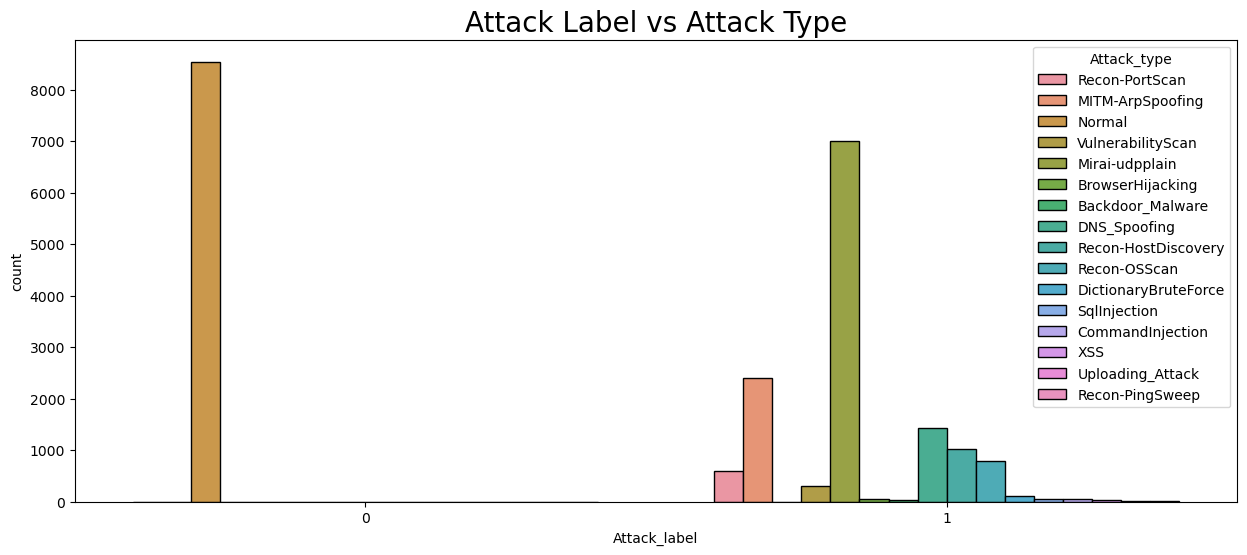

In [50]:
plt.figure(figsize=(15, 6))
sns.countplot(data=df, x='Attack_label', hue='Attack_type', edgecolor='black', linewidth=1)
plt.title('Attack Label vs Attack Type', fontsize=20)
plt.show()

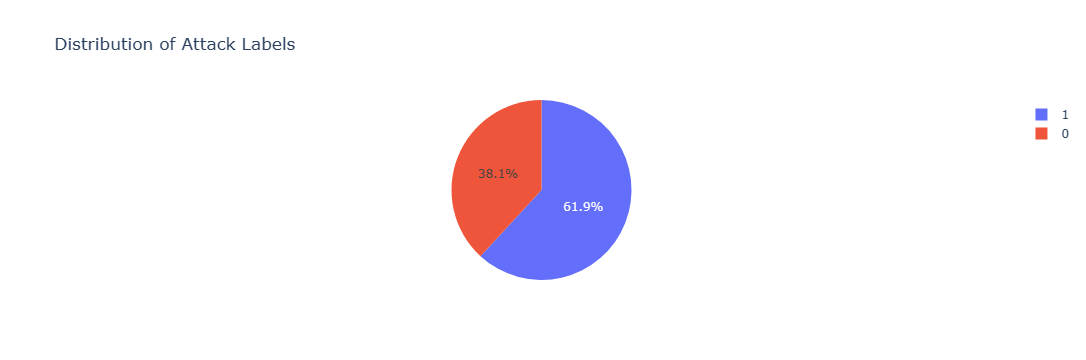

In [51]:
import plotly.express as px

fig = px.pie(df, names='Attack_label', title='Distribution of Attack Labels')
fig.show()


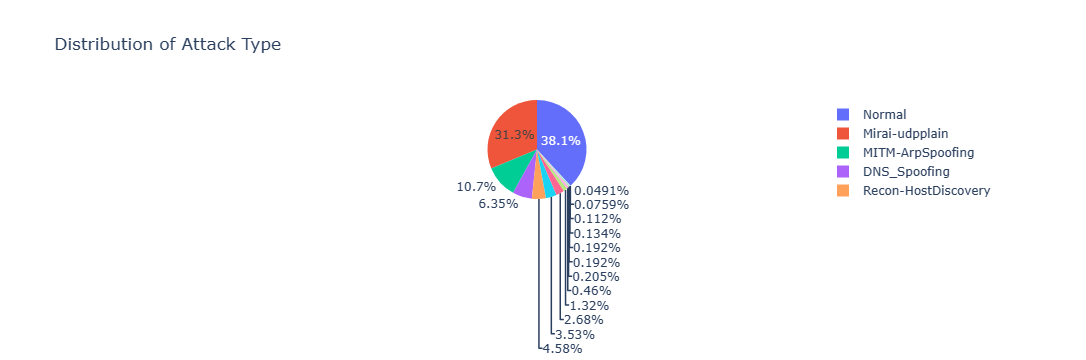

In [52]:
fig = px.pie(df, names='Attack_type', title='Distribution of Attack Type')
fig.show()


- class imbalance issue - this can cause the machine learning model to result in biased results

# Drop empty features

In [53]:
#view dimensions of dataset (rows and columns)
print ("Rows,columns in dataset:", df.shape)

Rows,columns in dataset: (22404, 48)


In [54]:
# Identifying columns that are entirely NaN (empty) or have all zero values
empty_or_zero_columns = df.columns[(df.isnull().all())
| (df == 0).all()   | (df == 1).all() | (df == 1.0).all()
| (df == 0.0).all() | (df == 2).all() | (df == 2.0).all()]

# Displaying the identified columns
empty_features = empty_or_zero_columns.tolist()

print("These columns are all empty features:")
print(empty_features)

for feature in empty_features:
  if feature in df.columns:
    df.drop(feature, axis=1, inplace=True)
    print("Dropping empty feature:", feature)

These columns are all empty features:
['Drate', 'cwr_flag_number', 'Telnet', 'SMTP', 'IRC', 'DHCP']
Dropping empty feature: Drate
Dropping empty feature: cwr_flag_number
Dropping empty feature: Telnet
Dropping empty feature: SMTP
Dropping empty feature: IRC
Dropping empty feature: DHCP


In [55]:
# show the columns to confirm the features have been dropped
df.head()

flow_duration  Header_Length  Protocol_Type  Duration        Rate  \
127       0.000000           58.0            6.0      48.7    0.133304   
255       5.593900      5411305.3            6.0      60.1  664.243267   
383      35.645644        18828.9           11.5      69.1    1.658343   
511      11.567025       660581.8            6.0     114.1  139.341360   
639       0.763520          462.3            5.3      44.8    6.108789   

          Srate  fin_flag_number  syn_flag_number  rst_flag_number  \
127    0.133304              0.0              1.0              0.0   
255  664.243267              0.0              0.0              0.0   
383    1.658343              0.0              0.0              0.0   
511  139.341360              0.0              0.0              0.0   
639    6.108789              0.0              0.0              0.0   

     psh_flag_number  ...  Tot size           IAT  Number   Magnitue  \
127              0.0  ...      58.0  1.664290e+08    13.5  11.643890   
255              0.0  ...    1085.6  6.970882e-04     5.5  24.248639   
383              0.0  ...      71.2  1.808000e-02     5.5  11.558680   
511              0.0  ...    1426.7  1.665203e+08    13.5  47.582073   
639              0.0  ...      78.8  1.668999e-02     5.5  11.667452   

          Radius    Covariance  Variance  Weight       Attack_type  \
127    51.419103  1.331690e+03       1.0   244.6    Recon-PortScan   
255   564.414907  3.430353e+05       0.5    38.5  MITM-ArpSpoofing   
383    14.013556  1.669243e+02       0.8    38.5            Normal   
511  1653.261146  1.368075e+06       1.0   244.6            Normal   
639    13.927324  3.491656e+02       0.7    38.5            Normal   

     Attack_label  
127             1  
255             1  
383             0  
511             0  
639             0  

[5 rows x 42 columns]

In [56]:
#view dimensions of dataset (rows and columns)
print ("Rows,columns in dataset:", df.shape)

Rows,columns in dataset: (22404, 42)


# Drop features with low correlation
Use a correlation heatmap to visualize the correlation between features and then decide which features to drop based on their correlation values. 

- We first compute the correlation matrix using the corr() method of the DataFrame.
- Then, we create a mask to hide the upper triangle of the heatmap using np.triu() to avoid redundancy since correlation matrices are symmetric.
- Next, we use sns.heatmap() to generate the heatmap. We specify the colormap (cmap) as 'coolwarm' for better visualization and set annot=True to display the correlation values on the heatmap.
- Finally, we add a title to the plot and display it using plt.show().
- After visualizing the correlation heatmap, you can analyze the correlation values and decide which features to drop based on their correlation with other features and the target variable. Generally, features with low correlation values (close to 0) or high correlation with other features may be candidates for dropping. However, the decision should be made based on domain knowledge and the specific context of your problem.

In [57]:
df.head()

flow_duration  Header_Length  Protocol_Type  Duration        Rate  \
127       0.000000           58.0            6.0      48.7    0.133304   
255       5.593900      5411305.3            6.0      60.1  664.243267   
383      35.645644        18828.9           11.5      69.1    1.658343   
511      11.567025       660581.8            6.0     114.1  139.341360   
639       0.763520          462.3            5.3      44.8    6.108789   

          Srate  fin_flag_number  syn_flag_number  rst_flag_number  \
127    0.133304              0.0              1.0              0.0   
255  664.243267              0.0              0.0              0.0   
383    1.658343              0.0              0.0              0.0   
511  139.341360              0.0              0.0              0.0   
639    6.108789              0.0              0.0              0.0   

     psh_flag_number  ...  Tot size           IAT  Number   Magnitue  \
127              0.0  ...      58.0  1.664290e+08    13.5  11.643890   
255              0.0  ...    1085.6  6.970882e-04     5.5  24.248639   
383              0.0  ...      71.2  1.808000e-02     5.5  11.558680   
511              0.0  ...    1426.7  1.665203e+08    13.5  47.582073   
639              0.0  ...      78.8  1.668999e-02     5.5  11.667452   

          Radius    Covariance  Variance  Weight       Attack_type  \
127    51.419103  1.331690e+03       1.0   244.6    Recon-PortScan   
255   564.414907  3.430353e+05       0.5    38.5  MITM-ArpSpoofing   
383    14.013556  1.669243e+02       0.8    38.5            Normal   
511  1653.261146  1.368075e+06       1.0   244.6            Normal   
639    13.927324  3.491656e+02       0.7    38.5            Normal   

     Attack_label  
127             1  
255             1  
383             0  
511             0  
639             0  

[5 rows x 42 columns]

C:\Users\njeffrey\anaconda3\lib\site-packages\seaborn\matrix.py:260: FutureWarning:

Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior



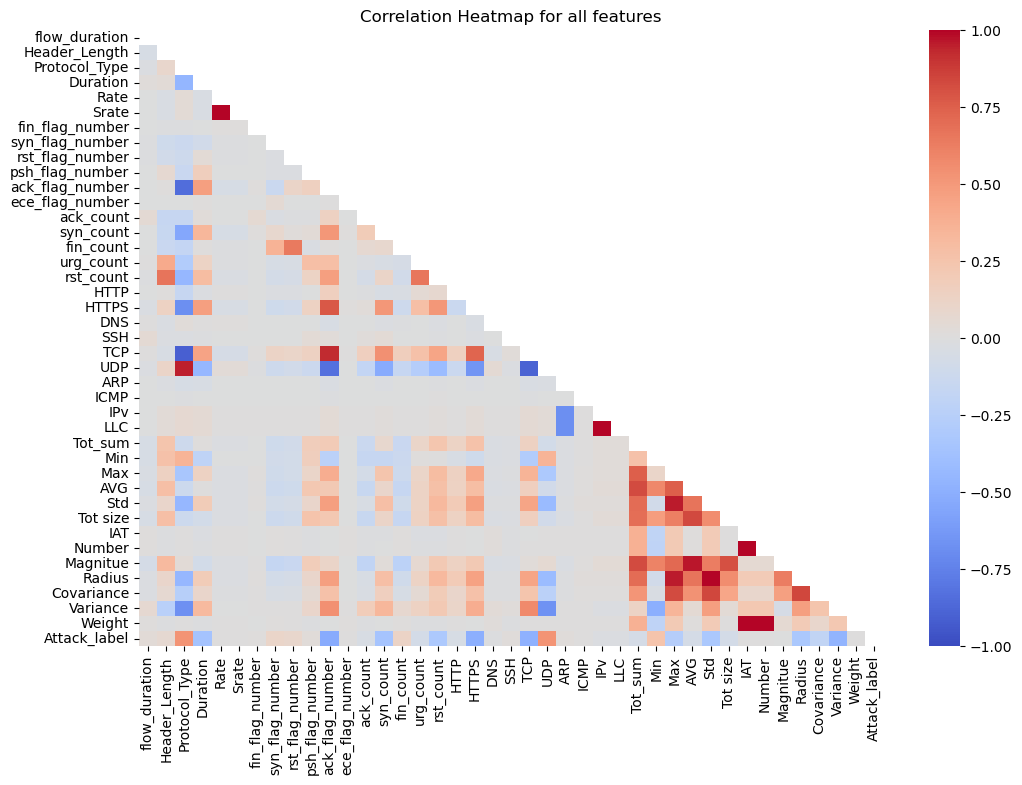

In [58]:
#import pandas as pd
#import seaborn as sns
#import matplotlib.pyplot as plt

# Assuming df is your DataFrame with all the features
# Compute the correlation matrix
corr_matrix = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure, adjust figsize as desired
plt.figure(figsize=(12, 8))



# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", vmin=-1, vmax=1)

# Add title and show plot
plt.title('Correlation Heatmap for all features')
plt.show()


In this code:

- We compute the correlation matrix using the corr() method of the DataFrame, similar to before.
- Then, we create an empty dictionary correlation_values to store the correlation values for each feature.
- We loop through each feature in the correlation matrix.
- For each feature, we extract its correlation values with other features by dropping the feature itself from the correlation matrix.
- Finally, we print the correlation values for each feature.
- This will give you a dictionary where each key is a feature, and the corresponding value is a Series containing the correlation values of that feature with other features. You can then use these correlation values for further analysis or decision-making.

In [59]:
# Compute the correlation matrix (should already exist from previous cell)
corr_matrix = df.corr()

# Extract correlation values for each feature
correlation_values = {}

# Loop through each feature
for feature in corr_matrix.columns:
    # Exclude the feature's own correlation value (which is always 1)
    correlations = corr_matrix[feature].drop(feature)
    correlation_values[feature] = correlations

## Print correlation values for each feature
#for feature, correlations in correlation_values.items():
#    print(f"Correlation values for {feature}:")
#    print(correlations)
#    print()  # Add an empty line for better readability


# Set a threshold for correlation
threshold = 0.10  # Adjust the threshold as needed, started with lowest 10%

# Find features with low correlation with the target variable
low_corr_features = []
for feature in corr_matrix.columns:
    # Exclude the feature's own correlation value (which is always 1)
    correlations = corr_matrix[feature].drop(feature)
    if all(abs(correlation) < threshold for correlation in correlations):
        low_corr_features.append(feature)

# Print the dropped features
print("Dropping these features with low correlation:")
print(low_corr_features)

# Drop features with low correlation
df.drop(low_corr_features, axis=1, inplace=True)



Dropping these features with low correlation:
['flow_duration', 'fin_flag_number', 'ece_flag_number', 'DNS', 'SSH', 'ICMP']


C:\Users\njeffrey\anaconda3\lib\site-packages\seaborn\matrix.py:260: FutureWarning:

Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior



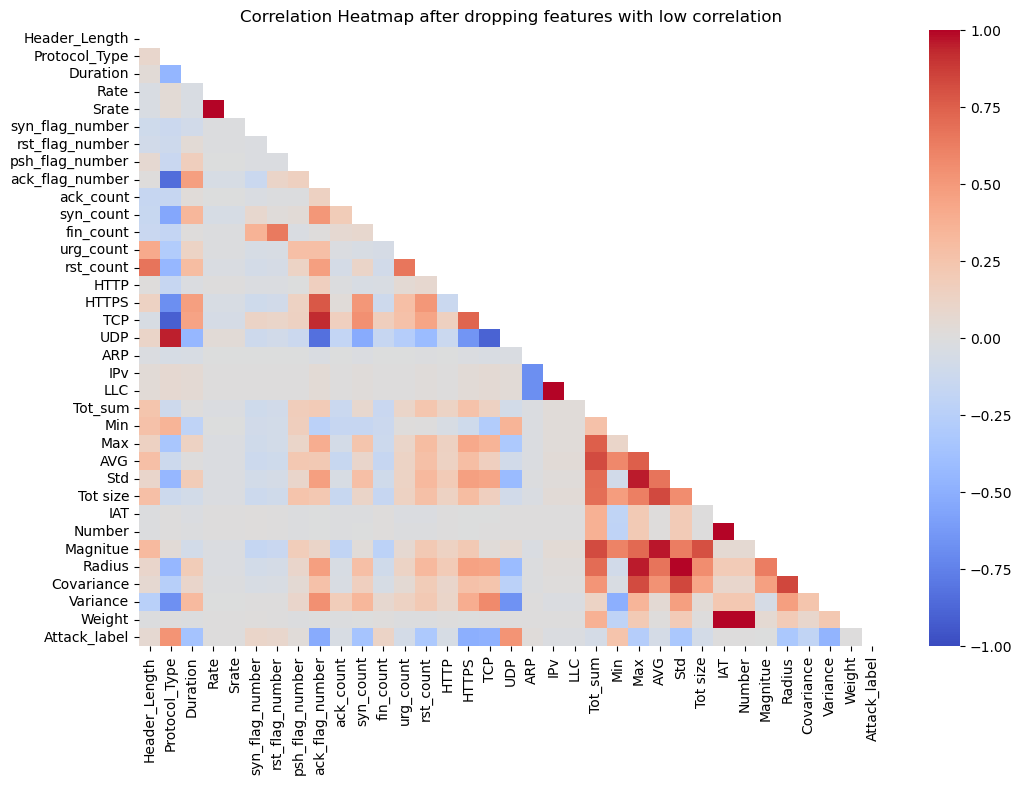

In [60]:
# Compute the correlation matrix again (after dropping features with low correlation)
corr_matrix = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure, adjust figsize as desired
plt.figure(figsize=(12, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", vmin=-1, vmax=1)

# Add title and show plot
plt.title('Correlation Heatmap after dropping features with low correlation')
plt.show()


# Drop features based on domain expertise
Now using our domain knowledge we will only select useful features from our dataset and drop the rest

In [61]:
#view dimensions of dataset (rows and columns)
print ("Rows,columns in dataset:", df.shape)

Rows,columns in dataset: (22404, 36)


In [62]:
# drop these features

# initialize variable
feature_names = []


if dataset_name == "Edge-IIoTset2023":
    feature_names = ["frame.time", "ip.src_host", "ip.dst_host", "arp.src.proto_ipv4","arp.dst.proto_ipv4",
                "http.file_data","http.request.full_uri","icmp.transmit_timestamp",
                "http.request.uri.query", "tcp.options","tcp.payload","tcp.srcport",
                "tcp.dstport", "udp.port", "mqtt.msg", "icmp.unused", "http.tls_port", 'dns.qry.type',
                'dns.retransmit_request_in', "mqtt.msg_decoded_as", "mbtcp.trans_id", "mbtcp.unit_id", "http.request.method", "http.referer",
                "http.request.version", "dns.qry.name.len", "mqtt.conack.flags", "mqtt.protoname", "mqtt.topic"]

if dataset_name == "CIC_IOT_Dataset2023":
   feature_names = ["fin_flag_number", "syn_flag_number", "rst_flag_number", "psh_flag_number", "ack_flag_number", "ece_flag_number", "cwr_flag_number", "ack_count", "syn_count", "fin_count", "urg_count", "rst_count"]


for feature_name in feature_names:
  if feature_name in df.columns:
    df.drop(feature_name, axis=1, inplace=True)
    print("Dropping feature:", feature_name)

Dropping feature: syn_flag_number
Dropping feature: rst_flag_number
Dropping feature: psh_flag_number
Dropping feature: ack_flag_number
Dropping feature: ack_count
Dropping feature: syn_count
Dropping feature: fin_count
Dropping feature: urg_count
Dropping feature: rst_count


In [63]:
#view dimensions of dataset (rows and columns)
print ("Rows,columns in dataset after dropping features:", df.shape)

Rows,columns in dataset after dropping features: (22404, 27)


In [64]:
# print(df[df['tcp.flags.ack'] == 1]['Attack_label'].value_counts(normalize=True))
# print(df[df['tcp.flags.ack'] == 0]['Attack_label'].value_counts(normalize=True))

#df['Attack_label'].groupby(df['tcp.flags.ack']).value_counts(normalize=True)
# hence we group by is prefered

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22404 entries, 127 to 2867711
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Header_Length  22404 non-null  float64
 1   Protocol_Type  22404 non-null  float64
 2   Duration       22404 non-null  float64
 3   Rate           22404 non-null  float64
 4   Srate          22404 non-null  float64
 5   HTTP           22404 non-null  float64
 6   HTTPS          22404 non-null  float64
 7   TCP            22404 non-null  float64
 8   UDP            22404 non-null  float64
 9   ARP            22404 non-null  float64
 10  IPv            22404 non-null  float64
 11  LLC            22404 non-null  float64
 12  Tot_sum        22404 non-null  float64
 13  Min            22404 non-null  float64
 14  Max            22404 non-null  float64
 15  AVG            22404 non-null  float64
 16  Std            22404 non-null  float64
 17  Tot size       22404 non-null  float64
 18  IA

# Label encoding
- Problem: if we use a machine learning model to predict the Attack label, it could predict it as 0.1, 0.2 or 0.99 which is not a valid Attack label
- Solution: Label Encoder

In [66]:
# The final column in the dataset is Attack_type, and will contain either 0 or 1

# Display unique values in the "Attack_type" column
unique_attack_types = df['Attack_type'].unique()
print("Unique Attack Types:")
print(unique_attack_types)

Unique Attack Types:
['Recon-PortScan' 'MITM-ArpSpoofing' 'Normal' 'VulnerabilityScan'
 'Mirai-udpplain' 'BrowserHijacking' 'Backdoor_Malware' 'DNS_Spoofing'
 'Recon-HostDiscovery' 'Recon-OSScan' 'DictionaryBruteForce'
 'SqlInjection' 'CommandInjection' 'XSS' 'Uploading_Attack'
 'Recon-PingSweep']


In [67]:
# add a column to the dataset called "Attack_label"
# this column will only contain 0 or 1, and an integer representation of the text-based "Attack_type" column
# if Attack_type=Normal, then Attack_label=0, otherwise, Attack_level=1

le = LabelEncoder()    #assumes "from sklearn.preprocessing import LabelEncoder"
df['Attack_label'] = le.fit_transform(df['Attack_label'])

print(f"Converting text-based Attack_type feature to integer-baesd Attack_label feature")
df['Attack_label'].value_counts()

Converting text-based Attack_type feature to integer-baesd Attack_label feature


1    13860
0     8544
Name: Attack_label, dtype: int64

In [68]:
# Now that we have encoded the text-based "Attack_type" column into the integer-based "Attack_label" column, we can drop the "Attack_type" column
df.drop('Attack_type', axis=1, inplace=True)

In [69]:
# confirm that the Attack_label column has been added, and the Attack_type column has been removed
df.head()

Header_Length  Protocol_Type  Duration        Rate       Srate  HTTP  \
127           58.0            6.0      48.7    0.133304    0.133304   0.0   
255      5411305.3            6.0      60.1  664.243267  664.243267   0.0   
383        18828.9           11.5      69.1    1.658343    1.658343   0.0   
511       660581.8            6.0     114.1  139.341360  139.341360   0.0   
639          462.3            5.3      44.8    6.108789    6.108789   0.0   

     HTTPS  TCP  UDP  ARP  ...          Std  Tot size           IAT  Number  \
127    0.0  1.0  0.0  0.0  ...    36.280658      58.0  1.664290e+08    13.5   
255    1.0  1.0  0.0  0.0  ...   399.101608    1085.6  6.970882e-04     5.5   
383    0.0  0.0  0.0  0.0  ...     9.909081      71.2  1.808000e-02     5.5   
511    1.0  1.0  0.0  0.0  ...  1168.350480    1426.7  1.665203e+08    13.5   
639    0.0  1.0  0.0  0.0  ...     9.848105      78.8  1.668999e-02     5.5   

      Magnitue       Radius    Covariance  Variance  Weight  Attack_label  
127  11.643890    51.419103  1.331690e+03       1.0   244.6             1  
255  24.248639   564.414907  3.430353e+05       0.5    38.5             1  
383  11.558680    14.013556  1.669243e+02       0.8    38.5             0  
511  47.582073  1653.261146  1.368075e+06       1.0   244.6             0  
639  11.667452    13.927324  3.491656e+02       0.7    38.5             0  

[5 rows x 26 columns]

In [70]:
# separate X and y variables (independent and dependent variables)

X = df.drop(['Attack_label'], axis=1)
y = df['Attack_label']


In [71]:
# Sanity check to confirm X and y have equal number of samples
print(f"X has", len(X), "samples")
print(f"y has", len(y), "samples")
if ( len(X) != len(y) ):
  raise ValueError ("X and y are different lengths, please investigate!")


X has 22404 samples
y has 22404 samples


# Split data into train / test / validation

In [72]:
# Split X and y into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
# Now further split test set into testing and validation sets because Deep Learning models also have validation data
# In this example, the train/test split in the previous cell was 80/20, so the 0.5 split you see in this cell splits the 20% of test data evenly into test and validation
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)



In [74]:
# Sanity check to confirm X_train and y_train have equal number of samples
print(f"X_train has", len(X_train), "samples")
print(f"y_train has", len(y_train), "samples")
if ( len(X_train) != len(y_train) ):
  raise ValueError ("X_train and y_train are different lengths, please investigate!")

# Sanity check to confirm X_test and y_test have equal number of samples
print('\n')
print(f"X_test has", len(X_test), "samples")
print(f"y_test has", len(y_test), "samples")
if ( len(X_test) != len(y_test) ):
  raise ValueError ("X_test and y_test are different lengths, please investigate!")

# Sanity check to confirm X_val and y_val have equal number of samples
print('\n')
print(f"X_val has", len(X_val), "samples")
print(f"y_val has", len(y_val), "samples")
if ( len(X_val) != len(y_val) ):
  raise ValueError ("X_val and y_val are different lengths, please investigate!")



X_train has 17923 samples
y_train has 17923 samples


X_test has 2240 samples
y_test has 2240 samples


X_val has 2241 samples
y_val has 2241 samples


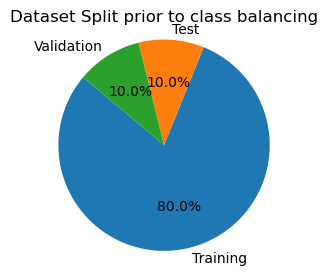

X_train contains 17923 rows, y_train contains 17923 rows
X_test  contains 2240 rows, y_test  contains 2240 rows
X_val   contains 2241 rows, y_val   contains 2241 rows


In [75]:
# create a pie chart showing relative sizes of X_train, X_test, X_val


# Labels for the pie chart
labels = ['Training', 'Test', 'Validation']

# Number of rows in each dataset split
sizes = [len(X_train), len(X_test), len(X_val)]

# Plotting the pie chart
plt.figure(figsize=(3, 3))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Dataset Split prior to class balancing')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

print(f"X_train contains {len(X_train)} rows, y_train contains {len(y_train)} rows")
print(f"X_test  contains {len(X_test)} rows, y_test  contains {len(y_test)} rows")
print(f"X_val   contains {len(X_val)} rows, y_val   contains {len(y_val)} rows")

if (len(X_train) < len(X_test)):
  print(f"\nWARNING: You will notice in the above chart that X_train has fewer rows than X_test or X_val")
  print(f"This should not be the case, because the dataset has not yet undergone any reduction in the size of the training set.")
  print(f"Please confirm that you are working on a clean dataset.")


This pie chart shows the class balance in the training data.
The y_train data is labeled as 0=normal 1=attack 

  normal class contains 6825 samples
abnormal class contains 11098 samples
This dataset is currently imbalanced, will be balanced in next section.


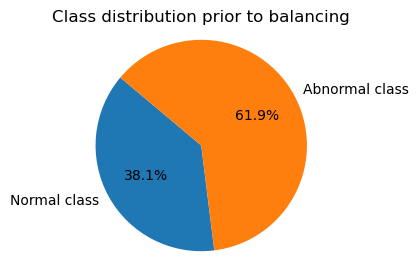

In [76]:
# create a pie chart showing the class balance in the training data

print(f"This pie chart shows the class balance in the training data.")
print(f"The y_train data is labeled as 0=normal 1=attack \n")

# Count the occurrences of each unique value
normal_class   = sum(1 for value in y_train if value == 0)
abnormal_class = sum(1 for value in y_train if value == 1)
print(f"  normal class contains {normal_class} samples")
print(f"abnormal class contains {abnormal_class} samples")
if (normal_class == abnormal_class): print("WARNING: This dataset is not expected to be balanced yet.  Please investigate.")
if (normal_class != abnormal_class): print("This dataset is currently imbalanced, will be balanced in next section.")

# Extract labels and sizes for the pie chart
labels = ["Normal class", "Abnormal class"]
values = [normal_class, abnormal_class]

# Plotting the pie chart
plt.figure(figsize=(3, 3))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Class distribution prior to balancing')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()





# Balance data classes

## SMOTE
This section is only shown as an example, this notebook balances the classes with random undersampling

In [77]:
# If you wanted to balance the classes with SMOTE instead, sample code shown below:

## Create an instance of the SMOTE class
#smote = SMOTE(sampling_strategy='auto')

## Apply SMOTE to the training data
#X_train_resampled, y_train_type_resampled = smote.fit_resample(X_train, y_train)

## sequential undersampling
This section is only shown as an example, this notebook balances the classes with random undersampling

In [78]:
# # sample code to perform sequential undersampling instead of random undersampling

# def sequential_undersample(X, y, minority_class_label, desired_ratio):
#     # Separate majority and minority class samples
#     majority_X = X[y != minority_class_label]
#     majority_y = y[y != minority_class_label]
#     minority_X = X[y == minority_class_label]
#     minority_y = y[y == minority_class_label]

#     print(f"Percentage of minority class samples in y: {sum(y == minority_class_label) / len(y) * 100:.2f}%")
#     print(f"Percentage of minority class samples in minority_y: {sum(minority_y == minority_class_label) / len(minority_y) * 100:.2f}%")

#     # Calculate the number of majority class samples to keep
#     num_minority_samples = len(minority_X)
#     #num_majority_samples = int(num_minority_samples * desired_ratio)
#     num_majority_samples = num_minority_samples

#     # Keep a portion of the majority class samples
#     majority_X_subset = majority_X[:num_majority_samples]
#     majority_y_subset = majority_y[:num_majority_samples]

#     # Combine minority and subset of majority class samples
#     X_balanced = np.concatenate((minority_X, majority_X_subset))
#     y_balanced = np.concatenate((minority_y, majority_y_subset))

#     return X_balanced, y_balanced

# # Usage example
# X_train_balanced, y_train_balanced = sequential_undersample(X_train, y_train, minority_class_label=1, desired_ratio=0.5)


# # Count the occurrences of each unique value
# normal_class   = sum(1 for value in y_train_balanced if value == 0)
# abnormal_class = sum(1 for value in y_train_balanced if value == 1)
# print(f"  normal class contains {normal_class} samples")
# print(f"abnormal class contains {abnormal_class} samples")

# # save the resampled values back to the original variable names so we can use consistent names throughout this notebook
# X_train = X_train_balanced
# y_train = y_train_balanced


## random undersampling

In [79]:
# Initialize RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=1, random_state=42)

# Apply Random Under Sampling
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

print("Class balance before resampling")
print(y_train.value_counts())
print('\n')
print("Class balance after resampling")
print(y_train_resampled.value_counts())

# save the resampled values back to the original variable names so we can use consistent names throughout this notebook
X_train = X_train_resampled
y_train = y_train_resampled


Class balance before resampling
1    11098
0     6825
Name: Attack_label, dtype: int64


Class balance after resampling
0    6825
1    6825
Name: Attack_label, dtype: int64


In [80]:
# confirm the classes are balanced
# Figure out how many rows of each class exist in y_train (0=normal, 1=abnormal)

# Count occurrences of 0 and 1
normal_class   = sum(1 for value in y_train if value == 0)
abnormal_class = sum(1 for value in y_train if value == 1)

print(f"Count of   normal class: {normal_class}")
print(f"Count of abnormal class: {abnormal_class}")

total_rows = abnormal_class + normal_class
print(f"Total Number of rows (normal+abnormal): {total_rows}" )

balance = abnormal_class / total_rows * 100
balance = round(balance,2)

print(f"Percentage of abnormal class in dataset (abnormal/total*100): {balance}%")
if (balance  < 10): print("This dataset is very imbalanced, please beware of overfitting.")
if (balance != 50): print("WARNING: This dataset is supposed to be balanced.  Please investigate.")
if (balance == 50): print("This dataset is perfectly balanced.")

Count of   normal class: 6825
Count of abnormal class: 6825
Total Number of rows (normal+abnormal): 13650
Percentage of abnormal class in dataset (abnormal/total*100): 50.0%
This dataset is perfectly balanced.


In [81]:
# Sanity check to confirm X_train and y_train have equal number of samples
print(f"X_train has", len(X_train), "samples")
print(f"y_train has", len(y_train), "samples")
if ( len(X_train) != len(y_train) ):
  raise ValueError ("X_train and y_train are different lengths, please investigate!")

# Sanity check to confirm X_test and y_test have equal number of samples
print('\n')
print(f"X_test has", len(X_test), "samples")
print(f"y_test has", len(y_test), "samples")
if ( len(X_test) != len(y_test) ):
  raise ValueError ("X_test and y_test are different lengths, please investigate!")

# Sanity check to confirm X_val and y_val have equal number of samples
print('\n')
print(f"X_val has", len(X_val), "samples")
print(f"y_val has", len(y_val), "samples")
if ( len(X_val) != len(y_val) ):
  raise ValueError ("X_val and y_val are different lengths, please investigate!")


X_train has 13650 samples
y_train has 13650 samples


X_test has 2240 samples
y_test has 2240 samples


X_val has 2241 samples
y_val has 2241 samples


In [82]:
# show a running total of elapsed time for the entire notebook
show_elapsed_time()

Current Time: 2024-05-15 20:19:48
The entire notebook runtime so far is 0 minutes


## Visualize class balancing

In [83]:
# sanity check

print(f"X_train contains {len(X_train)} rows, y_train contains {len(y_train)} rows")
print(f"X_test  contains {len(X_test)} rows, y_test  contains {len(y_test)} rows")
print(f"X_val   contains {len(X_val)} rows, y_val   contains {len(y_val)} rows")


X_train contains 13650 rows, y_train contains 13650 rows
X_test  contains 2240 rows, y_test  contains 2240 rows
X_val   contains 2241 rows, y_val   contains 2241 rows


In [84]:
# sanity check
X_train

Header_Length  Protocol_Type  Duration         Rate        Srate  \
2813695      774914.80           6.00     78.10    26.250563    26.250563   
2492031      970840.00           6.00    180.90    56.430455    56.430455   
1091071         410.00           8.10     47.10    14.278708    14.278708   
437247        91656.00           9.30     69.10     4.267784     4.267784   
1540351      812648.00           6.00    232.00   115.522855   115.522855   
...                ...            ...       ...          ...          ...   
795519      1460046.40          15.90     66.30   297.429125   297.429125   
1145983     2028631.20           6.00     87.60  3510.650605  3510.650605   
451071       875232.50          17.00     74.30    68.924986    68.924986   
1050879      777659.60           7.10    197.60    71.081785    71.081785   
2395007     3331346.04          16.83     63.36   771.744448   771.744448   

         HTTP  HTTPS  TCP  UDP  ARP  ...          AVG         Std  Tot size  \
2813695   0.0    1.0  1.0  0.0  0.0  ...   166.759603  180.657477    516.40   
2492031   0.0    1.0  1.0  0.0  0.0  ...  1322.293849  864.844761    590.50   
1091071   0.0    0.0  0.0  0.0  0.0  ...    66.615556    5.464608     72.40   
437247    0.0    0.0  1.0  0.0  0.0  ...   140.782369  113.879949    182.60   
1540351   0.0    1.0  1.0  0.0  0.0  ...   168.455779  359.000463     66.00   
...       ...    ...  ...  ...  ...  ...          ...         ...       ...   
795519    0.0    0.0  0.0  1.0  0.0  ...  1459.079455  640.612269   1449.40   
1145983   1.0    0.0  1.0  0.0  0.0  ...   750.352540  843.694232    780.80   
451071    0.0    0.0  0.0  1.0  0.0  ...   101.367350   90.030588    174.90   
1050879   0.0    1.0  1.0  0.0  0.0  ...    92.480714   31.232051     76.20   
2395007   0.0    0.0  0.0  1.0  0.0  ...   553.218556    3.311298    549.06   

                  IAT  Number   Magnitue       Radius     Covariance  \
2813695  1.106369e-02     5.5  16.536088   255.488254  100505.849258   
2492031  6.157398e-03     5.5  49.593562  1223.075191  841821.334880   
1091071  1.329181e-02     5.5  11.540588     7.728123      38.738342   
437247   1.665181e+08    13.5  16.685061   158.623882   12631.751239   
1540351  1.665224e+08    13.5  18.347745   508.790346  130367.057946   
...               ...     ...        ...          ...            ...   
795519   1.666103e+08    13.5  54.035592   908.046187  413643.415474   
1145983  7.200241e-05     5.5  36.894279  1193.163825  901109.477983   
451071   1.668614e+08    13.5  14.144960   127.525964    8871.606501   
1050879  5.235195e-03     5.5  13.507524    44.168790    1116.288423   
2395007  8.376338e+07     9.5  33.262475     4.720272     371.403580   

         Variance  Weight  
2813695      0.90   38.50  
2492031      0.90   38.50  
1091071      0.90   38.50  
437247       1.00  244.60  
1540351      1.00  244.60  
...           ...     ...  
795519       1.00  244.60  
1145983      0.80   38.50  
451071       1.00  244.60  
1050879      0.90   38.50  
2395007      0.03  141.55  

[13650 rows x 25 columns]

In [85]:
# sanity check
X_test

Header_Length  Protocol_Type  Duration         Rate        Srate  \
2266111       602497.1           8.20    185.80    23.616114    23.616114   
2292223      1705959.9          16.83     63.36  1143.187560  1143.187560   
1579519      3253365.0          17.00     64.00  1974.641250  1974.641250   
1565311           85.0           4.80     39.50    17.448377    17.448377   
2230783       249564.2           6.00     80.70    32.634447    32.634447   
...                ...            ...       ...          ...          ...   
2693375        64866.2           7.10    113.20    21.672518    21.672518   
1487871      1492637.6           6.00    180.90    96.508498    96.508498   
1761663      2503869.0           6.00     93.50   464.506658   464.506658   
780671         19719.7           8.20    192.80    10.751941    10.751941   
397951           623.2           7.10     97.10    13.652604    13.652604   

         HTTP  HTTPS  TCP  UDP  ARP  ...          AVG          Std  Tot size  \
2266111   0.0    0.0  1.0  0.0  0.0  ...    80.224519    49.241651     87.10   
2292223   0.0    0.0  0.0  1.0  0.0  ...   552.619217     5.669435    549.06   
1579519   0.0    0.0  0.0  1.0  0.0  ...   554.000000     0.000000    554.00   
1565311   0.0    0.0  1.0  0.0  0.0  ...    56.581001     2.256500     58.00   
2230783   0.0    1.0  1.0  0.0  0.0  ...  1499.520000    43.440000   1369.20   
...       ...    ...  ...  ...  ...  ...          ...          ...       ...   
2693375   0.0    1.0  1.0  0.0  0.0  ...   164.776587   220.135371    323.80   
1487871   0.0    1.0  1.0  0.0  0.0  ...  1868.265594  1440.514432    500.40   
1761663   0.0    1.0  1.0  0.0  0.0  ...  1274.222222  1701.513029   1466.00   
780671    0.0    1.0  1.0  0.0  0.0  ...   524.529286   522.726643    758.80   
397951    0.0    0.0  1.0  0.0  0.0  ...   119.099649    63.543734     99.40   

                  IAT  Number   Magnitue       Radius    Covariance  Variance  \
2266111  1.665190e+08    13.5  12.664169    69.796349  2.452464e+03      1.00   
2292223  8.378459e+07     9.5  33.244219     8.055181  6.494999e+02      0.05   
1579519  8.376751e+07     9.5  33.286634     0.000000  0.000000e+00      0.00   
1565311  1.668477e+08    13.5  10.637146     3.196432  5.115664e+00      1.00   
2230783  1.791811e-03     5.5  54.757512    61.433437  1.887034e+04      0.10   
...               ...     ...        ...          ...           ...       ...   
2693375  2.316699e-02     5.5  17.081540   311.318427  1.377943e+05      0.80   
1487871  1.665185e+08    13.5  61.067324  2037.700192  2.078293e+06      1.00   
1761663  2.158284e-03     5.5  45.301302  2406.302802  4.210809e+06      0.70   
780671   5.704808e-03     5.5  31.293383   739.247108  4.720718e+05      0.90   
397951   1.668470e+08    13.5  15.452381    89.872823  4.041816e+03      1.00   

         Weight  
2266111  244.60  
2292223  141.55  
1579519  141.55  
1565311  244.60  
2230783   38.50  
...         ...  
2693375   38.50  
1487871  244.60  
1761663   38.50  
780671    38.50  
397951   244.60  

[2240 rows x 25 columns]

In [86]:
# sanity check
y_train

2813695    0
2492031    0
1091071    0
437247     0
1540351    0
          ..
795519     1
1145983    1
451071     1
1050879    1
2395007    1
Name: Attack_label, Length: 13650, dtype: int64

In [87]:
# sanity check
y_test

2266111    0
2292223    1
1579519    1
1565311    1
2230783    0
          ..
2693375    0
1487871    0
1761663    1
780671     0
397951     1
Name: Attack_label, Length: 2240, dtype: int64

In [88]:
# show a running total of elapsed time for the entire notebook
show_elapsed_time()

Current Time: 2024-05-15 20:19:48
The entire notebook runtime so far is 0 minutes


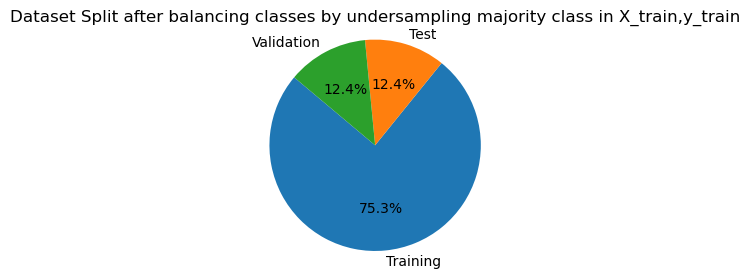

X_train contains 13650 rows, y_train contains 13650  rows
X_test  contains 2240 rows, y_test  contains 2240  rows
X_val   contains 2241 rows, y_val   contains 2241  rows
Please note that this data is after undersampling the majority class for balancing, so it is expected that the 80/10/10 split is changed here.


In [89]:
# create a pie chart showing relative sizes of X_train, X_test, X_val


# Labels for the pie chart
labels = ['Training', 'Test', 'Validation']

# Number of rows in each dataset split
sizes = [len(X_train), len(X_test), len(X_val)]

# Plotting the pie chart
plt.figure(figsize=(3, 3))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Dataset Split after balancing classes by undersampling majority class in X_train,y_train')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

print(f"X_train contains", len(X_train), "rows, y_train contains", len(y_train), " rows")
print(f"X_test  contains", len(X_test), "rows, y_test  contains", len(y_test), " rows")
print(f"X_val   contains", len(X_val), "rows, y_val   contains", len(y_val), " rows")
print(f"Please note that this data is after undersampling the majority class for balancing, so it is expected that the 80/10/10 split is changed here.")

if (len(X_train) < len(X_test)):
  print(f"\nWARNING: You will notice in the above chart that X_train has fewer rows than X_test or X_val")
  print(f"This should not be the case, because the dataset has not yet undergone any reduction in the size of the training set.")
  print(f"Please confirm that you are working on a clean dataset.")


This pie chart shows the class balance in the training data, which is expected to be balanced.
The y_train data is labeled as 0=normal 1=attack 

The y_train training dataset is perfectly balanced.


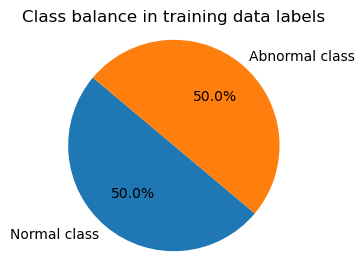

In [90]:
# create a pie chart showing the class balance in the training data (which should be balanced)

print(f"This pie chart shows the class balance in the training data, which is expected to be balanced.")
print(f"The y_train data is labeled as 0=normal 1=attack \n")

# Count the occurrences of each unique value
normal_class   = sum(1 for value in y_train if value == 0)
abnormal_class = sum(1 for value in y_train if value == 1)
if (normal_class != abnormal_class): print("WARNING: y_train data is supposed to be balanced.  Please investigate.")
if (normal_class == abnormal_class): print("The y_train training dataset is perfectly balanced.")

# Extract labels and sizes for the pie chart
labels = ["Normal class", "Abnormal class"]
values = [normal_class, abnormal_class]

# Plotting the pie chart
plt.figure(figsize=(3, 3))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Class balance in training data labels')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


This pie chart shows the class balance in the test data, which is not expected to be balanced.
The y_test data is labeled as 0=normal 1=attack 

The y_test test dataset is not expected to be balanced, because the source dataset is not balanced.


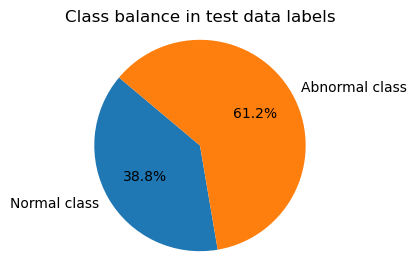

In [91]:
# create a pie chart showing the class balance in the test data (which is not expected to balanced)

print(f"This pie chart shows the class balance in the test data, which is not expected to be balanced.")
print(f"The y_test data is labeled as 0=normal 1=attack \n")

# Count the occurrences of each unique value
normal_class   = sum(1 for value in y_test if value == 0)
abnormal_class = sum(1 for value in y_test if value == 1)
if (normal_class == abnormal_class): print("WARNING: The y_test test dataset is not expected to be balanced.  Please investigate.")
if (normal_class != abnormal_class): print("The y_test test dataset is not expected to be balanced, because the source dataset is not balanced.")

# Extract labels and sizes for the pie chart
labels = ["Normal class", "Abnormal class"]
values = [normal_class, abnormal_class]

# Plotting the pie chart
plt.figure(figsize=(3, 3))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Class balance in test data labels')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


This pie chart shows the class balance in the validation data, which is not expected to be balanced.
The y_val data is labeled as 0=normal 1=attack 

The y_val test dataset is not expected to be balanced, because the source dataset is not balanced.


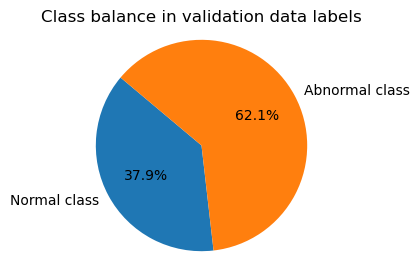

In [92]:
# create a pie chart showing the class balance in the validation data (which is not expected to balanced)

print(f"This pie chart shows the class balance in the validation data, which is not expected to be balanced.")
print(f"The y_val data is labeled as 0=normal 1=attack \n")

# Count the occurrences of each unique value
normal_class   = sum(1 for value in y_val if value == 0)
abnormal_class = sum(1 for value in y_val if value == 1)
if (normal_class == abnormal_class): print("WARNING: The y_val test dataset is not expected to be balanced.  Please investigate.")
if (normal_class != abnormal_class): print("The y_val test dataset is not expected to be balanced, because the source dataset is not balanced.")

# Extract labels and sizes for the pie chart
labels = ["Normal class", "Abnormal class"]
values = [normal_class, abnormal_class]

# Plotting the pie chart
plt.figure(figsize=(3, 3))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Class balance in validation data labels')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [93]:
# show a running total of elapsed time for the entire notebook
show_elapsed_time()

Current Time: 2024-05-15 20:19:48
The entire notebook runtime so far is 0 minutes


# Feature Scaling

In [94]:
# perform feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)  # Only transform the test       set, don't fit
X_val_scaled   = scaler.transform(X_val)   # Only transform the validation set, don't fit

# Save the values under original names so we can use consistent names in subsequent sections
X_train = X_train_scaled
X_test  = X_test_scaled
X_val   = X_val_scaled

# show a running total of elapsed time for the entire notebook
show_elapsed_time()

Current Time: 2024-05-15 20:19:48
The entire notebook runtime so far is 0 minutes


# Save progress in a pickle file
We don't actually use this pickle file anywhere, but it is nice to have available for debugging

In [95]:
import pickle

if   dataset_name == "Edge-IIoTset2023":    output_file = "Edge-IIoTset2023_scaled_data_tuple.pkl"
elif dataset_name == "CIC_IOT_Dataset2023": output_file = "CIC_IOT_Dataset2023_scaled_data_tuple.pkl"

print(f"Saving progress to pickle file: ", output_file)

# Create a tuple
data_tuple = (X_train, X_test, X_val, y_train, y_test, y_val)

# Save the tuple using pickle
with open(output_file, 'wb') as f:
    pickle.dump(data_tuple, f)

Saving progress to pickle file:  CIC_IOT_Dataset2023_scaled_data_tuple.pkl


# Reduce dataset size to speed up analysis

NOTE: When reducing the size of your dataset to speed up training, it's generally recommended to sample only from the training data and leave the validation and test data untouched. Here's why:

Training Data:
- Sampling from the training data allows you to create a smaller subset that can be used for training the model.
- Since the training data is used to update the model's parameters during training, reducing its size can significantly speed up the training process without affecting the evaluation of the model.

Validation Data:
- The validation data is used to tune hyperparameters and monitor the model's performance during training.
- It's important to keep the validation data separate from the training data to ensure an unbiased evaluation of the model's performance.
- Sampling from the validation data could lead to overfitting on the validation set and biased performance estimates.

Test Data:
- Similarly, the test data serves as an unbiased evaluation of the model's performance on unseen data.
- Sampling from the test data could lead to overly optimistic performance estimates, as the model is evaluated on a different distribution than it will encounter in real-world scenarios.

In summary, while it's common to reduce the size of the training data to speed up training, it's important to keep the validation and test data separate and unchanged to ensure unbiased evaluation of the model's performance.

In [96]:
# save these values for comparison at the end of this section
X_train_len = len(X_train)  #re-calculate after subsampling
X_test_len  = len(X_test)   #re-calculate after subsampling
X_val_len   = len(X_val)    #re-calculate after subsampling
y_train_len = len(y_train)  #re-calculate after subsampling
y_test_len  = len(y_test)   #re-calculate after subsampling
y_val_len   = len(y_val)    #re-calculate after subsampling


print(f"X_train contains", len(X_train), "rows, y_train contains", len(y_train), " rows")
print(f"X_test  contains", len(X_test), "rows, y_test  contains", len(y_test), " rows")
print(f"X_val   contains", len(X_val), "rows, y_val   contains", len(y_val), " rows")

print(f"\nThe objective of this section is to see if we can speed up the training process by reducing the size of the dataset, but not losing too much accuracy.")

X_train contains 13650 rows, y_train contains 13650  rows
X_test  contains 2240 rows, y_test  contains 2240  rows
X_val   contains 2241 rows, y_val   contains 2241  rows

The objective of this section is to see if we can speed up the training process by reducing the size of the dataset, but not losing too much accuracy.


In [97]:
# Define a list of fractions to keep
#fractions_to_keep = [0.01, 0.02, 0.05, 0.10, 0.25, 0.50, 0.75, 1.0]
fractions_to_keep = [0.25, 0.50, 0.75, 1.0]


#initialize variables
best_accuracy         = 0
best_fraction_to_keep = 0
accuracy_001          = 0
accuracy_002          = 0
accuracy_005          = 0
accuracy_010          = 0
accuracy_025          = 0
accuracy_050          = 0
accuracy_075          = 0
accuracy_100          = 0

# Iterate through different fractions
for fraction_to_keep in fractions_to_keep:
    # Randomly subsample the training set
    num_samples_to_keep = int(len(X_train) * fraction_to_keep)
    random_indices = np.random.choice(len(X_train), num_samples_to_keep, replace=False)

    X_train_subsampled = X_train[random_indices]
    y_train_subsampled = y_train.iloc[random_indices]   #use .iloc becaue y_train is a 1-dimensional array

    # Train your model on the subsampled data
    #clf = LogisticRegression(max_iter=800, random_state=42)
    clf = MLPClassifier(random_state=42)
    clf.fit(X_train_subsampled, y_train_subsampled)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Evaluate accuracy on the test set
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy on the test set (fraction_to_keep={fraction_to_keep:.4f}): {accuracy:.4f}")

    # Save the accuracy levels for later comparison
    if fraction_to_keep == 0.01: accuracy_001 = accuracy
    if fraction_to_keep == 0.02: accuracy_002 = accuracy
    if fraction_to_keep == 0.05: accuracy_005 = accuracy
    if fraction_to_keep == 0.10: accuracy_010 = accuracy
    if fraction_to_keep == 0.25: accuracy_025 = accuracy
    if fraction_to_keep == 0.50: accuracy_050 = accuracy
    if fraction_to_keep == 0.75: accuracy_075 = accuracy
    if fraction_to_keep == 1.0:  accuracy_100 = accuracy

    # keep track of the best accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_fraction_to_keep = fraction_to_keep


print(f"The highest accuracy is {best_accuracy:.4f} using the {best_fraction_to_keep} fraction of the dataset\n")

# show a running total of elapsed time for the entire notebook
show_elapsed_time()


C:\Users\njeffrey\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



Accuracy on the test set (fraction_to_keep=0.2500): 0.8420


C:\Users\njeffrey\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



Accuracy on the test set (fraction_to_keep=0.5000): 0.8513
Accuracy on the test set (fraction_to_keep=0.7500): 0.8446
Accuracy on the test set (fraction_to_keep=1.0000): 0.8420
The highest accuracy is 0.8513 using the 0.5 fraction of the dataset

Current Time: 2024-05-15 20:20:14
The entire notebook runtime so far is 1 minutes


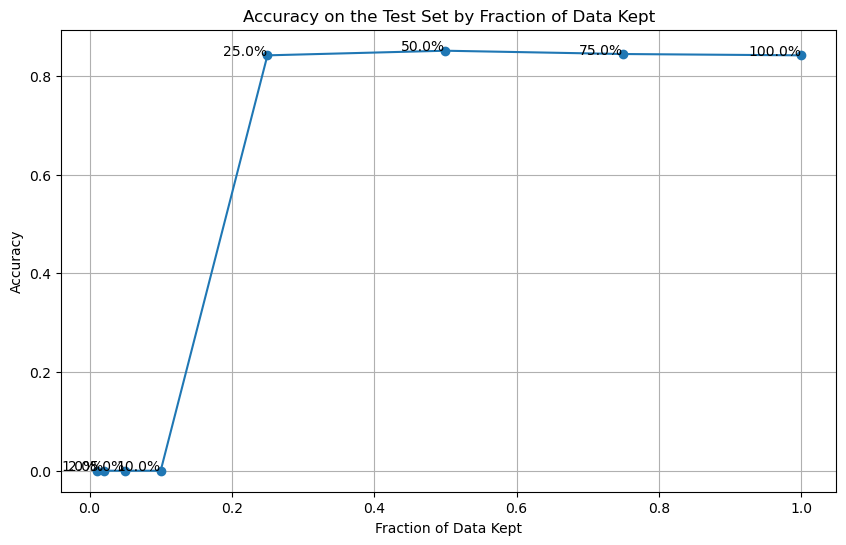

In [98]:
# Visualize the results from the previous cell

# Data extracted from the image
data = {
    'fraction_to_keep': [0.01, 0.02, 0.05, 0.10, 0.25, 0.50, 0.75, 1.00],
    'accuracy': [accuracy_001, accuracy_002, accuracy_005, accuracy_010, accuracy_025, accuracy_050, accuracy_075, accuracy_100]
}

# Create a DataFrame
df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
plt.plot(df['fraction_to_keep'], df['accuracy'], marker='o')

# Adding titles and labels
plt.title('Accuracy on the Test Set by Fraction of Data Kept')
plt.xlabel('Fraction of Data Kept')
plt.ylabel('Accuracy')

# Adding text for each data point
for i in range(len(df)):
    plt.text(df['fraction_to_keep'][i], df['accuracy'][i], f"{df['fraction_to_keep'][i]*100}%", ha='right')

# Adding grid for better readability
plt.grid(True)

# Save the figure with texts
fig_path_with_text = 'accuracy_vs_data_fraction_with_text.png'
plt.savefig(fig_path_with_text)

# Show the figure
plt.show()


In [99]:
# This cell will programnmatically determine the best_fraction_to_keep, by sacrificing some (small) amount of accuracy for speed.
# Exactly how small?  Let's go with an acceptable loss of 1% of accuracy for better speed.

acceptable_loss_of_accuracy = 0.0100  # 0.01*100= 1%  Tweak this value depending on how much accuracy you are willing to sacrifice

if ((best_accuracy - acceptable_loss_of_accuracy) <= accuracy_100):
    print(f"Using 100% of the dataset gives {accuracy_100*100:.2f}% accuracy, which is an acceptable trade-off between accuracy and speed.")
    best_fraction_to_keep = 1.0

if ((best_accuracy - acceptable_loss_of_accuracy) <= accuracy_075):
    print(f"Using  75% of the dataset gives {accuracy_075*100:.2f}% accuracy, which is an acceptable trade-off between accuracy and speed.")
    best_fraction_to_keep = 0.75

if ((best_accuracy - acceptable_loss_of_accuracy) <= accuracy_050):
    print(f"Using  50% of the dataset gives {accuracy_050*100:.2f}% accuracy, which is an acceptable trade-off between accuracy and speed.")
    best_fraction_to_keep = 0.50

if ((best_accuracy - acceptable_loss_of_accuracy) <= accuracy_025):
    print(f"Using  25% of the dataset gives {accuracy_025*100:.2f}% accuracy, which is an acceptable trade-off between accuracy and speed.")
    best_fraction_to_keep = 0.25

if ((best_accuracy - acceptable_loss_of_accuracy) <= accuracy_010):
    print(f"Using  10% of the dataset gives {accuracy_010*100:.2f}% accuracy, which is an acceptable trade-off between accuracy and speed.")
    best_fraction_to_keep = 0.10

if ((best_accuracy - acceptable_loss_of_accuracy) <= accuracy_005):
    print(f"Using   5% of the dataset gives {accuracy_005*100:.2f}% accuracy, which is an acceptable trade-off between accuracy and speed.")
    best_fraction_to_keep = 0.05

if ((best_accuracy - acceptable_loss_of_accuracy) <= accuracy_002):
    print(f"Using   2% of the dataset gives {accuracy_002*100:.2f}% accuracy, which is an acceptable trade-off between accuracy and speed.")
    best_fraction_to_keep = 0.02

if ((best_accuracy - acceptable_loss_of_accuracy) <= accuracy_001):
    print(f"Using   1% of the dataset gives {accuracy_001*100:.2f}% accuracy, which is an acceptable trade-off between accuracy and speed.")
    best_fraction_to_keep = 0.01

print(f"\nBased on the above calculations, we will keep {best_fraction_to_keep*100:.0f}% of the dataset, which will still provide acceptable accuracy.")


Using 100% of the dataset gives 84.20% accuracy, which is an acceptable trade-off between accuracy and speed.
Using  75% of the dataset gives 84.46% accuracy, which is an acceptable trade-off between accuracy and speed.
Using  50% of the dataset gives 85.13% accuracy, which is an acceptable trade-off between accuracy and speed.
Using  25% of the dataset gives 84.20% accuracy, which is an acceptable trade-off between accuracy and speed.

Based on the above calculations, we will keep 25% of the dataset, which will still provide acceptable accuracy.


In [100]:
# Based on the accuracy calculations in the previous cell, decide how much of the dataset to keep
fraction_to_keep = best_fraction_to_keep

# Randomly subsample the training set
num_samples_to_keep = int(len(X_train) * fraction_to_keep)
random_indices = np.random.choice(len(X_train), num_samples_to_keep, replace=False)

#save the sub-sampled data to temporary variable names
X_train_subsampled = X_train[random_indices]
y_train_subsampled = y_train.iloc[random_indices]   #use .iloc becaue y_train is a 1-dimensional array

#save the sub-sampled data back to the original variable names that are used in subsequent sections
X_train = X_train_subsampled
y_train = y_train_subsampled

print(f"\nPrior to downsampling the dataset sizes were:")
print(f"---------------------------------------------")
print(f"X_train previously contained {X_train_len} rows, y_train previously contained {y_train_len} rows")  #these values were calculated prior to subsampling
print(f"X_test  previously contained {X_test_len} rows, y_test  previously contained {y_test_len} rows")
print(f"X_val   previously contained {X_val_len} rows, y_val   previously contained {y_val_len} rows")



print(f"\nAfter downsampling the training data without losing too much accuracy, the new size of the dataset is:")
print(f"------------------------------------------------------------------------------------------------------")
X_train_len = len(X_train)  #re-calculate after subsampling
X_test_len  = len(X_test)   #re-calculate after subsampling
X_val_len   = len(X_val)    #re-calculate after subsampling
y_train_len = len(y_train)  #re-calculate after subsampling
y_test_len  = len(y_test)   #re-calculate after subsampling
y_val_len   = len(y_val)    #re-calculate after subsampling

print(f"X_train now contains {X_train_len} rows, y_train now contains {y_train_len} rows")  #these values were calculated prior to subsampling
print(f"X_test  now contains {X_test_len} rows, y_test  now contains {y_test_len} rows")
print(f"X_val   now contains {X_val_len} rows, y_val   now contains {y_val_len} rows")

if (len(X_train) < len(X_test)):
  print(f"\nWARNING: You have reduced the size of X_train by too much!  X_train should not be smaller than X_test")
  print(f"This is because the training data was reduced via subsampling to speed up processing, but the test and validation data was not reduced in size.")
  print(f"Please go back to the dataset reduction setting and adjust the sizes of of the fractions_to_keep list")
  raise ValueError ("X_train has been reduced by too much, please investigate!")




Prior to downsampling the dataset sizes were:
---------------------------------------------
X_train previously contained 13650 rows, y_train previously contained 13650 rows
X_test  previously contained 2240 rows, y_test  previously contained 2240 rows
X_val   previously contained 2241 rows, y_val   previously contained 2241 rows

After downsampling the training data without losing too much accuracy, the new size of the dataset is:
------------------------------------------------------------------------------------------------------
X_train now contains 3412 rows, y_train now contains 3412 rows
X_test  now contains 2240 rows, y_test  now contains 2240 rows
X_val   now contains 2241 rows, y_val   now contains 2241 rows


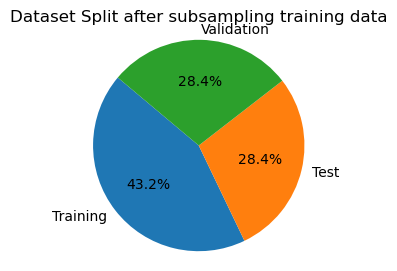

X_train contains 3412 rows, y_train contains 3412  rows
X_test  contains 2240 rows, y_test  contains 2240  rows
X_val   contains 2241 rows, y_val   contains 2241  rows


In [101]:
# create a pie chart showing relative sizes of X_train, X_test, X_val


# Labels for the pie chart
labels = ['Training', 'Test', 'Validation']

# Number of rows in each dataset split
sizes = [len(X_train), len(X_test), len(X_val)]

# Plotting the pie chart
plt.figure(figsize=(3, 3))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Dataset Split after subsampling training data')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

print(f"X_train contains", len(X_train), "rows, y_train contains", len(y_train), " rows")
print(f"X_test  contains", len(X_test), "rows, y_test  contains", len(y_test), " rows")
print(f"X_val   contains", len(X_val), "rows, y_val   contains", len(y_val), " rows")

if (len(X_train) < len(X_test)):
  print(f"\nWARNING: You have reduced the size of X_train by too much!  X_train should not be smaller than X_test")
  print(f"This is because the training data was reduced via subsampling to speed up processing, but the test and validation data was not reduced in size.")
  print(f"Please go back to the dataset reduction setting and adjust the sizes of of the fractions_to_keep list")
  raise ValueError ("X_train has been reduced by too much, please investigate!")


This pie chart shows the class balance in the training data.
The y_train data is labeled as 0=normal 1=attack 



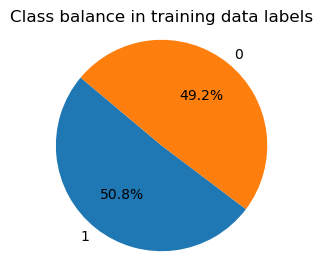

In [102]:
# create a pie chart showing the class balance in the training data

print(f"This pie chart shows the class balance in the training data.")
print(f"The y_train data is labeled as 0=normal 1=attack \n")

# Count the occurrences of each unique value
value_counts = Counter(y_train)    #assumes "from collections import Counter"

# Extract labels and sizes for the pie chart
labels = list(value_counts.keys())
sizes = list(value_counts.values())

# Plotting the pie chart
plt.figure(figsize=(3, 3))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Class balance in training data labels')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


This pie chart shows the class balance in the test data, which is not expected to be balanced.
The y_test data is labeled as 0=normal 1=attack 

The y_test test dataset is not expected to be balanced, because the source dataset is not balanced.


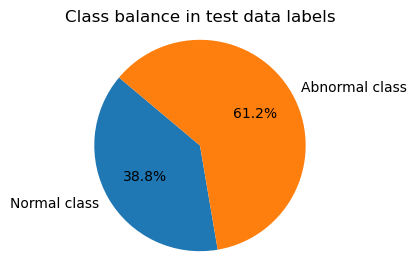

In [103]:
# create a pie chart showing the class balance in the test data (which is not expected to balanced)

print(f"This pie chart shows the class balance in the test data, which is not expected to be balanced.")
print(f"The y_test data is labeled as 0=normal 1=attack \n")

# Count the occurrences of each unique value
normal_class   = sum(1 for value in y_test if value == 0)
abnormal_class = sum(1 for value in y_test if value == 1)
if (normal_class == abnormal_class): print("WARNING: The y_test test dataset is not expected to be balanced.  Please investigate.")
if (normal_class != abnormal_class): print("The y_test test dataset is not expected to be balanced, because the source dataset is not balanced.")

# Extract labels and sizes for the pie chart
labels = ["Normal class", "Abnormal class"]
values = [normal_class, abnormal_class]

# Plotting the pie chart
plt.figure(figsize=(3, 3))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Class balance in test data labels')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


This pie chart shows the class balance in the validation data, which is not expected to be balanced.
The y_val data is labeled as 0=normal 1=attack 

The y_val test dataset is not expected to be balanced, because the source dataset is not balanced.


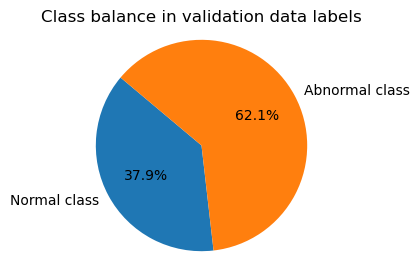

In [104]:
# create a pie chart showing the class balance in the validation data (which is not expected to balanced)

print(f"This pie chart shows the class balance in the validation data, which is not expected to be balanced.")
print(f"The y_val data is labeled as 0=normal 1=attack \n")

# Count the occurrences of each unique value
normal_class   = sum(1 for value in y_val if value == 0)
abnormal_class = sum(1 for value in y_val if value == 1)
if (normal_class == abnormal_class): print("WARNING: The y_val test dataset is not expected to be balanced.  Please investigate.")
if (normal_class != abnormal_class): print("The y_val test dataset is not expected to be balanced, because the source dataset is not balanced.")

# Extract labels and sizes for the pie chart
labels = ["Normal class", "Abnormal class"]
values = [normal_class, abnormal_class]

# Plotting the pie chart
plt.figure(figsize=(3, 3))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Class balance in validation data labels')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [105]:
# show a running total of elapsed time for the entire notebook
show_elapsed_time()

Current Time: 2024-05-15 20:20:15
The entire notebook runtime so far is 1 minutes


# Model training with traditional classifiers

## Logistic Regression

### default params
LR

Training model with default hyperparameters of: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Accuracy: 0.7669642857142858


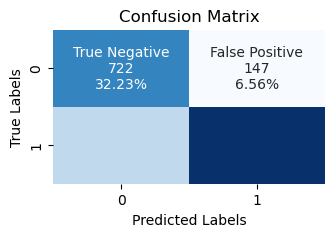




Confusion matrix

 [[722 147]
 [375 996]]

True Negatives  (TN) =  722
False Positives (FP) =  147
False Negatives (FN) =  375
True Positives  (TP) =  996


Accuracy:        0.7669642857142858
Sensitivity:     0.7264770240700219
Specificity:     0.8308400460299195
Geometric Mean:  0.7769081053239282


Precision:        0.7886683041386007
Recall:           0.7669642857142858
f1-score:         0.7699097862607386

------------------------------------------------

Current Time: 2024-05-15 20:20:15
The entire notebook runtime so far is 1 minutes


In [106]:
# Create an instance of the LogisticRegression model
clf = LogisticRegression()

default_params = clf.get_params()
print(f"Training model with default hyperparameters of: {default_params}")

# Fit the model to the training data
clf.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = clf.score(X_test, y_test)
print("Accuracy:", accuracy)

# save accuracy for later comparison
accuracy_lr_unoptimized = accuracy

# call previously defined function to create confusion matrix
# We want to see approximately equal results from TN and TP
cm = visualize_confusion_matrix(y_test, y_pred)

# show a running total of elapsed time for the entire notebook
show_elapsed_time()

### optimized params
LR

The LogisticRegression() class in scikit-learn provides several parameters that can be adjusted to customize the logistic regression model. Here are some of the commonly used parameters:
- penalty: Specifies the norm used in the penalization. It can take values like 'l1' (L1 regularization), 'l2' (L2 regularization), or 'none' (no regularization). The default is 'l2'.
- C: Inverse of regularization strength. Smaller values specify stronger regularization. The default value is 1.0.
- solver: Algorithm to use in the optimization problem. Options include 'liblinear', 'newton-cg', 'lbfgs', 'sag', and 'saga'. The default is 'lbfgs'.
- max_iter: Maximum number of iterations taken for the solvers to converge. The default is 100.
- multi_class: Specifies the strategy to use for multiclass classification. Options include 'auto', 'ovr' (one-vs-rest), and 'multinomial' (softmax). The default is 'auto'.
- verbose: Controls the verbosity of the output. Set to an integer value greater than 0 for more verbosity. The default is 0.
- random_state: Seed used by the random number generator. It ensures reproducibility of results. Set to an integer for reproducible output. The default is None.
- tol: Tolerance for stopping criteria. The default is 1e-4.
class_weight: Weights associated with classes. This can be used to handle class imbalance by assigning higher weights to minority classes.

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best Parameters: {'C': 1.0, 'max_iter': 100, 'multi_class': 'auto', 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs'}
Best Scores: 0.7672806160072714
Cross validation scores: [0.79239766 0.78070175 0.77419355 0.75366569 0.76539589 0.75366569
 0.79765396 0.77419355 0.72140762 0.75953079]
Mean cross validation score: 0.7672806160072714
Standard Deviation cross validation score: 0.020899248502992962
Accuracy: 0.7669642857142858


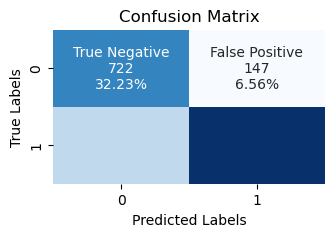




Confusion matrix

 [[722 147]
 [375 996]]

True Negatives  (TN) =  722
False Positives (FP) =  147
False Negatives (FN) =  375
True Positives  (TP) =  996


Accuracy:        0.7669642857142858
Sensitivity:     0.7264770240700219
Specificity:     0.8308400460299195
Geometric Mean:  0.7769081053239282


Precision:        0.7886683041386007
Recall:           0.7669642857142858
f1-score:         0.7699097862607386

------------------------------------------------

Current Time: 2024-05-15 20:26:32
The entire notebook runtime so far is 7 minutes


In [119]:
# Create an instance of the  model
clf = LogisticRegression()

# Define the hyperparameters to tune
param_grid = {
    'penalty': ['l2'],         # penalty='none' is not supported for the liblinear solver, penalty='l1' is not supported for the lbfgs solver, 
    'C': [0.1, 1.0],
    'solver': ['lbfgs'],       # also tried 'liblinear', 'sag'
    'max_iter': [100, 200],
    'multi_class': ['auto'],
    'random_state': [42]       #for reproducible results
}

# Create an instance of GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=cv_count, n_jobs=-1, verbose=verbosity)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_scores = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Scores:", best_scores)

# Create a new instance of the model with the best hyperparameters
clf = LogisticRegression(**best_params)

# Fit the model to the training data
clf.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# final cross validation
cross_val_score_result = cross_val_score(clf, X_train, y_train, cv=cv_count)
print(f"Cross validation scores: {cross_val_score_result}")
print(f"Mean cross validation score: {cross_val_score_result.mean()}")
print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")
lr_crossval_score_all  = cross_val_score_result         #save all folds in a list for later comparison
lr_crossval_score_mean = cross_val_score_result.mean()  #save mean   crossval score in a variable for later comparison
lr_crossval_score_std  = cross_val_score_result.std()   #save stddev crossval score in a variable for later comparison

# Evaluate the model
Accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", Accuracy)

# save best parameters for later comparison
best_params_lr = best_params

# call previously defined function to create confusion matrix
cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# save results calculated for this model for later comparison to other models
accuracy_lr_optimized      = Accuracy
sensitivity_lr_optimized   = Sensitivity
specificity_lr_optimized   = Specificity
geometricmean_lr_optimized = GeometricMean
precision_lr_optimized     = Precision
recall_lr_optimized        = Recall
f1_lr_optimized            = F1

# show a running total of elapsed time for the entire notebook
show_elapsed_time()

## Naive Bayes

### default params
NB

Training model with default hyperparameters of: {'alpha': 1.0, 'binarize': 0.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn'}
Accuracy: 0.7459821428571428


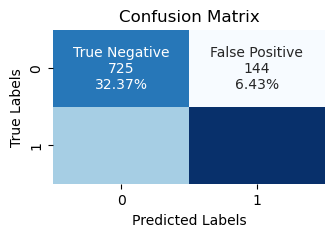




Confusion matrix

 [[725 144]
 [425 946]]

True Negatives  (TN) =  725
False Positives (FP) =  144
False Negatives (FN) =  425
True Positives  (TP) =  946


Accuracy:        0.7459821428571428
Sensitivity:     0.6900072939460248
Specificity:     0.8342922899884925
Geometric Mean:  0.7587277280915676


Precision:        0.7757700403156875
Recall:           0.7459821428571428
f1-score:         0.7491569321649817

------------------------------------------------

Current Time: 2024-05-15 20:26:53
The entire notebook runtime so far is 7 minutes


In [120]:

# Create an instance of the model
#clf = GaussianNB()    # suitable for continuous features
#clf = MultinomialNB() # used for discrete data like word counts
clf = BernoulliNB()    # suitable for binary data, gives best accuracy for this dataset

default_params = clf.get_params()
print(f"Training model with default hyperparameters of: {default_params}")

# Fit the model to the training data
clf.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = clf.score(X_test, y_test)
print("Accuracy:", accuracy)

# save accuracy for later comparison
accuracy_nb_unoptimized = accuracy

# call previously defined function to create confusion matrix
cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# save results calculated for this model for later comparison to other models
accuracy_nb_unoptimized      = Accuracy
sensitivity_nb_unoptimized   = Sensitivity
specificity_nb_unoptimized   = Specificity
geometricmean_nb_unoptimized = GeometricMean
precision_nb_unoptimized     = Precision
recall_nb_unoptimized        = Recall
f1_nb_unoptimized            = F1

# show a running total of elapsed time for the entire notebook
show_elapsed_time()

### optimized params
NB

he BernoulliNB class in scikit-learn represents a naive Bayes classifier for Bernoulli-distributed data. Here are the parameters of the BernoulliNB class:

- alpha: (float, default=1.0 or 1e-10)
Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing).
- binarize: (float or None, default=None)
Threshold for binarizing (mapping to boolean) of sample features. If None, no binarization is performed.
- fit_prior: (bool, default=True)
Whether to learn class prior probabilities or not. If False, a uniform prior will be used.
- class_prior: (array-like of shape (n_classes,), default=None)
Prior probabilities of the classes. If specified, the priors are not adjusted according to the data.
- min_df: (float or int, default=1)
When building the vocabulary, ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature.
- max_df: (float or int, default=1.0)
When building the vocabulary, ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). If float, the parameter represents a proportion of documents, integer absolute counts.
- max_features: (int, default=None)
If not None, build a vocabulary that only considers the top max_features ordered by term frequency across the corpus.
- binary: (bool, default=False)
Whether to treat all values greater than zero as 1, and all others as 0.
- n_jobs: (int, default=None)
The number of parallel jobs to run. -1 means using all processors.


These parameters allow you to customize the behavior of the Bernoulli Naive Bayes classifier according to your specific needs and the characteristics of your data.

Performing GridSearchCV
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best Parameters: {'alpha': 1.0}
Best Scores: 0.7584958241155185
Fitting the model
Cross validation scores: [0.78070175 0.74853801 0.7771261  0.7771261  0.77419355 0.72434018
 0.76832845 0.75659824 0.71554252 0.76246334]
Mean cross validation score: 0.7584958241155185
Standard Deviation cross validation score: 0.02158812450219324
Accuracy: 0.7459821428571428


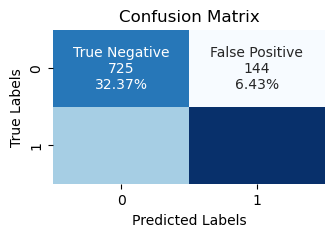




Confusion matrix

 [[725 144]
 [425 946]]

True Negatives  (TN) =  725
False Positives (FP) =  144
False Negatives (FN) =  425
True Positives  (TP) =  946


Accuracy:        0.7459821428571428
Sensitivity:     0.6900072939460248
Specificity:     0.8342922899884925
Geometric Mean:  0.7587277280915676


Precision:        0.7757700403156875
Recall:           0.7459821428571428
f1-score:         0.7491569321649817

------------------------------------------------

Current Time: 2024-05-15 20:26:57
The entire notebook runtime so far is 8 minutes


In [121]:
# Create an instance of the model
clf = BernoulliNB()

# Define the hyperparameters to tune
# skip the sigmoid and poly kernels, rarely used
param_grid = {
    'alpha': [1.0, 0.1, 0.01, 0.001]
}


# Create an instance of GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=cv_count, n_jobs=-1, verbose=verbosity)

# Fit the grid search to the training data
print("Performing GridSearchCV")
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_scores = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Scores:", best_scores)

# Create a new instance of model with the best hyperparameters
clf = BernoulliNB(**best_params)

# Fit the model to the training data
print("Fitting the model")
clf.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# final cross validation
cross_val_score_result = cross_val_score(clf, X_train, y_train, cv=cv_count)
print(f"Cross validation scores: {cross_val_score_result}")
print(f"Mean cross validation score: {cross_val_score_result.mean()}")
print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")
nb_crossval_score_all  = cross_val_score_result         #save all folds in a list for later comparison
nb_crossval_score_mean = cross_val_score_result.mean()  #save mean   crossval score in a variable for later comparison
nb_crossval_score_std  = cross_val_score_result.std()   #save stddev crossval score in a variable for later comparison

# Evaluate the model
Accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", Accuracy)

# save best parameters for later comparison
best_params_nb = best_params

# call previously defined function to create confusion matrix
cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# save results calculated for this model for later comparison to other models
accuracy_nb_optimized      = Accuracy
sensitivity_nb_optimized   = Sensitivity
specificity_nb_optimized   = Specificity
geometricmean_nb_optimized = GeometricMean
precision_nb_optimized     = Precision
recall_nb_optimized        = Recall
f1_nb_optimized            = F1

# show a running total of elapsed time for the entire notebook
show_elapsed_time()

# KNN

### default params
KNN

Training model with default hyperparameters of: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Accuracy: 0.8129464285714286


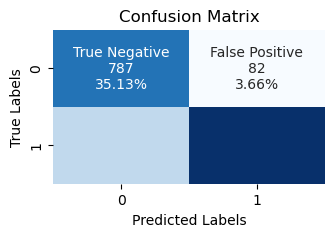




Confusion matrix

 [[ 787   82]
 [ 337 1034]]

True Negatives  (TN) =  787
False Positives (FP) =  82
False Negatives (FN) =  337
True Positives  (TP) =  1034


Accuracy:        0.8129464285714286
Sensitivity:     0.7541940189642596
Specificity:     0.905638665132336
Geometric Mean:  0.826454635527918


Precision:        0.8387134228547922
Recall:           0.8129464285714286
f1-score:         0.8153233786156079

------------------------------------------------

Current Time: 2024-05-15 20:27:01
The entire notebook runtime so far is 8 minutes


In [122]:
# Create an instance of the model with the desired number of neighbors (you can adjust n_neighbors)
clf = KNeighborsClassifier(n_neighbors=5)  # You can change the value of n_neighbors as needed

default_params = clf.get_params()
print(f"Training model with default hyperparameters of: {default_params}")

# Fit the model to the training data
clf.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = clf.score(X_test, y_test)
print("Accuracy:", accuracy)

# save accuracy for later comparison
accuracy_knn_unoptimized = accuracy

# call previously defined function to create confusion matrix
cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# save results calculated for this model for later comparison to other models
accuracy_knn_unoptimized      = Accuracy
sensitivity_knn_unoptimized   = Sensitivity
specificity_knn_unoptimized   = Specificity
geometricmean_knn_unoptimized = GeometricMean
precision_knn_unoptimized     = Precision
recall_knn_unoptimized        = Recall
f1_knn_unoptimized            = F1

# show a running total of elapsed time for the entire notebook
show_elapsed_time()

### optimized params
KNN

Performing grid_search to find optimal parameters
Best Parameters: {'n_neighbors': 10, 'weights': 'distance'}
Best Scores: 0.8209180086090104
Cross validation scores: [0.8245614  0.84502924 0.82697947 0.85337243 0.81818182 0.81818182
 0.85630499 0.82991202 0.76246334 0.77419355]
Mean cross validation score: 0.8209180086090104
Standard Deviation cross validation score: 0.029381769630296563
Accuracy: 0.8111607142857142


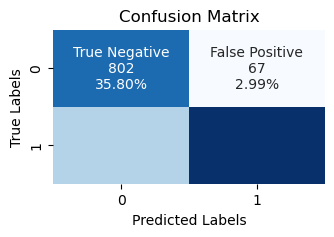




Confusion matrix

 [[ 802   67]
 [ 356 1015]]

True Negatives  (TN) =  802
False Positives (FP) =  67
False Negatives (FN) =  356
True Positives  (TP) =  1015


Accuracy:        0.8111607142857142
Sensitivity:     0.7403355215171408
Specificity:     0.9228998849252014
Geometric Mean:  0.826592745924018


Precision:        0.8428351441653635
Recall:           0.8111607142857142
f1-score:         0.8134985742746638

------------------------------------------------

Current Time: 2024-05-15 20:27:11
The entire notebook runtime so far is 8 minutes


In [123]:
# Create an instance of the model
clf = KNeighborsClassifier()

# Define the hyperparameters to tune
param_grid = {
    'n_neighbors': [5,10,15,20,30],
    'weights': ['uniform', 'distance']
}



# Create an instance of GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=cv_count, n_jobs=-1)

# Fit the grid search to the training data
print(f"Performing grid_search to find optimal parameters")
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_scores = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Scores:", best_scores)

# Create a new instance of the model with the best hyperparameters
clf = KNeighborsClassifier(**best_params)

# Fit the model to the training data
clf.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# final cross validation
cross_val_score_result = cross_val_score(clf, X_train, y_train, cv=cv_count)
print(f"Cross validation scores: {cross_val_score_result}")
print(f"Mean cross validation score: {cross_val_score_result.mean()}")
print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")
knn_crossval_score_all  = cross_val_score_result         #save all folds in a list for later comparison
knn_crossval_score_mean = cross_val_score_result.mean()  #save mean   crossval score in a variable for later comparison
knn_crossval_score_std  = cross_val_score_result.std()   #save stddev crossval score in a variable for later comparison

# Evaluate the model
Accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", Accuracy)

# save best parameters for later comparison
best_params_knn = best_params

# call previously defined function to create confusion matrix
cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# save results calculated for this model for later comparison to other models
accuracy_knn_optimized      = Accuracy
sensitivity_knn_optimized   = Sensitivity
specificity_knn_optimized   = Specificity
geometricmean_knn_optimized = GeometricMean
precision_knn_optimized     = Precision
recall_knn_optimized        = Recall
f1_knn_optimized            = F1

# show a running total of elapsed time for the entire notebook
show_elapsed_time()

## SVM

### default params
SVM

In [124]:
# # Create an instance of the model
# clf = SVC()

# default_params = clf.get_params()
# print(f"Training model with default hyperparameters of: {default_params}")

# # Fit the model to the training data
# clf.fit(X_train, y_train)

# # Predict the labels for the test data
# y_pred = clf.predict(X_test)

# # Evaluate the model
# accuracy = clf.score(X_test, y_test)
# print("Accuracy:", accuracy)

# # save accuracy for later comparison
# accuracy_svm_undersampled_unoptimized = accuracy

# # call previously defined function to create confusion matrix
# cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# # save results calculated for this model for later comparison to other models
# accuracy_svm_unoptimized      = Accuracy
# sensitivity_svm_unoptimized   = Sensitivity
# specificity_svm_unoptimized   = Specificity
# geometricmean_svm_unoptimized = GeometricMean
# precision_svm_unoptimized     = Precision
# recall_svm_unoptimized        = Recall
# f1_svm_unoptimized            = F1

# # show a running total of elapsed time for the entire notebook
# show_elapsed_time()

### optimized params
SVM

In [125]:
print("WARNING: SVM hyperparameter optimization is very CPU-intensive, this will take some time...")

# use the accuracy value prior to hyperparameter optimization so we still have something to copmare to at the end of this notebook
accuracy_svm_optimized = accuracy_svm_unoptimized

In [126]:
# # Create an instance of the model
# clf = SVC()

# # Define the hyperparameters to tune
# # skip the sigmoid and poly kernels, rarely used
# param_grid = {
#     'C': [0.1, 1, 10],
#     'kernel': ['rbf', 'linear'],
#     'probability': [True],               #probability=True is required for VotingClassifier
#     'random_state': [42]                 #for reproducible results
# }



# # Create an instance of GridSearchCV
# grid_search = GridSearchCV(clf, param_grid, cv=cv_count, n_jobs=-1, verbose=verbosity)

# # Fit the grid search to the training data
# print("Performing GridSearchCV")
# grid_search.fit(X_train, y_train)

# # Get the best hyperparameters
# best_params = grid_search.best_params_
# best_scores = grid_search.best_score_
# print("Best Parameters:", best_params)
# print("Best Scores:", best_scores)

# # Create a new instance of model with the best hyperparameters
# clf = SVC(**best_params)

# # Fit the model to the training data
# print("Fitting the model")
# clf.fit(X_train, y_train)

# # Predict the labels for the test data
# y_pred = clf.predict(X_test)

# # final cross validation
# cross_val_score_result = cross_val_score(clf, X_train, y_train, cv=cv_count)
# print(f"Cross validation scores: {cross_val_score_result}")
# print(f"Mean cross validation score: {cross_val_score_result.mean()}")
# print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")
# svm_crossval_score_all  = cross_val_score_result         #save all folds in a list for later comparison
# svm_crossval_score_mean = cross_val_score_result.mean()  #save mean   crossval score in a variable for later comparison
# svm_crossval_score_std  = cross_val_score_result.std()   #save stddev crossval score in a variable for later comparison

# # Evaluate the model
# Accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", Accuracy)

# # save best parameters for later comparison
# best_params_svm = best_params

# # call previously defined function to create confusion matrix
# cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# # save results calculated for this model for later comparison to other models
# accuracy_svm_optimized      = Accuracy
# sensitivity_svm_optimized   = Sensitivity
# specificity_svm_optimized   = Specificity
# geometricmean_svm_optimized = GeometricMean
# precision_svm_optimized     = Precision
# recall_svm_optimized        = Recall
# f1_svm_optimized            = F1

# # show a running total of elapsed time for the entire notebook
# show_elapsed_time()

## Decision Tree

### default params

Training model with default hyperparameters of: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
Accuracy: 0.9200892857142857


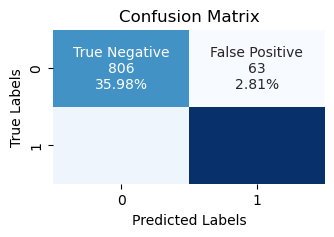




Confusion matrix

 [[ 806   63]
 [ 116 1255]]

True Negatives  (TN) =  806
False Positives (FP) =  63
False Negatives (FN) =  116
True Positives  (TP) =  1255


Accuracy:        0.9200892857142857
Sensitivity:     0.9153902261123268
Specificity:     0.9275028768699655
Geometric Mean:  0.9214266482893966


Precision:        0.9219351468228759
Recall:           0.9200892857142857
f1-score:         0.9204841436176734

------------------------------------------------

Current Time: 2024-05-15 20:27:27
The entire notebook runtime so far is 8 minutes


In [127]:
# Create an instance of the DecisionTreeClassifier model
clf = DecisionTreeClassifier()

default_params = clf.get_params()
print(f"Training model with default hyperparameters of: {default_params}")

# Fit the model to the training data
clf.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = clf.score(X_test, y_test)
print("Accuracy:", accuracy)

# save accuracy for later comparison
accuracy_dt_unoptimized = accuracy

# call previously defined function to create confusion matrix
cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# save results calculated for this model for later comparison to other models
accuracy_dt_unoptimized      = Accuracy
sensitivity_dt_unoptimized   = Sensitivity
specificity_dt_unoptimized   = Specificity
geometricmean_dt_unoptimized = GeometricMean
precision_dt_unoptimized     = Precision
recall_dt_unoptimized        = Recall
f1_dt_unoptimized            = F1

# show a running total of elapsed time for the entire notebook
show_elapsed_time()

### optimized params
DT

Performing grid_search to find optimal parameters
Fitting 10 folds for each of 90 candidates, totalling 900 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42}
Best Scores: 0.9276037111351203
Cross validation scores: [0.94444444 0.92690058 0.92375367 0.91495601 0.93841642 0.93255132
 0.92668622 0.92668622 0.91202346 0.92961877]
Mean cross validation score: 0.9276037111351203
Standard Deviation cross validation score: 0.009212891222385023
Accuracy: 0.9174107142857143


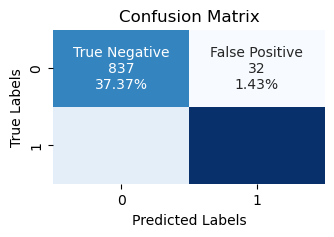




Confusion matrix

 [[ 837   32]
 [ 153 1218]]

True Negatives  (TN) =  837
False Positives (FP) =  32
False Negatives (FN) =  153
True Positives  (TP) =  1218


Accuracy:        0.9174107142857143
Sensitivity:     0.888402625820569
Specificity:     0.9631760644418872
Geometric Mean:  0.9250341316825526


Precision:        0.9243760714285715
Recall:           0.9174107142857143
f1-score:         0.9181921399045295

------------------------------------------------

Current Time: 2024-05-15 20:27:36
The entire notebook runtime so far is 8 minutes


In [128]:
# Create an instance of the DecisionTreeClassifier model
clf = DecisionTreeClassifier()

# Define the hyperparameters to tune
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'random_state': [42]                 #for reproducible results
}

# Create an instance of GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=cv_count,n_jobs=-1, verbose=verbosity)

# Fit the grid search to the training data
print(f"Performing grid_search to find optimal parameters")
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_scores = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Scores:", best_scores)

# Create a new instance of the model with the best hyperparameters
clf = DecisionTreeClassifier(**best_params)

# Fit the model to the training data
clf.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# final cross validation
cross_val_score_result = cross_val_score(clf, X_train, y_train, cv=cv_count)
print(f"Cross validation scores: {cross_val_score_result}")
print(f"Mean cross validation score: {cross_val_score_result.mean()}")
print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")
dt_crossval_score_all  = cross_val_score_result         #save all folds in a list for later comparison
dt_crossval_score_mean = cross_val_score_result.mean()  #save mean   crossval score in a variable for later comparison
dt_crossval_score_std  = cross_val_score_result.std()   #save stddev crossval score in a variable for later comparison

# Evaluate the model
Accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", Accuracy)

# save best parameters for later comparison
best_params_dt = best_params

# call previously defined function to create confusion matrix
cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# save results calculated for this model for later comparison to other models
accuracy_dt_optimized      = Accuracy
sensitivity_dt_optimized   = Sensitivity
specificity_dt_optimized   = Specificity
geometricmean_dt_optimized = GeometricMean
precision_dt_optimized     = Precision
recall_dt_optimized        = Recall
f1_dt_optimized            = F1

# show a running total of elapsed time for the entire notebook
show_elapsed_time()

## Random Forest

### default params

Training model with default hyperparameters of: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Accuracy: 0.9290178571428571


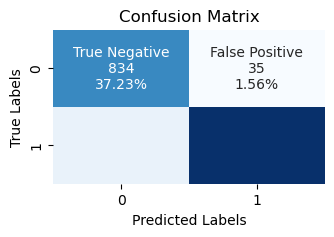




Confusion matrix

 [[ 834   35]
 [ 124 1247]]

True Negatives  (TN) =  834
False Positives (FP) =  35
False Negatives (FN) =  124
True Positives  (TP) =  1247


Accuracy:        0.9290178571428571
Sensitivity:     0.9095550692924872
Specificity:     0.9597238204833142
Geometric Mean:  0.9343027700062498


Precision:        0.9330759088363834
Recall:           0.9290178571428571
f1-score:         0.9295561434927896

------------------------------------------------

Current Time: 2024-05-15 20:27:39
The entire notebook runtime so far is 8 minutes


In [129]:
# Create an instance of the RandomForestClassifier model
clf = RandomForestClassifier(n_jobs=-1, random_state=42)

default_params = clf.get_params()
print(f"Training model with default hyperparameters of: {default_params}")

# Fit the model to the training data
clf.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = clf.score(X_test, y_test)
print("Accuracy:", accuracy)

# save accuracy for later comparison
accuracy_rf_unoptimized = accuracy

# call previously defined function to create confusion matrix
cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# save results calculated for this model for later comparison to other models
accuracy_rf_unoptimized      = Accuracy
sensitivity_rf_unoptimized   = Sensitivity
specificity_rf_unoptimized   = Specificity
geometricmean_rf_unoptimized = GeometricMean
precision_rf_unoptimized     = Precision
recall_rf_unoptimized        = Recall
f1_rf_unoptimized            = F1

# show a running total of elapsed time for the entire notebook
show_elapsed_time()

### optimized params
RF

The RandomForestClassifier() class in scikit-learn provides several parameters that can be adjusted to customize the random forest model. Here are some of the commonly used parameters:

- n_estimators: The number of trees in the forest. Higher values usually yield better performance, but also increase computational cost. The default is 100.
- criterion: The function used to measure the quality of a split. It can be 'gini' for the Gini impurity or 'entropy' for the information gain. The default is 'gini'.
- max_depth: The maximum depth of the tree. If None, nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. The default is None.
- min_samples_split: The minimum number of samples required to split an internal node. The default is 2.
min_samples_leaf: The minimum number of samples required to be at a leaf node. The default is 1.
Vmax_features: The number of features to consider when looking for the best split. It can be 'auto' (sqrt(n_features)), 'sqrt' (sqrt(n_features)), 'log2' (log2(n_features)), or a number between 0 and 1 (fraction of total features). The default is 'auto'.
- bootstrap: Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree. The default is True.
- random_state: Seed used by the random number generator. It ensures reproducibility of results. Set to an integer for reproducible output. The default is None.
- n_jobs: The number of jobs to run in parallel for both fit and predict. -1 means using all processors. The default is 1.
- verbose: Controls the verbosity of the output. Set to an integer value greater than 0 for more verbosity. The default is 0.
- class_weight: Weights associated with classes. This can be used to handle class imbalance by assigning higher weights to minority classes.

Performing grid_search to find optimal parameters
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best Parameters: {'criterion': 'gini', 'n_estimators': 500, 'random_state': 42}
Best Scores: 0.9363987926806263
Cross validation scores: [0.95321637 0.92690058 0.92668622 0.93255132 0.93841642 0.93841642
 0.94428152 0.95014663 0.91788856 0.93548387]
Mean cross validation score: 0.9363987926806263
Standard Deviation cross validation score: 0.010416006678733703
Accuracy: 0.9316964285714285


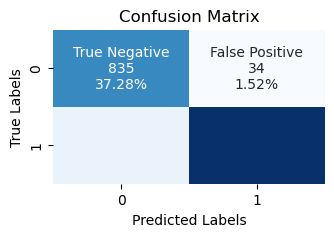




Confusion matrix

 [[ 835   34]
 [ 119 1252]]

True Negatives  (TN) =  835
False Positives (FP) =  34
False Negatives (FN) =  119
True Positives  (TP) =  1252


Accuracy:        0.9316964285714285
Sensitivity:     0.913202042304887
Specificity:     0.9608745684695051
Geometric Mean:  0.9367350843889531


Precision:        0.9354265388322744
Recall:           0.9316964285714285
f1-score:         0.9321962560981504

------------------------------------------------

Current Time: 2024-05-15 20:30:22
The entire notebook runtime so far is 11 minutes


In [130]:
# Create an instance of the RandomForestClassifier model
clf = RandomForestClassifier(n_jobs=-1)

# Define the hyperparameters to tune
param_grid = {
    #'n_estimators': [100, 200, 300, 500],  #adding more hyperparameters made accuracy worse than default
    'criterion': ['gini', 'entropy'],
    #'max_depth': ['None', 5, 10],          #adding more hyperparameters made accuracy worse than default
    #'class_weight': ['None', 'balanced'],  #adding more hyperparameters made accuracy worse than default
    'random_state': [42]                    #for reproducible results
}

# Create an instance of GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=cv_count, n_jobs=-1, verbose=verbosity)

# Fit the grid search to the training data
print("Performing grid_search to find optimal parameters")
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_scores = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Scores:", best_scores)

# Create a new instance of the model with the best hyperparameters
clf = RandomForestClassifier(**best_params)

# Fit the model to the training data
clf.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# final cross validation
cross_val_score_result = cross_val_score(clf, X_train, y_train, cv=cv_count)
print(f"Cross validation scores: {cross_val_score_result}")
print(f"Mean cross validation score: {cross_val_score_result.mean()}")
print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")
rf_crossval_score_all  = cross_val_score_result         #save all folds in a list for later comparison
rf_crossval_score_mean = cross_val_score_result.mean()  #save mean   crossval score in a variable for later comparison
rf_crossval_score_std  = cross_val_score_result.std()   #save stddev crossval score in a variable for later comparison

# Evaluate the model
Accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", Accuracy)

# save best parameters for later comparison
best_params_rf = best_params

# call previously defined function to create confusion matrix
cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# save results calculated for this model for later comparison to other models
accuracy_rf_optimized      = Accuracy
sensitivity_rf_optimized   = Sensitivity
specificity_rf_optimized   = Specificity
geometricmean_rf_optimized = GeometricMean
precision_rf_optimized     = Precision
recall_rf_optimized        = Recall
f1_rf_optimized            = F1

# show a running total of elapsed time for the entire notebook
show_elapsed_time()

## Gradient Boosting

Gradient Boosting is a popular machine learning technique used for both regression and classification tasks. It is an ensemble learning method that builds a strong predictive model by combining the predictions of multiple weaker models, typically decision trees. Here's how gradient boosting works:

1. Base Learners (Weak Models): Gradient Boosting combines the predictions of multiple weak models, often decision trees, to create a strong predictive model. These weak models are referred to as base learners or weak learners.
2. Sequential Training: Gradient Boosting trains the weak models sequentially. Each new model is trained to correct the errors made by the previous models.
3. Loss Function: During training, Gradient Boosting minimizes a loss function, which measures the difference between the actual target values and the predicted values of the ensemble model. Common loss functions include mean squared error (MSE) for regression tasks and cross-entropy loss for classification tasks.
4. Gradient Descent Optimization: Gradient Boosting optimizes the loss function using gradient descent. In each iteration, the algorithm calculates the gradient of the loss function with respect to the current predictions and adjusts the predictions in the direction that minimizes the loss.
5. Gradient Boosting Algorithm:
- Initialize the ensemble model with a simple base learner (e.g., a decision stump).
- Train the base learner on the training data and calculate the residuals (the differences between the actual and predicted values).
- Fit a new base learner to the residuals, focusing on the areas where the previous model made errors.
- Combine the predictions of all base learners to make the final ensemble prediction.
- Repeat the process until a predefined number of base learners have been added, or until the loss function converges.
6. Regularization: Gradient Boosting typically includes regularization techniques to prevent overfitting, such as limiting the depth of the trees, adding shrinkage (learning rate), and using subsampling (training on random subsets of the data).
7. Hyperparameter Tuning: Gradient Boosting involves tuning several hyperparameters, such as the learning rate, tree depth, number of trees, and regularization parameters, to optimize the performance of the model.
8. Scalability: Gradient Boosting can handle large datasets and high-dimensional feature spaces. However, training time and memory usage can increase with the complexity of the model and the size of the dataset.


Overall, Gradient Boosting is a powerful and versatile technique that often achieves state-of-the-art performance on a wide range of machine learning tasks. It is widely used in practice due to its effectiveness and ease of implementation. Popular implementations of Gradient Boosting include XGBoost, LightGBM, and CatBoost.

### default params
GB

Training model with default hyperparameters of: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Accuracy: 0.928125


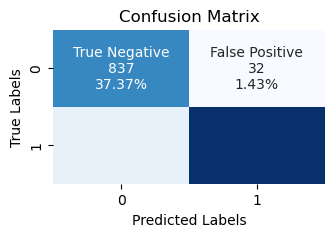




Confusion matrix

 [[ 837   32]
 [ 129 1242]]

True Negatives  (TN) =  837
False Positives (FP) =  32
False Negatives (FN) =  129
True Positives  (TP) =  1242


Accuracy:        0.928125
Sensitivity:     0.9059080962800875
Specificity:     0.9631760644418872
Geometric Mean:  0.9341033106252739


Precision:        0.9328200872441665
Recall:           0.928125
f1-score:         0.9287067586778818

------------------------------------------------

Current Time: 2024-05-15 20:30:25
The entire notebook runtime so far is 11 minutes


In [131]:
# Create an instance of the model
clf = GradientBoostingClassifier(random_state=42)

default_params = clf.get_params()
print(f"Training model with default hyperparameters of: {default_params}")

# Fit the model to the training data
clf.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = clf.score(X_test, y_test)
print("Accuracy:", accuracy)

# save accuracy for later comparison
accuracy_gb_unoptimized = accuracy

# call previously defined function to create confusion matrix
cm = visualize_confusion_matrix(y_test, y_pred)

# show a running total of elapsed time for the entire notebook
show_elapsed_time()

### optimized params
GB

Performing grid_search to find optimal parameters
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'random_state': 42}
Best Scores: 0.9328788736259025
Fitting the model with these parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'random_state': 42}
Cross validation scores: [0.95321637 0.92982456 0.92668622 0.93255132 0.94134897 0.93841642
 0.93255132 0.92961877 0.91202346 0.93255132]
Mean cross validation score: 0.9328788736259025
Standard Deviation cross validation score: 0.010047871476908358
Accuracy: 0.928125


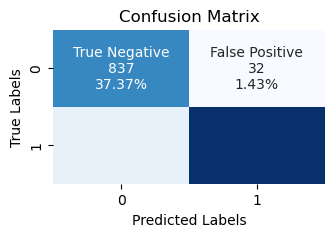




Confusion matrix

 [[ 837   32]
 [ 129 1242]]

True Negatives  (TN) =  837
False Positives (FP) =  32
False Negatives (FN) =  129
True Positives  (TP) =  1242


Accuracy:        0.928125
Sensitivity:     0.9059080962800875
Specificity:     0.9631760644418872
Geometric Mean:  0.9341033106252739


Precision:        0.9328200872441665
Recall:           0.928125
f1-score:         0.9287067586778818

------------------------------------------------

Current Time: 2024-05-15 20:31:11
The entire notebook runtime so far is 12 minutes


In [132]:
# Create an instance of the model
clf = GradientBoostingClassifier()

#default_params = clf.get_params()
#print(f"Training model with default hyperparameters of: {default_params}")

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [100],               #10,200 reduced accuracy
    'learning_rate': [0.1, 1.0],
    'max_depth': [3],                    #add higher numbers reduces accuracy
    'random_state': [42]                 #for reproducible results
}

# Create an instance of GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=cv_count, n_jobs=-1, verbose=verbosity)

# Fit the grid search to the training data
print(f"Performing grid_search to find optimal parameters")
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_scores = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Scores:", best_scores)

# Create a new instance of the model with the best hyperparameters
print(f"Fitting the model with these parameters: {best_params}")
clf = GradientBoostingClassifier(**best_params)

# Fit the model to the training data
clf.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# final cross validation
cross_val_score_result = cross_val_score(clf, X_train, y_train, cv=cv_count)
print(f"Cross validation scores: {cross_val_score_result}")
print(f"Mean cross validation score: {cross_val_score_result.mean()}")
print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")
gb_crossval_score_all  = cross_val_score_result         #save all folds in a list for later comparison
gb_crossval_score_mean = cross_val_score_result.mean()  #save mean   crossval score in a variable for later comparison
gb_crossval_score_std  = cross_val_score_result.std()   #save stddev crossval score in a variable for later comparison

# Evaluate the model
Accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", Accuracy)

# save best parameters for later comparison
best_params_gb = best_params

# call previously defined function to create confusion matrix
cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# save results calculated for this model for later comparison to other models
accuracy_gb_optimized      = Accuracy
sensitivity_gb_optimized   = Sensitivity
specificity_gb_optimized   = Specificity
geometricmean_gb_optimized = GeometricMean
precision_gb_optimized     = Precision
recall_gb_optimized        = Recall
f1_gb_optimized            = F1

# show a running total of elapsed time for the entire notebook
show_elapsed_time()

# Compare accuracy of LR, NB, KNN, SVM, DT, GB, RF

In [133]:
# this section compares the accuracy of different methods:

from tabulate import tabulate
# Define headers for the table
headers = ["Model", "Accuracy Un-optimized", "Accuracy Optimized"]
# Define data for the trable
data = [
    ["LR",  accuracy_lr_unoptimized,   accuracy_lr_optimized],
    ["NB",  accuracy_nb_unoptimized,   accuracy_nb_optimized],
    ["KNN", accuracy_knn_unoptimized,  accuracy_knn_optimized],
    ["SVM", accuracy_svm_unoptimized,  accuracy_svm_optimized],
    ["DT",  accuracy_dt_unoptimized,   accuracy_dt_optimized],
    ["RF",  accuracy_rf_unoptimized,   accuracy_rf_optimized],
    ["GB",  accuracy_gb_unoptimized,   accuracy_gb_optimized]
]

# Round all floats in the data list to 4 decimal places
data_rounded = [[elem if isinstance(elem, str) else round(elem, 4) for elem in row] for row in data]

# Generate the table
table = tabulate(data_rounded, headers=headers, tablefmt="fancy_grid")

# Print the table
print(table)


# sanity checks to confirm that hyperparameter optimization did not make things worse instead of better
if accuracy_lr_unoptimized  > accuracy_lr_optimized:  print("WARNING: LR optimization made the accuracy worse, please tweak hyperparameters")
if accuracy_nb_unoptimized  > accuracy_nb_optimized:  print("WARNING: NB optimization made the accuracy worse, please tweak hyperparameters")
if accuracy_knn_unoptimized > accuracy_knn_optimized: print("WARNING: KNN optimization made the accuracy worse, please tweak hyperparameters")
if accuracy_svm_unoptimized > accuracy_svm_optimized: print("WARNING: SVM optimization made the accuracy worse, please tweak hyperparameters")
if accuracy_dt_unoptimized  > accuracy_dt_optimized:  print("WARNING: DT optimization made the accuracy worse, please tweak hyperparameters")
if accuracy_rf_unoptimized  > accuracy_rf_optimized:  print("WARNING: RF optimization made the accuracy worse, please tweak hyperparameters")
if accuracy_gb_unoptimized  > accuracy_gb_optimized:  print("WARNING: GB optimization made the accuracy worse, please tweak hyperparameters")


╒═════════╤═════════════════════════╤══════════════════════╕
│ Model   │   Accuracy Un-optimized │   Accuracy Optimized │
╞═════════╪═════════════════════════╪══════════════════════╡
│ LR      │                  0.767  │               0.767  │
├─────────┼─────────────────────────┼──────────────────────┤
│ NB      │                  0.746  │               0.746  │
├─────────┼─────────────────────────┼──────────────────────┤
│ KNN     │                  0.8129 │               0.8112 │
├─────────┼─────────────────────────┼──────────────────────┤
│ SVM     │                  0.8107 │               0.8107 │
├─────────┼─────────────────────────┼──────────────────────┤
│ DT      │                  0.9201 │               0.9174 │
├─────────┼─────────────────────────┼──────────────────────┤
│ RF      │                  0.929  │               0.9317 │
├─────────┼─────────────────────────┼──────────────────────┤
│ GB      │                  0.9281 │               0.9281 │
╘═════════╧═════════════

# Model training with Deep Learning classifiers

## MLP Multi-Layer Perceptron

MLPClassifier is a class in scikit-learn that represents a Multi-layer Perceptron (MLP) classifier, which is a type of artificial neural network.

An MLP is a feedforward neural network that consists of multiple layers of nodes (neurons) and can learn complex patterns and relationships in data.

The MLPClassifier is specifically designed for classification tasks.

Example of all hyperparameters:
- hidden_layer_sizes=(100, 50),  # Architecture of hidden layers
- activation='relu',             # Activation function ('relu' is common)
- solver='adam',                 # Optimization solver
- alpha=0.0001,                  # L2 penalty (regularization)
- batch_size='auto',             # Size of mini-batches ('auto' is adaptive)
- learning_rate='constant',      # Learning rate schedule
- learning_rate_init=0.001,      # Initial learning rate
- max_iter=500,                  # Maximum number of iterations
- shuffle=True,                  # Shuffle data in each iteration
- random_state=42,               # Random seed for reproducibility
- verbose=True                   # Print progress during training


Multi-Layer Perceptron (MLP) classifier with three or more hidden layers is typically considered a deep learning model. The term "deep" in deep learning refers to the presence of multiple layers in the neural network architecture. While there's no strict definition of how many layers constitute a "deep" network, models with three or more hidden layers are commonly regarded as deep neural networks.

MLP classifiers, being feedforward neural networks (FNN) with multiple layers, can learn complex patterns and representations from data, making them suitable for various classification tasks. The depth of the network allows it to learn hierarchical features and capture intricate relationships within the data, leading to improved performance on tasks with large and complex datasets.

https://en.wikipedia.org/wiki/Feedforward_neural_network
A feedforward neural network (FNN) is one of the two broad types of artificial neural network, characterized by direction of the flow of information between its layers.[2] Its flow is uni-directional, meaning that the information in the model flows in only one direction—forward—from the input nodes, through the hidden nodes (if any) and to the output nodes, without any cycles or loops,[2] in contrast to recurrent neural networks,[3] which have a bi-directional flow. Modern feedforward networks are trained using the backpropagation method[4][5][6][7][8] and are colloquially referred to as the "vanilla" neural networks.[9]







In [134]:
# Sanity check to confirm X_train and y_train have equal number of samples
print(f"X_train has ", len(X_train), "samples")
print(f"y_train has ", len(y_train), "samples")
if ( len(X_train) != len(y_train) ):
  raise ValueError ("X_train and y_train are different lengths, please investigate!")


X_train has  3412 samples
y_train has  3412 samples


### default params
MLP


Training model with default hyperparameters of: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
-----------------------------------------
Training Accuracy: 0.8599062133645955
Test Accuracy: 0.8415178571428571
Validation Accuracy: 0.8326639892904953
-----------------------------------------


C:\Users\njeffrey\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



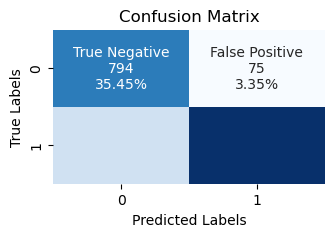




Confusion matrix

 [[ 794   75]
 [ 280 1091]]

True Negatives  (TN) =  794
False Positives (FP) =  75
False Negatives (FN) =  280
True Positives  (TP) =  1091


Accuracy:        0.8415178571428571
Sensitivity:     0.7957695113056164
Specificity:     0.9136939010356732
Geometric Mean:  0.8526955782165636


Precision:        0.8594906066207254
Recall:           0.8415178571428571
f1-score:         0.8434753373402805

------------------------------------------------

Current Time: 2024-05-15 20:31:48
The entire notebook runtime so far is 12 minutes


In [135]:
# Create an instance of the model
clf = MLPClassifier(random_state=42)   #hidden_layer_sizes can be added here as tuples, see hyperparameter cell for an example

default_params = clf.get_params()
print(f"Training model with default hyperparameters of: {default_params}")

# Fit the model to the training data
clf.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# Evaluate the model on training data
print(f"-----------------------------------------")
train_accuracy = clf.score(X_train, y_train)
print("Training Accuracy:", train_accuracy)

# Evaluate the model on test data
test_accuracy = clf.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

# Evaluate the model on val data
val_accuracy = clf.score(X_val, y_val)
print("Validation Accuracy:", val_accuracy)
print(f"-----------------------------------------")

# save results calculated for this model for later comparison to other models
test_accuracy_mlp_unoptimized  = test_accuracy
train_accuracy_mlp_unoptimized = train_accuracy
val_accuracy_mlp_unoptimized   = val_accuracy

# save accuracy for later comparison
accuracy_mlp_unoptimized = accuracy

# call previously defined function to create confusion matrix
cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# save results calculated for this model for later comparison to other models
accuracy_mlp_unoptimized      = Accuracy
sensitivity_mlp_unoptimized   = Sensitivity
specificity_mlp_unoptimized   = Specificity
geometricmean_mlp_unoptimized = GeometricMean
precision_mlp_unoptimized     = Precision
recall_mlp_unoptimized        = Recall
f1_mlp_unoptimized            = F1

# show a running total of elapsed time for the entire notebook
show_elapsed_time()

### optimized params
MLP

Performing grid_search to find optimal parameters
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Best Parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 500, 'random_state': 42}
Best Scores: 0.835573047966936
Fitting the model with best_params {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 500, 'random_state': 42}


C:\Users\njeffrey\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

C:\Users\njeffrey\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.



Cross validation scores: [0.85964912 0.83625731 0.84457478 0.85337243 0.84750733 0.81818182
 0.83577713 0.83870968 0.79765396 0.82404692]
Mean cross validation score: 0.835573047966936
Standard Deviation cross validation score: 0.017330452746722153
-----------------------------------------
Training Accuracy: 0.861664712778429
Test Accuracy: 0.8410714285714286
Validation Accuracy: 0.8286479250334672
-----------------------------------------


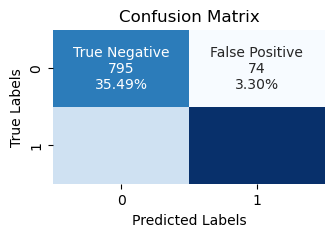




Confusion matrix

 [[ 795   74]
 [ 282 1089]]

True Negatives  (TN) =  795
False Positives (FP) =  74
False Negatives (FN) =  282
True Positives  (TP) =  1089


Accuracy:        0.8410714285714286
Sensitivity:     0.7943107221006565
Specificity:     0.9148446490218642
Geometric Mean:  0.8524499479585171


Precision:        0.8594766329446294
Recall:           0.8410714285714286
f1-score:         0.8430423222590041

------------------------------------------------

Current Time: 2024-05-15 20:33:00
The entire notebook runtime so far is 14 minutes


In [136]:

# Create an instance of the model
clf = MLPClassifier()

# Define the hyperparameters to tune
param_grid = {
    'hidden_layer_sizes': [(100,)],  #also tried (64,32)), (64,32,16), (128,64,32) as tuples for hidden layers, but default (100,) was best
    'max_iter': [200, 300, 500],                   # also tried 100, 300, 500
    'alpha': [0.0001],                        #also tried 0.001, 0.01
    'activation': ['relu'],                   #also tried tanh
    'learning_rate': ['constant'],            #also tried adaptive
    'random_state': [42]                      #for reproducible results
}



# Create an instance of GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=cv_count, n_jobs=-1, verbose=verbosity)

# Fit the grid search to the training data
print(f"Performing grid_search to find optimal parameters")
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_scores = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Scores:", best_scores)

# Create a new instance of the model with the best hyperparameters
clf = MLPClassifier(**best_params)

# Fit the model to the training data
print(f"Fitting the model with best_params {best_params}")
clf.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# final cross validation
cross_val_score_result = cross_val_score(clf, X_train, y_train, cv=cv_count)
print(f"Cross validation scores: {cross_val_score_result}")
print(f"Mean cross validation score: {cross_val_score_result.mean()}")
print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")
mlp_crossval_score_all  = cross_val_score_result         #save all folds in a list for later comparison
mlp_crossval_score_mean = cross_val_score_result.mean()  #save mean   crossval score in a variable for later comparison
mlp_crossval_score_std  = cross_val_score_result.std()   #save stddev crossval score in a variable for later comparison

# Evaluate the model on training data
print(f"-----------------------------------------")
train_accuracy = clf.score(X_train, y_train)
print("Training Accuracy:", train_accuracy)

# Evaluate the model on test data
test_accuracy = clf.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

# Evaluate the model on val data
val_accuracy = clf.score(X_val, y_val)
print("Validation Accuracy:", val_accuracy)
print(f"-----------------------------------------")

# save results calculated for this model for later comparison to other models
test_accuracy_mlp_optimized  = test_accuracy
train_accuracy_mlp_optimized = train_accuracy
val_accuracy_mlp_optimized   = val_accuracy


# save best parameters for later comparison
best_params_mlp = best_params

# call previously defined function to create confusion matrix
cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# save results calculated for this model for later comparison to other models
accuracy_mlp_optimized      = Accuracy
sensitivity_mlp_optimized   = Sensitivity
specificity_mlp_optimized   = Specificity
geometricmean_mlp_optimized = GeometricMean
precision_mlp_optimized     = Precision
recall_mlp_optimized        = Recall
f1_mlp_optimized            = F1

# show a running total of elapsed time for the entire notebook
show_elapsed_time()

## Sequential FNN
(does not require time steps)



In the context of the Keras library, Sequential() is not a classifier itself, but rather a type of model architecture. It is used to create sequential models, which are a linear stack of layers.

These models are typically used for building feedforward neural networks (FNNs), where the data flows sequentially from the input layer through one or more hidden layers to the output layer. Each layer in a sequential model has connections only to the layers that follow it in the model.

You can use different types of layers such as Dense, Dropout, Conv1D, Conv2D, LSTM, etc., in a Sequential() model depending on the type of problem you are solving. Once the layers are added to the model, you compile it with an optimizer, a loss function, and optionally, performance metrics. After compilation, you can train the model on your data using the fit() method.

In [137]:
# row, columns in X_train
print("rows,columns in X_train")
print(X_train.shape)

rows,columns in X_train
(3412, 25)


In [138]:
# sanity check
print(X_train)

[[-0.10202183  0.51444708  0.35603951 ... -0.32587364 -1.06928188
   0.00993313]
 [-0.76289995 -0.76323361  0.15700824 ... -0.33323218  0.61187198
  -1.15593913]
 [-0.24970758  1.48513851 -0.70761866 ... -0.33390548 -1.61318459
   0.00993313]
 ...
 [-0.61384979 -0.89294739 -0.71597254 ...  2.3654184   0.85910049
   1.17580538]
 [-0.51333123 -0.6551388  -0.00589248 ... -0.10280044  0.85910049
   1.17580538]
 [ 0.83857723  1.46135765 -0.67253235 ... -0.33109363 -1.21761898
   0.00993313]]


In [139]:
# Sanity check to confirm X_train and y_train have equal number of samples
print(f"X_train has ", len(X_train), "samples")
print(f"y_train has ", len(y_train), "samples")
if ( len(X_train) != len(y_train) ):
  raise ValueError ("X_train and y_train are different lengths, please investigate!")


X_train has  3412 samples
y_train has  3412 samples


### default params

In [140]:
# row, columns in X_train
print(X_train.shape)

(3412, 25)


-----------------------------------------
Model Summary
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1664      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,777
Trainable params: 3,777
Non-trainable params: 0
_________________________________________________________________
None
-----------------------------------------
Training the model
Epoch 1/25
107/107 [==============================] - 1s 4ms/ste

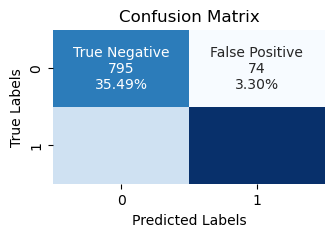




Confusion matrix

 [[ 795   74]
 [ 282 1089]]

True Negatives  (TN) =  795
False Positives (FP) =  74
False Negatives (FN) =  282
True Positives  (TP) =  1089


Accuracy:        0.8410714285714286
Sensitivity:     0.7943107221006565
Specificity:     0.9148446490218642
Geometric Mean:  0.8524499479585171


Precision:        0.8594766329446294
Recall:           0.8410714285714286
f1-score:         0.8430423222590041

------------------------------------------------

Current Time: 2024-05-15 20:33:58
The entire notebook runtime so far is 15 minutes


In [141]:
# Sequential (prior to optimization) 


# Define input shape based on the features in X_train
input_shape = X_train.shape[1]


# Define the model
model = Sequential([                                           #Initializes a sequential neural network model
    Dense(64, activation='relu', input_shape=(input_shape,)),  #Add a fully connected layer (also known as a dense layer) with 64 neurons
    Dropout(0.5),                                              #Optional dropout layer for regularization to randomly sets a fraction of input units to zero during training to prevent overfitting
    Dense(32, activation='tanh'),                              #Adds another fully connected layer with 32 neurons and RtanheLU activation function.
    Dense(1, activation='sigmoid')                             # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print model summary
print(f"-----------------------------------------")
print(f"Model Summary")
print(model.summary())

# Train the model
print(f"-----------------------------------------")
print(f"Training the model")
history = model.fit(X_train, y_train, epochs=epoch_count, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on training data
print(f"-----------------------------------------")
print(f"Evaluating the model on training data")
train_loss, train_accuracy = model.evaluate(X_train, y_train)
print("Training Loss:", train_loss)
print("Training Accuracy:", train_accuracy)


# Evaluate the model on test data
print(f"-----------------------------------------")
print(f"Evaluating the model on test data")
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


# save results calculated for this model for later comparison to other models
test_accuracy_sequential_unoptimized  = test_accuracy
test_loss_sequential_unoptimized      = test_loss
train_accuracy_sequential_unoptimized = train_accuracy
train_loss_sequential_unoptimized     = train_loss

# call previously defined function to create confusion matrix
cm = visualize_confusion_matrix(y_test, y_pred)

# show a running total of elapsed time for the entire notebook
show_elapsed_time()

In [142]:
# show a running total of elapsed time for the entire notebook
show_elapsed_time()

Current Time: 2024-05-15 20:34:18
The entire notebook runtime so far is 15 minutes


### optimized params
FNN

In [ ]:
# # to-do: add another dropout after dense(32), and another dense layer with 16 neurons

# # Sequential (prior to optimization) -- Backup

# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout

# # Define input shape based on the features in X_train
# input_shape = X_train.shape[1]

# # Define the model
# model = Sequential([                                           #Initializes a sequential neural network model
#     Dense(64, activation='relu', input_shape=(input_shape,)),  #Add a fully connected layer (also known as a dense layer) with 64 neurons
#     Dropout(0.5),                                              #Optional dropout layer for regularization to randomly sets a fraction of input units to zero during training to prevent overfitting
#     Dense(32, activation='relu'),                              #Adds another fully connected layer with 32 neurons and ReLU activation function.
#     Dense(1, activation='sigmoid')                             # Output layer with sigmoid activation for binary classification
# ])

# # Compile the model
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# # Print model summary
# print(f"-----------------------------------------")
# print(f"Model Summary")
# print(model.summary())

# # Train the model
# print(f"-----------------------------------------")
# print(f"Training the model")
# history = model.fit(X_train, y_train, epochs=epoch_count, batch_size=32, validation_split=0.2)

# # Evaluate the model on training data
# print(f"-----------------------------------------")
# print(f"Evaluating the model on training data")
# train_loss, train_accuracy = model.evaluate(X_train, y_train)
# print("Training Loss:", train_loss)
# print("Training Accuracy:", train_accuracy)


# # Evaluate the model on test data
# print(f"-----------------------------------------")
# print(f"Evaluating the model on test data")
# test_loss, test_accuracy = model.evaluate(X_test, y_test)
# print("Test Loss:", test_loss)
# print("Test Accuracy:", test_accuracy)


# # Evaluate the model on validation data
# print(f"-----------------------------------------")
# print(f"Evaluating the model on validation data")
# val_loss, val_accuracy = model.evaluate(X_val, y_val)
# print("Val Loss:", val_loss)
# print("Val Accuracy:", val_accuracy)
# print(f"-----------------------------------------")


# # save results calculated for this model for later comparison to other models
# test_accuracy_sequential_unoptimized  = test_accuracy
# test_loss_sequential_unoptimized      = test_loss
# train_accuracy_sequential_unoptimized = train_accuracy
# train_loss_sequential_unoptimized     = train_loss
# val_accuracy_sequential_unoptimized   = val_accuracy
# val_loss_sequential_unoptimized       = val_loss

# # Extracting accuracy and loss history from the training, will be used later for graphing convergence
# train_loss_history_unoptimized     = history.history['loss']
# train_accuracy_history_unoptimized = history.history['accuracy']
# val_loss_history_unoptimized       = history.history['val_loss']
# val_accuracy_history_unoptimized   = history.history['val_accuracy']

# # call previously defined function to create confusion matrix
# cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# # save results calculated for this model for later comparison to other models
# accuracy_sequential_unoptimized      = Accuracy
# sensitivity_sequential_unoptimized   = Sensitivity
# specificity_sequential_unoptimized   = Specificity
# geometricmean_sequential_unoptimized = GeometricMean
# precision_sequential_unoptimized     = Precision
# recall_sequential_unoptimized        = Recall
# f1_sequential_unoptimized            = F1

# # show a running total of elapsed time for the entire notebook
# show_elapsed_time()

In [ ]:
# Sanity check to confirm X_train and y_train have equal number of samples
print(f"X_train has ", len(X_train), "samples")
print(f"y_train has ", len(y_train), "samples")
if ( len(X_train) != len(y_train) ):
  raise ValueError ("X_train and y_train are different lengths, please investigate!")


In [ ]:
# # perform Sequential hyperparameter optimization

# # Define a function to create a model
# def create_model(units=64, dropout=0.5):
#     model = Sequential([
#         Dense(units, activation='relu', input_shape=(input_shape,)),
#         Dropout(dropout),
#         Dense(32, activation='relu'),
#         Dense(1, activation='sigmoid')
#     ])
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# # Define input shape based on the features in X_train
# input_shape = X_train.shape[1]

# # Create a wrapper class around the Keras model
# class KerasClassifierWrapper:
#     def __init__(self, units=64, dropout=0.5, epochs=epoch_count, batch_size=32, verbose=0):
#         self.units = units
#         self.dropout = dropout
#         self.epochs = epochs
#         self.batch_size = batch_size
#         self.verbose = verbose
#         self.model = None

#     def fit(self, X, y):
#         self.model = create_model(units=self.units, dropout=self.dropout)
#         self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)

#     def predict(self, X):
#         return (self.model.predict(X) > 0.5).astype(int)

#     def get_params(self, deep=True):
#         return {
#             'units': self.units,
#             'dropout': self.dropout,
#             'epochs': self.epochs,
#             'batch_size': self.batch_size,
#             'verbose': self.verbose
#         }

#     def set_params(self, **params):
#         for param, value in params.items():
#             setattr(self, param, value)
#         return self

# # Create an instance of the wrapper class
# model = KerasClassifierWrapper()

# # Define the hyperparameters grid to search
# param_grid = {
#     'units': [32],      #also tried 64,128
#     'dropout': [0.3],   #also tried 0.5, 0.7
#     'activation': ['tanh'] # relu almost as good as tanh ,also tried sigmoid and linear, but accuracy was lower
# }
# #param_grid = {           #smaller faster version for debugging
# #    'units': [32],
# #    'dropout': [0.3]
# #}

# # Create GridSearchCV instance
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_count, scoring=make_scorer(accuracy_score), verbose=verbosity)

# # Perform grid search
# print(f"--------------------------------------------------")
# print(f"Performing GridSearchCV to find optimal parameters")
# grid_search_result = grid_search.fit(X_train, y_train)

# # Print best parameters and results
# print("Best Parameters:", grid_search_result.best_params_)
# print("Best Accuracy:", grid_search_result.best_score_)
# print('\n')

# # final cross validation
# cross_val_score_result = cross_val_score(clf, X_train, y_train, cv=cv_count)
# print(f"-----------------------------------------")
# print(f"Cross validation scores: {cross_val_score_result}")
# print(f"Mean cross validation score: {cross_val_score_result.mean()}")
# print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")
# sequential_crossval_score_all  = cross_val_score_result         #save all folds in a list for later comparison
# sequential_crossval_score_mean = cross_val_score_result.mean()  #save mean   crossval score in a variable for later comparison
# sequential_crossval_score_std  = cross_val_score_result.std()   #save stddev crossval score in a variable for later comparison

# # Evaluate the best model on training data
# print(f"-----------------------------------------")
# print(f"Evaluating the model on training data")
# best_model = grid_search_result.best_estimator_
# train_loss, train_accuracy = best_model.model.evaluate(X_train, y_train)
# print("Train Loss:", train_loss)
# print("Train Accuracy:", train_accuracy)


# # Evaluate the best model on test data
# print(f"-----------------------------------------")
# print(f"Evaluating the model on test data")
# best_model = grid_search_result.best_estimator_
# test_loss, test_accuracy = best_model.model.evaluate(X_test, y_test)
# print("Test Loss:", test_loss)
# print("Test Accuracy:", test_accuracy)

# # Evaluate the best model on validation data
# print(f"-----------------------------------------")
# print(f"Evaluating the model on validation data")
# best_model = grid_search_result.best_estimator_
# val_loss, val_accuracy = best_model.model.evaluate(X_val, y_val)
# print("Val Loss:", val_loss)
# print("Val Accuracy:", val_accuracy)
# print(f"-----------------------------------------")


# # save results calculated for this model for later comparison to other models
# test_accuracy_sequential_optimized  = test_accuracy
# test_loss_sequential_optimized      = test_loss
# train_accuracy_sequential_optimized = train_accuracy
# train_loss_sequential_optimized     = train_loss
# val_accuracy_sequential_optimized   = val_accuracy
# val_loss_sequential_optimized       = val_loss

# # Extracting accuracy and loss history from the training, will be used later for graphing convergence
# train_loss_history_optimized     = history.history['loss']
# train_accuracy_history_optimized = history.history['accuracy']
# val_loss_history_optimized       = history.history['val_loss']
# val_accuracy_history_optimized   = history.history['val_accuracy']

# # call previously defined function to create confusion matrix
# cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# # save results calculated for this model for later comparison to other models
# accuracy_sequential_optimized      = Accuracy
# sensitivity_sequential_optimized   = Sensitivity
# specificity_sequential_optimized   = Specificity
# geometricmean_sequential_optimized = GeometricMean
# precision_sequential_optimized     = Precision
# recall_sequential_optimized        = Recall
# f1_sequential_optimized            = F1

# # show a running total of elapsed time for the entire notebook
# show_elapsed_time()

In [ ]:
# Call previously defined functions to create graphs that show how Training/Validation loss and accuracy converge
# It is important that the lines converge, if they do not, add more data, more epochs, or try different hyperparameter optimizations

# print current history values, use end=" " to print all output on single line
print(f"\n\ntrain_loss_history_unoptimized", end=" ") 
for value in train_loss_history_unoptimized: print(f"{value:.4f}", end=" ")
#
print(f"\n\ntrain_loss_history_optimized", end=" ") 
for value in train_loss_history_optimized: print(f"{value:.4f}", end=" ")
#
print(f"\n\nval_loss_history_unoptimized", end=" ") 
for value in val_loss_history_unoptimized: print(f"{value:.4f}", end=" ")
#
print(f"\n\nval_loss_history_optimized", end=" ") 
for value in val_loss_history_optimized: print(f"{value:.4f}", end=" ")


# sanity check to confirm the required values have already been collected, set to zeros if needed to avoid undef errors
if len(train_loss_history_unoptimized) != epoch_count: print("ERROR: incorrect len() of train_loss_history_unoptimized, resetting to all zeros") ; train_loss_history_unoptimized = [0] * epoch_count
if len(train_loss_history_optimized)   != epoch_count: print("ERROR: incorrect len() of train_loss_history_optimized,   resetting to all zeros") ; train_loss_history_optimized   = [0] * epoch_count
if len(val_loss_history_unoptimized)   != epoch_count: print("ERROR: incorrect len() of val_loss_history_unoptimized,   resetting to all zeros") ; val_loss_history_unoptimized   = [0] * epoch_count
if len(val_loss_history_optimized)     != epoch_count: print("ERROR: incorrect len() of  val_loss_history_optimized,    resetting to all zeros") ; val_loss_history_optimized     = [0] * epoch_count

# create the convergence graphs
plot_loss_history(train_loss_history_unoptimized, train_loss_history_optimized, val_loss_history_unoptimized, val_loss_history_optimized, epoch_count)
plot_accuracy_history(train_accuracy_history_unoptimized, train_accuracy_history_optimized, val_accuracy_history_unoptimized, val_accuracy_history_optimized, epoch_count)

In [ ]:
# show a running total of elapsed time for the entire notebook
show_elapsed_time()

## Sequential FNN + LSTM

### default params

In [ ]:
# It’s important to note that LSTM models can be computationally expensive to train.
# Depending on the size of your data and complexity of your model, training may take a significant amount of time.

# NOTE: training the model with model.fit()  is ~10x faster when using a GPU!!

In [ ]:
# # FNN-LSTM


# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout

# # Define input shape based on the features in X_train
# input_shape = X_train.shape[1]

# # Define the model
# model = Sequential([
#     LSTM(64, activation='relu', input_shape=(input_shape, 1), return_sequences=True),
#     Dropout(0.5),  # Optional dropout layer for regularization
#     LSTM(32, activation='relu'),
#     Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
# ])

# # Compile the model
# print(f"-----------------------------------------")
# print(f"Compiling model")
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# # Print model summary
# print(f"-----------------------------------------")
# print(f"Model Summary")
# print(model.summary())

# # Train the model
# print(f"-----------------------------------------")
# print(f"Training the model")
# history = model.fit(X_train, y_train, epochs=epoch_count, batch_size=32, validation_split=0.2)

# # Evaluate the model on training data
# print(f"-----------------------------------------")
# print(f"Evaluating the model on training data")
# train_loss, train_accuracy = model.evaluate(X_train, y_train)
# print("Training Loss:", train_loss)
# print("Training Accuracy:", train_accuracy)


# # Evaluate the model on test data
# # Now that we have trained our LSTM model, it’s time to evaluate its performance.
# # In TensorFlow, we can do this by using the `evaluate()` method of the model object.
# #
# # First, we need to load the test data and preprocess it in the same way as we did for the training data.
# # Once we have preprocessed the test data, we can evaluate the model using the `evaluate()` method.
# # This method takes two arguments: the test data (X_test) and its corresponding labels (y_test).
# # Evaluate the model on test data


# # Evaluate the model on test data
# print(f"-----------------------------------------")
# print(f"Evaluating the model on test data")
# test_loss, test_accuracy = model.evaluate(X_test, y_test)
# print("Test Loss:", test_loss)
# print("Test Accuracy:", test_accuracy)


# # Evaluate the model on validation data
# print(f"-----------------------------------------")
# print(f"Evaluating the model on validation data")
# val_loss, val_accuracy = model.evaluate(X_val, y_val)
# print("Val Loss:", val_loss)
# print("Val Accuracy:", val_accuracy)
# print(f"-----------------------------------------")

# #
# # The `evaluate()` method returns two values: the loss and accuracy of the model on the test data.
# # The loss is a measure of how well the model is able to predict the correct output, while the accuracy is a measure of how often the model is correct.
# #
# # It’s important to note that we should only use the test data for evaluation purposes and not for training.
# # Using the same data for both training and evaluation can lead to overfitting, where the model performs well on the training data but poorly on new, unseen data.
# #
# # In addition to evaluating the overall performance of our model, we can also look at individual predictions using the `predict()` method.
# # This method takes a single input example and returns its predicted output.
# #
# ## Make a prediction on a single input example
# #example = ...
# #prediction = model.predict(preprocess_data(example))
# #
# # By examining individual predictions, we can gain insights into how our model is making decisions and identify areas where it may be making errors.
# # This can help us improve our model and make it more accurate for future predictions.


# # save results calculated for this model for later comparison to other models
# test_accuracy_lstm_unoptimized  = test_accuracy
# test_loss_lstm_unoptimized      = test_loss
# train_accuracy_lstm_unoptimized = train_accuracy
# train_loss_lstm_unoptimized     = train_loss
# val_accuracy_lstm_unoptimized   = val_accuracy
# val_loss_lstm_unoptimized       = val_loss


# # call previously defined function to create confusion matrix
# cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# # save results calculated for this model for later comparison to other models
# accuracy_lstm_unoptimized      = Accuracy
# sensitivity_lstm_unoptimized   = Sensitivity
# specificity_lstm_unoptimized   = Specificity
# geometricmean_lstm_unoptimized = GeometricMean
# precision_lstm_unoptimized     = Precision
# recall_lstm_unoptimized        = Recall
# f1_lstm_unoptimized            = F1

# # show a running total of elapsed time for the entire notebook
# show_elapsed_time()

In [ ]:
# show a running total of elapsed time for the entire notebook
show_elapsed_time()

### optimized params
FNN + LSTM

In [ ]:

# # perform LSTM hyperparameter optimization  (without GPU, takes approx 60 minutes to run with units=32,64,128 dropout=0.3,0.5,0.7)
# # This method is different than Sequential optimization, maybe use the next cell instead for consistency


# import numpy as np
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
# from sklearn.metrics import accuracy_score

# # Define a function to create a model
# def create_model(units=64, dropout=0.5):
#     model = Sequential([
#         LSTM(units, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True),
#         Dropout(dropout),
#         LSTM(units//2, activation='relu'),
#         Dense(1, activation='sigmoid')
#     ])
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# # Define hyperparameters to search
# #units_list = [32, 64, 128]
# #dropout_list = [0.3, 0.5, 0.7]
# units_list = [32]              #use smaller list of parameters to speed up debugging phase
# dropout_list = [0.3]               #use smaller list of parameters to speed up debugging phase


# # initialize variables
# best_accuracy = 0
# best_params = {}

# # Loop through all combinations of hyperparameters
# print(f"\nLooping through all combinations of hyperparameters")
# for units in units_list:
#     for dropout in dropout_list:
#         print(f"Evaluating model with units={units}, dropout={dropout}")

#         # Create and compile the model
#         model = create_model(units=units, dropout=dropout)

#         # Train the model
#         history = model.fit(X_train, y_train, epochs=epoch_count, batch_size=32, validation_split=0.2, verbose=epoch_verbosity)

#         # Evaluate the model on validation data
#         val_loss, val_accuracy = model.evaluate(X_test, y_test, verbose=0)
#         print(f"Validation Accuracy: {val_accuracy}")

#         # Update best accuracy and parameters if necessary
#         if val_accuracy > best_accuracy:
#             best_accuracy = val_accuracy
#             best_params = {'units': units, 'dropout': dropout}

# # Train the final model with the best parameters
# print(f"\nBest parameters: {best_params}")
# print(f"Training the final model with the best parameters...")
# model = create_model(**best_params)
# history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, verbose=0)

# # final cross validation
# cross_val_score_result = cross_val_score(clf, X_train, y_train, cv=cv_count)
# print(f"-----------------------------------------")
# print(f"Cross validation scores: {cross_val_score_result}")
# print(f"Mean cross validation score: {cross_val_score_result.mean()}")
# print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")
# lstm_crossval_score_all  = cross_val_score_result         #save all folds in a list for later comparison
# lstm_crossval_score_mean = cross_val_score_result.mean()  #save mean   crossval score in a variable for later comparison
# lstm_crossval_score_std  = cross_val_score_result.std()   #save stddev crossval score in a variable for later comparison

# # Evaluate the best model on training data
# print(f"-----------------------------------------")
# print(f"Evaluating the model on training data")
# train_loss, train_accuracy = model.evaluate(X_train, y_train)
# print("Training Loss:", train_loss)
# print("Training Accuracy:", train_accuracy)


# # Evaluate the best model on test data
# print(f"-----------------------------------------")
# print(f"\nEvaluating the model on test data")
# test_loss, test_accuracy = model.evaluate(X_test, y_test)
# print("Test Loss:", test_loss)
# print("Test Accuracy:", test_accuracy)


# # Evaluate the best model on validation data
# print(f"-----------------------------------------")
# print(f"\nEvaluating the model on validation data")
# val_loss, val_accuracy = model.evaluate(X_val, y_val)
# print("Val Loss:", val_loss)
# print("Val Accuracy:", val_accuracy)
# print(f"-----------------------------------------")


# # save results calculated for this model for later comparison to other models
# test_accuracy_lstm_optimized  = test_accuracy
# test_loss_lstm_optimized      = test_loss
# train_accuracy_lstm_optimized = train_accuracy
# train_loss_lstm_optimized     = train_loss
# val_accuracy_lstm_optimized   = val_accuracy
# val_loss_lstm_optimized       = val_loss

# # call previously defined function to create confusion matrix
# cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# # save results calculated for this model for later comparison to other models
# accuracy_lstm_optimized      = Accuracy
# sensitivity_lstm_optimized   = Sensitivity
# specificity_lstm_optimized   = Specificity
# geometricmean_lstm_optimized = GeometricMean
# precision_lstm_optimized     = Precision
# recall_lstm_optimized        = Recall
# f1_lstm_unoptimized            = F1

# # show a running total of elapsed time for the entire notebook
# show_elapsed_time()

In [ ]:
# Call previously defined functions to create graphs that show how Training/Validation loss and accuracy converge
# It is important that the lines converge, if they do not, add more data, more epochs, or try different hyperparameter optimizations

# print current history values, use end=" " to print all output on single line
print(f"\n\ntrain_loss_history_unoptimized", end=" ") 
for value in train_loss_history_unoptimized: print(f"{value:.4f}", end=" ")
#
print(f"\n\ntrain_loss_history_optimized", end=" ") 
for value in train_loss_history_optimized: print(f"{value:.4f}", end=" ")
#
print(f"\n\nval_loss_history_unoptimized", end=" ") 
for value in val_loss_history_unoptimized: print(f"{value:.4f}", end=" ")
#
print(f"\n\nval_loss_history_optimized", end=" ") 
for value in val_loss_history_optimized: print(f"{value:.4f}", end=" ")


# sanity check to confirm the required values have already been collected, set to zeros if needed to avoid undef errors
if len(train_loss_history_unoptimized) != epoch_count: print("ERROR: incorrect len() of train_loss_history_unoptimized, resetting to all zeros") ; train_loss_history_unoptimized = [0] * epoch_count
if len(train_loss_history_optimized)   != epoch_count: print("ERROR: incorrect len() of train_loss_history_optimized,   resetting to all zeros") ; train_loss_history_optimized   = [0] * epoch_count
if len(val_loss_history_unoptimized)   != epoch_count: print("ERROR: incorrect len() of val_loss_history_unoptimized,   resetting to all zeros") ; val_loss_history_unoptimized   = [0] * epoch_count
if len(val_loss_history_optimized)     != epoch_count: print("ERROR: incorrect len() of  val_loss_history_optimized,    resetting to all zeros") ; val_loss_history_optimized     = [0] * epoch_count

# create the convergence graphs
plot_loss_history(train_loss_history_unoptimized, train_loss_history_optimized, val_loss_history_unoptimized, val_loss_history_optimized, epoch_count)
plot_accuracy_history(train_accuracy_history_unoptimized, train_accuracy_history_optimized, val_accuracy_history_unoptimized, val_accuracy_history_optimized, epoch_count)

In [ ]:
# show a running total of elapsed time for the entire notebook
show_elapsed_time()

## reshape X_train, X_test to include time steps for SimpleRNN and GRU

The following model expects sequential (ie time-series) data, so the dataset will need  "time steps"  for the SimpleRNN and Gated Recurrent Unit (GRU) models? (which also reshapes X_train,X_test).

If the data does not include time steps, you will get an error about the shape being incorrect.

The error message indicates that the input to the GRU layer has an incorrect shape. The GRU layer expects input data to have three dimensions: (batch size, time steps, features). In this case, the input data only has two dimensions: (batch size, features).

To fix the issue, reshape the input data to have three dimensions. This can be done using the reshape() method.

After reshaping the input data, the model can be trained and evaluated successfully.

In [143]:
# reshape X_train to add time steps (expected by this model)

# Assuming X_train has shape (samples, features)
# Define the number of time steps
time_steps = 1  # Adjust this value based on your data and problem

# Reshape X_train to include time steps
X_train_with_time_steps = np.zeros((X_train.shape[0] - time_steps + 1, time_steps, X_train.shape[1]))
for i in range(len(X_train) - time_steps + 1):
    X_train_with_time_steps[i] = X_train[i:i+time_steps]

# Now X_train_with_time_steps has shape (samples, time_steps, features)


# reshape X_test to add time steps (expected by this model)

# Assuming X_test has shape (samples, features)
# Define the number of time steps
time_steps = 1  # Adjust this value based on your data and problem

# Reshape X_test to include time steps
X_test_with_time_steps = np.zeros((X_test.shape[0] - time_steps + 1, time_steps, X_test.shape[1]))
for i in range(len(X_test) - time_steps + 1):
    X_test_with_time_steps[i] = X_test[i:i+time_steps]

# Reshape X_val to include time steps
X_val_with_time_steps = np.zeros((X_val.shape[0] - time_steps + 1, time_steps, X_val.shape[1]))
for i in range(len(X_val) - time_steps + 1):
    X_val_with_time_steps[i] = X_val[i:i+time_steps]

# Now X_test_with_time_steps has shape (samples, time_steps, features)




## SimpleRNN
(this model needed reshaping to add time steps)

### default params

-----------------------------------------
Model Summary
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                5760      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 7,873
Trainable params: 7,873
Non-trainable params: 0
_________________________________________________________________
None
-----------------------------------------
Training the model
Epoch 1/25
86/86 [==============================] - 1s 5ms/step - loss: 0.4879 - accuracy: 0.7464 - val_loss: 0.4511 - val_accuracy: 0.7555
Epoch 2/25
86/86 [==============================] - 0s

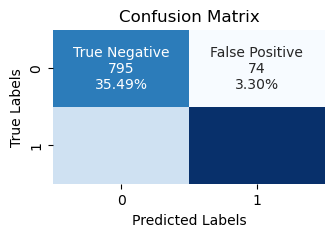




Confusion matrix

 [[ 795   74]
 [ 282 1089]]

True Negatives  (TN) =  795
False Positives (FP) =  74
False Negatives (FN) =  282
True Positives  (TP) =  1089


Accuracy:        0.8410714285714286
Sensitivity:     0.7943107221006565
Specificity:     0.9148446490218642
Geometric Mean:  0.8524499479585171


Precision:        0.8594766329446294
Recall:           0.8410714285714286
f1-score:         0.8430423222590041

------------------------------------------------

Current Time: 2024-05-15 20:37:09
The entire notebook runtime so far is 18 minutes


In [145]:
#import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, SimpleRNN

# Define input shape based on the features in X_train_with_time_steps
input_shape = X_train_with_time_steps.shape[1:]


# Define the model
model = Sequential([
    SimpleRNN(units=64, input_shape=input_shape),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Print model summary
print(f"-----------------------------------------")
print(f"Model Summary")
print(model.summary())


# Train the model
print(f"-----------------------------------------")
print(f"Training the model")
history = model.fit(X_train_with_time_steps, y_train, epochs=epoch_count, batch_size=32, validation_split=0.2)


# Evaluate the model on training data
print(f"-----------------------------------------")
print(f"Evaluating the model on training data")
train_loss, train_accuracy = model.evaluate(X_train_with_time_steps, y_train)
print("Training Loss:", train_loss)
print("Training Accuracy:", train_accuracy)



# Evaluate the model on test data
print(f"-----------------------------------------")
print(f"Evaluating the model on test data")
test_loss, test_accuracy = model.evaluate(X_test_with_time_steps, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


# Evaluate the model on validation data
print(f"-----------------------------------------")
print(f"Evaluating the model on validation data")
val_loss, val_accuracy = model.evaluate(X_val_with_time_steps, y_val)
print("Val Loss:", val_loss)
print("Val Accuracy:", val_accuracy)
print(f"-----------------------------------------")


# save results calculated for this model for later comparison to other models
test_accuracy_simplernn_unoptimized  = test_accuracy
test_loss_simplernn_unoptimized      = test_loss
train_accuracy_simplernn_unoptimized = train_accuracy
train_loss_simplernn_unoptimized     = train_loss
val_accuracy_simplernn_unoptimized   = val_accuracy
val_loss_simplernn_unoptimized       = val_loss

# Extracting accuracy and loss history from the training, will be used later for graphing convergence
train_loss_history_unoptimized     = history.history['loss']
train_accuracy_history_unoptimized = history.history['accuracy']
val_loss_history_unoptimized       = history.history['val_loss']
val_accuracy_history_unoptimized   = history.history['val_accuracy']


# call previously defined function to create confusion matrix
cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# save results calculated for this model for later comparison to other models
accuracy_simplernn_unoptimized      = Accuracy
sensitivity_simplernn_unoptimized   = Sensitivity
specificity_simplernn_unoptimized   = Specificity
geometricmean_simplernn_unoptimized = GeometricMean
precision_simplernn_unoptimized     = Precision
recall_simplernn_unoptimized        = Recall
f1_simplernn_unoptimized            = F1

# show a running total of elapsed time for the entire notebook
show_elapsed_time()

### optimized params
RNN

In [146]:
# Sanity check to confirm X_train and y_train have equal number of samples
print(f"X_train_with_time_steps has ", len(X_train_with_time_steps), "samples")
print(f"y_train                 has ", len(y_train),                 "samples")
if ( len(X_train_with_time_steps) != len(y_train) ):
  raise ValueError ("X_train_with_time_steps and y_train are different lengths, please investigate!")


X_train_with_time_steps has  3412 samples
y_train                 has  3412 samples


### 1 hidden layer

------------------------------------------
Performing GridSearchCV
Total number of combinations in the parameter grid: 1
Total number of cross validation folds: 10
parameter grid x CV folds = 1 x 10 = 10 GridSearchCV cycles
------------------------------------------
Fitting 10 folds for each of 1 candidates, totalling 10 fits
11/11 [==============================] - 0s 1ms/step
[CV] END ..............................dropout=0.3, units=32; total time=   4.4s
11/11 [==============================] - 0s 1ms/step
[CV] END ..............................dropout=0.3, units=32; total time=   4.7s
11/11 [==============================] - 0s 1ms/step
[CV] END ..............................dropout=0.3, units=32; total time=   4.6s
11/11 [==============================] - 0s 1ms/step
[CV] END ..............................dropout=0.3, units=32; total time=   4.5s
11/11 [==============================] - 0s 1ms/step
[CV] END ..............................dropout=0.3, units=32; total time=   4.5s
11

C:\Users\njeffrey\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

C:\Users\njeffrey\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.



-----------------------------------------
Cross validation scores: [0.85964912 0.83625731 0.84457478 0.85337243 0.84750733 0.81818182
 0.83577713 0.83870968 0.79765396 0.82404692]
Mean cross validation score: 0.835573047966936
Standard Deviation cross validation score: 0.017330452746722153
------------------------------------------
Evaluating the model on training data
107/107 [==============================] - 0s 1ms/step - loss: 0.3524 - accuracy: 0.8291
Train Loss: 0.3523695170879364
Train Accuracy: 0.8291324973106384
-----------------------------------------
Evaluating the model on test data
70/70 [==============================] - 0s 1ms/step - loss: 0.3467 - accuracy: 0.8281
Test Loss: 0.3466985821723938
Test Accuracy: 0.828125
-----------------------------------------
Evaluating the model on validation data
-----------------------------------------
71/71 [==============================] - 0s 1ms/step - loss: 0.3524 - accuracy: 0.8197
Val Loss: 0.35240843892097473
Val Accuracy: 0

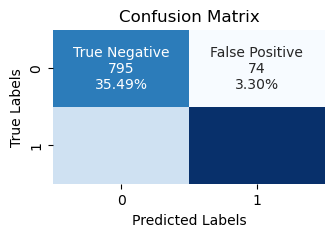




Confusion matrix

 [[ 795   74]
 [ 282 1089]]

True Negatives  (TN) =  795
False Positives (FP) =  74
False Negatives (FN) =  282
True Positives  (TP) =  1089


Accuracy:        0.8410714285714286
Sensitivity:     0.7943107221006565
Specificity:     0.9148446490218642
Geometric Mean:  0.8524499479585171


Precision:        0.8594766329446294
Recall:           0.8410714285714286
f1-score:         0.8430423222590041

------------------------------------------------

Current Time: 2024-05-15 20:40:06
The entire notebook runtime so far is 21 minutes


In [147]:
# SimpleRNN hyperparameter optimization with 1 hidden layer

#import numpy as np
#from sklearn.model_selection import GridSearchCV
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
#from sklearn.metrics import make_scorer, accuracy_score

# Define input shape based on the features in X_train
input_shape = (X_train_with_time_steps.shape[1], X_train_with_time_steps.shape[2])  # Assuming X_train is 2D

# Define a function to create a model
def create_model(units=64, dropout=0.5):
    model = Sequential([
        SimpleRNN(units, input_shape=input_shape),  #input layer
        Dropout(dropout),                           #regularization
        Dense(32, activation='relu'),               #hidden layer 1
        Dense(1, activation='sigmoid')              #output layer
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create a wrapper class around the Keras model
class KerasSimpleRNNWrapper:
    def __init__(self, units=64, dropout=0.5, epochs=epoch_count, batch_size=32, verbose=0):
        self.units = units
        self.dropout = dropout
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model = None

    def fit(self, X, y):
        self.model = create_model(units=self.units, dropout=self.dropout)
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype(int)

    def get_params(self, deep=True):
        return {
            'units': self.units,
            'dropout': self.dropout,
            'epochs': self.epochs,
            'batch_size': self.batch_size,
            'verbose': self.verbose
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

# Create an instance of the wrapper class
model = KerasSimpleRNNWrapper()

# Define the hyperparameters grid to search
#param_grid = {
#    'units': [32, 64, 128],
#    'dropout': [0.3, 0.5, 0.7]
#}
param_grid = {        #smaller faster version for testing
    'units': [32],
    'dropout': [0.3]
}


# Create GridSearchCV instance
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_count, scoring=make_scorer(accuracy_score), verbose=epoch_verbosity)

# Perform grid search
print(f"------------------------------------------")
print(f"Performing GridSearchCV")
# Calculate the total number of combinations in GridSearchCV
total_combinations = 1
for param in param_grid:
    total_combinations *= len(param_grid[param])
print("Total number of combinations in the parameter grid:", total_combinations)
print("Total number of cross validation folds:", cv_count)
total_combinations_times_cv_count = total_combinations * cv_count
print(f"parameter grid x CV folds = {total_combinations} x {cv_count} = {total_combinations_times_cv_count} GridSearchCV cycles")
print(f"------------------------------------------")
grid_search_result = grid_search.fit(X_train_with_time_steps, y_train)


# Print best parameters and results
print("Best Parameters:", grid_search_result.best_params_)
print("Best Accuracy:", grid_search_result.best_score_)

# final cross validation
cross_val_score_result = cross_val_score(clf, X_train, y_train, cv=cv_count)
print(f"-----------------------------------------")
print(f"Cross validation scores: {cross_val_score_result}")
print(f"Mean cross validation score: {cross_val_score_result.mean()}")
print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")
simplernn_crossval_score_all  = cross_val_score_result         #save all folds in a list for later comparison
simplernn_crossval_score_mean = cross_val_score_result.mean()  #save mean   crossval score in a variable for later comparison
simplernn_crossval_score_std  = cross_val_score_result.std()   #save stddev crossval score in a variable for later comparison

# Evaluate the model on training data
print(f"------------------------------------------")
print(f"Evaluating the model on training data")
best_model = grid_search_result.best_estimator_
train_loss, train_accuracy = best_model.model.evaluate(X_train_with_time_steps, y_train)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)


# Evaluate the model on test data
print(f"-----------------------------------------")
print(f"Evaluating the model on test data")
test_loss, test_accuracy = best_model.model.evaluate(X_test_with_time_steps, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


# Evaluate the model on validation data
print(f"-----------------------------------------")
print(f"Evaluating the model on validation data")
print(f"-----------------------------------------")
val_loss, val_accuracy = best_model.model.evaluate(X_val_with_time_steps, y_val)
print("Val Loss:", val_loss)
print("Val Accuracy:", val_accuracy)
print(f"-----------------------------------------")


# save results calculated for this model for later comparison to other models
test_accuracy_simplernn_optimized  = test_accuracy
test_loss_simplernn_optimized      = test_loss
train_accuracy_simplernn_optimized = train_accuracy
train_loss_simplernn_optimized     = train_loss
val_accuracy_simplernn_optimized   = val_accuracy
val_loss_simplernn_optimized       = val_loss

# Extracting accuracy and loss history from the training, will be used later for graphing convergence
train_loss_history_optimized     = history.history['loss']
train_accuracy_history_optimized = history.history['accuracy']
val_loss_history_optimized       = history.history['val_loss']
val_accuracy_history_optimized   = history.history['val_accuracy']


# call previously defined function to create confusion matrix
cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# save results calculated for this model for later comparison to other models
accuracy_simplernn_optimized      = Accuracy
sensitivity_simplernn_optimized   = Sensitivity
specificity_simplernn_optimized   = Specificity
geometricmean_simplernn_optimized = GeometricMean
precision_simplernn_optimized     = Precision
recall_simplernn_optimized        = Recall
f1_simplernn_optimized            = F1

# show a running total of elapsed time for the entire notebook
show_elapsed_time()



train_loss_history_unoptimized 0.4879 0.4170 0.4003 0.3887 0.3796 0.3707 0.3651 0.3590 0.3542 0.3510 0.3456 0.3416 0.3399 0.3362 0.3355 0.3300 0.3284 0.3291 0.3256 0.3243 0.3193 0.3197 0.3177 0.3179 0.3138 

train_loss_history_optimized 0.4879 0.4170 0.4003 0.3887 0.3796 0.3707 0.3651 0.3590 0.3542 0.3510 0.3456 0.3416 0.3399 0.3362 0.3355 0.3300 0.3284 0.3291 0.3256 0.3243 0.3193 0.3197 0.3177 0.3179 0.3138 

val_loss_history_unoptimized 0.4511 0.4357 0.4286 0.4190 0.4149 0.4111 0.4090 0.4135 0.4039 0.4061 0.4007 0.4007 0.4056 0.4032 0.4060 0.4010 0.4085 0.4137 0.4071 0.4154 0.4092 0.4136 0.4147 0.4085 0.4115 

val_loss_history_optimized 0.4511 0.4357 0.4286 0.4190 0.4149 0.4111 0.4090 0.4135 0.4039 0.4061 0.4007 0.4007 0.4056 0.4032 0.4060 0.4010 0.4085 0.4137 0.4071 0.4154 0.4092 0.4136 0.4147 0.4085 0.4115 

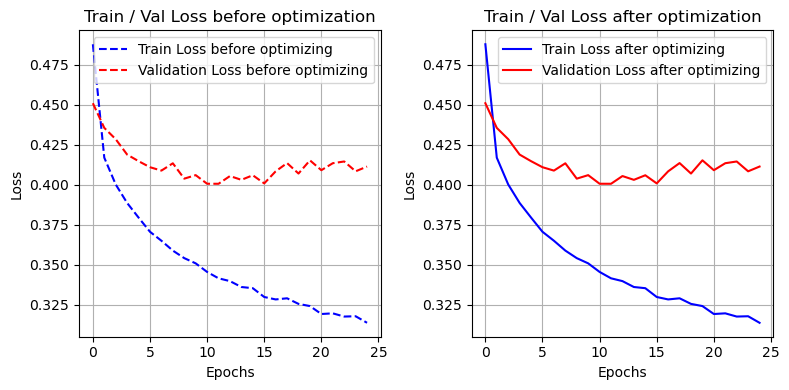

WARNING, after optimization, loss divergence is 0.09766539931297302, which greater than threshold of 0.01, please continue tuning this model.


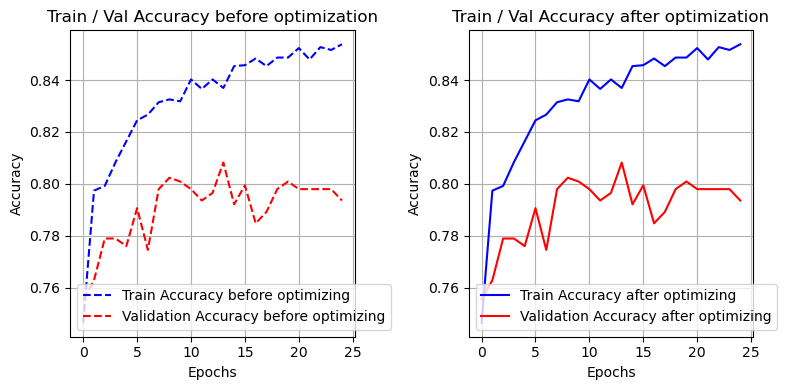

WARNING, after optimization, accuracy divergence is 0.060234785079956055, which greater than threshold of 0.01, please continue tuning this model.


In [148]:
# Call previously defined functions to create graphs that show how Training/Validation loss and accuracy converge
# It is important that the lines converge, if they do not, add more data, more epochs, or try different hyperparameter optimizations

# print current history values, use end=" " to print all output on single line
print(f"\n\ntrain_loss_history_unoptimized", end=" ") 
for value in train_loss_history_unoptimized: print(f"{value:.4f}", end=" ")
#
print(f"\n\ntrain_loss_history_optimized", end=" ") 
for value in train_loss_history_optimized: print(f"{value:.4f}", end=" ")
#
print(f"\n\nval_loss_history_unoptimized", end=" ") 
for value in val_loss_history_unoptimized: print(f"{value:.4f}", end=" ")
#
print(f"\n\nval_loss_history_optimized", end=" ") 
for value in val_loss_history_optimized: print(f"{value:.4f}", end=" ")


# sanity check to confirm the required values have already been collected, set to zeros if needed to avoid undef errors
if len(train_loss_history_unoptimized) != epoch_count: print("ERROR: incorrect len() of train_loss_history_unoptimized, resetting to all zeros") ; train_loss_history_unoptimized = [0] * epoch_count
if len(train_loss_history_optimized)   != epoch_count: print("ERROR: incorrect len() of train_loss_history_optimized,   resetting to all zeros") ; train_loss_history_optimized   = [0] * epoch_count
if len(val_loss_history_unoptimized)   != epoch_count: print("ERROR: incorrect len() of val_loss_history_unoptimized,   resetting to all zeros") ; val_loss_history_unoptimized   = [0] * epoch_count
if len(val_loss_history_optimized)     != epoch_count: print("ERROR: incorrect len() of  val_loss_history_optimized,    resetting to all zeros") ; val_loss_history_optimized     = [0] * epoch_count

# create the convergence graphs
plot_loss_history(train_loss_history_unoptimized, train_loss_history_optimized, val_loss_history_unoptimized, val_loss_history_optimized, epoch_count)
plot_accuracy_history(train_accuracy_history_unoptimized, train_accuracy_history_optimized, val_accuracy_history_unoptimized, val_accuracy_history_optimized, epoch_count)

### 2 hidden layers

------------------------------------------
Performing GridSearchCV
Total number of combinations in the parameter grid: 1
Total number of cross validation folds: 10
parameter grid x CV folds = 1 x 10 = 10 GridSearchCV cycles
------------------------------------------
Fitting 10 folds for each of 1 candidates, totalling 10 fits
11/11 [==============================] - 0s 1ms/step
[CV] END ..............................dropout=0.3, units=32; total time=   4.9s
11/11 [==============================] - 0s 1ms/step
[CV] END ..............................dropout=0.3, units=32; total time=   4.9s
11/11 [==============================] - 0s 1ms/step
[CV] END ..............................dropout=0.3, units=32; total time=   4.8s
11/11 [==============================] - 0s 1ms/step
[CV] END ..............................dropout=0.3, units=32; total time=   5.3s
11/11 [==============================] - 0s 1ms/step
[CV] END ..............................dropout=0.3, units=32; total time=   4.9s
11

C:\Users\njeffrey\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

C:\Users\njeffrey\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.



-----------------------------------------
Cross validation scores: [0.85964912 0.83625731 0.84457478 0.85337243 0.84750733 0.81818182
 0.83577713 0.83870968 0.79765396 0.82404692]
Mean cross validation score: 0.835573047966936
Standard Deviation cross validation score: 0.017330452746722153
------------------------------------------
Evaluating the model on training data
107/107 [==============================] - 0s 1ms/step - loss: 0.3349 - accuracy: 0.8397
Train Loss: 0.3349253833293915
Train Accuracy: 0.839683473110199
-----------------------------------------
Evaluating the model on test data
70/70 [==============================] - 0s 2ms/step - loss: 0.3484 - accuracy: 0.8179
Test Loss: 0.34835734963417053
Test Accuracy: 0.8178571462631226
-----------------------------------------
Evaluating the model on validation data
-----------------------------------------
71/71 [==============================] - 0s 1ms/step - loss: 0.3563 - accuracy: 0.8126
Val Loss: 0.35626280307769775
Val A

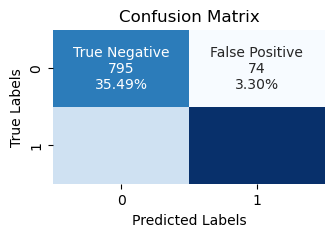




Confusion matrix

 [[ 795   74]
 [ 282 1089]]

True Negatives  (TN) =  795
False Positives (FP) =  74
False Negatives (FN) =  282
True Positives  (TP) =  1089


Accuracy:        0.8410714285714286
Sensitivity:     0.7943107221006565
Specificity:     0.9148446490218642
Geometric Mean:  0.8524499479585171


Precision:        0.8594766329446294
Recall:           0.8410714285714286
f1-score:         0.8430423222590041

------------------------------------------------

Current Time: 2024-05-15 20:45:40
The entire notebook runtime so far is 26 minutes


In [150]:
# SimpleRNN hyperparameter optimization with 2 hidden layers

#import numpy as np
#from sklearn.model_selection import GridSearchCV
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
#from sklearn.metrics import make_scorer, accuracy_score

# Define input shape based on the features in X_train
input_shape = (X_train_with_time_steps.shape[1], X_train_with_time_steps.shape[2])  # Assuming X_train is 2D

# Define a function to create a model
def create_model(units=64, dropout=0.5):
    model = Sequential([
        SimpleRNN(units, input_shape=input_shape),  #input layer
        Dropout(dropout),
        Dense(32, activation='relu'),               #hidden layer 1
        Dense(32, activation='relu'),               #hidden layer 2
        Dense(1, activation='sigmoid')              #output layer
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create a wrapper class around the Keras model
class KerasSimpleRNNWrapper:
    def __init__(self, units=64, dropout=0.5, epochs=epoch_count, batch_size=32, verbose=0):
        self.units = units
        self.dropout = dropout
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model = None

    def fit(self, X, y):
        self.model = create_model(units=self.units, dropout=self.dropout)
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype(int)

    def get_params(self, deep=True):
        return {
            'units': self.units,
            'dropout': self.dropout,
            'epochs': self.epochs,
            'batch_size': self.batch_size,
            'verbose': self.verbose
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

# Create an instance of the wrapper class
model = KerasSimpleRNNWrapper()

# Define the hyperparameters grid to search
#param_grid = {
#    'units': [32, 64, 128],
#    'dropout': [0.3, 0.5, 0.7]
#}
param_grid = {        #smaller faster version for testing
    'units': [32],
    'dropout': [0.3]
}


# Create GridSearchCV instance
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_count, scoring=make_scorer(accuracy_score), verbose=epoch_verbosity)

# Perform grid search
print(f"------------------------------------------")
print(f"Performing GridSearchCV")
# Calculate the total number of combinations in GridSearchCV
total_combinations = 1
for param in param_grid:
    total_combinations *= len(param_grid[param])
print("Total number of combinations in the parameter grid:", total_combinations)
print("Total number of cross validation folds:", cv_count)
total_combinations_times_cv_count = total_combinations * cv_count
print(f"parameter grid x CV folds = {total_combinations} x {cv_count} = {total_combinations_times_cv_count} GridSearchCV cycles")
print(f"------------------------------------------")
grid_search_result = grid_search.fit(X_train_with_time_steps, y_train)


# Print best parameters and results
print("Best Parameters:", grid_search_result.best_params_)
print("Best Accuracy:", grid_search_result.best_score_)

# final cross validation
cross_val_score_result = cross_val_score(clf, X_train, y_train, cv=cv_count)
print(f"-----------------------------------------")
print(f"Cross validation scores: {cross_val_score_result}")
print(f"Mean cross validation score: {cross_val_score_result.mean()}")
print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")
simplernn_crossval_score_all  = cross_val_score_result         #save all folds in a list for later comparison
simplernn_crossval_score_mean = cross_val_score_result.mean()  #save mean   crossval score in a variable for later comparison
simplernn_crossval_score_std  = cross_val_score_result.std()   #save stddev crossval score in a variable for later comparison

# Evaluate the model on training data
print(f"------------------------------------------")
print(f"Evaluating the model on training data")
best_model = grid_search_result.best_estimator_
train_loss, train_accuracy = best_model.model.evaluate(X_train_with_time_steps, y_train)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)


# Evaluate the model on test data
print(f"-----------------------------------------")
print(f"Evaluating the model on test data")
test_loss, test_accuracy = best_model.model.evaluate(X_test_with_time_steps, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


# Evaluate the model on validation data
print(f"-----------------------------------------")
print(f"Evaluating the model on validation data")
print(f"-----------------------------------------")
val_loss, val_accuracy = best_model.model.evaluate(X_val_with_time_steps, y_val)
print("Val Loss:", val_loss)
print("Val Accuracy:", val_accuracy)
print(f"-----------------------------------------")


# save results calculated for this model for later comparison to other models
test_accuracy_simplernn_optimized  = test_accuracy
test_loss_simplernn_optimized      = test_loss
train_accuracy_simplernn_optimized = train_accuracy
train_loss_simplernn_optimized     = train_loss
val_accuracy_simplernn_optimized   = val_accuracy
val_loss_simplernn_optimized       = val_loss

# Extracting accuracy and loss history from the training, will be used later for graphing convergence
train_loss_history_optimized     = history.history['loss']
train_accuracy_history_optimized = history.history['accuracy']
val_loss_history_optimized       = history.history['val_loss']
val_accuracy_history_optimized   = history.history['val_accuracy']


# call previously defined function to create confusion matrix
cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# save results calculated for this model for later comparison to other models
accuracy_simplernn_optimized      = Accuracy
sensitivity_simplernn_optimized   = Sensitivity
specificity_simplernn_optimized   = Specificity
geometricmean_simplernn_optimized = GeometricMean
precision_simplernn_optimized     = Precision
recall_simplernn_optimized        = Recall
f1_simplernn_optimized            = F1

# show a running total of elapsed time for the entire notebook
show_elapsed_time()



train_loss_history_unoptimized 0.4879 0.4170 0.4003 0.3887 0.3796 0.3707 0.3651 0.3590 0.3542 0.3510 0.3456 0.3416 0.3399 0.3362 0.3355 0.3300 0.3284 0.3291 0.3256 0.3243 0.3193 0.3197 0.3177 0.3179 0.3138 

train_loss_history_optimized 0.4879 0.4170 0.4003 0.3887 0.3796 0.3707 0.3651 0.3590 0.3542 0.3510 0.3456 0.3416 0.3399 0.3362 0.3355 0.3300 0.3284 0.3291 0.3256 0.3243 0.3193 0.3197 0.3177 0.3179 0.3138 

val_loss_history_unoptimized 0.4511 0.4357 0.4286 0.4190 0.4149 0.4111 0.4090 0.4135 0.4039 0.4061 0.4007 0.4007 0.4056 0.4032 0.4060 0.4010 0.4085 0.4137 0.4071 0.4154 0.4092 0.4136 0.4147 0.4085 0.4115 

val_loss_history_optimized 0.4511 0.4357 0.4286 0.4190 0.4149 0.4111 0.4090 0.4135 0.4039 0.4061 0.4007 0.4007 0.4056 0.4032 0.4060 0.4010 0.4085 0.4137 0.4071 0.4154 0.4092 0.4136 0.4147 0.4085 0.4115 

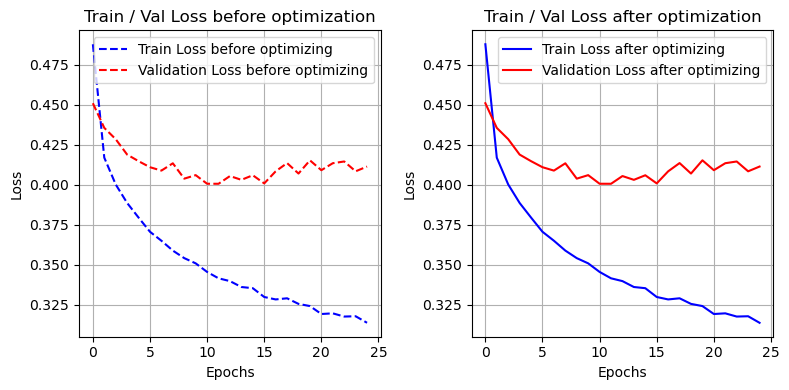

WARNING, after optimization, loss divergence is 0.09766539931297302, which greater than threshold of 0.01, please continue tuning this model.


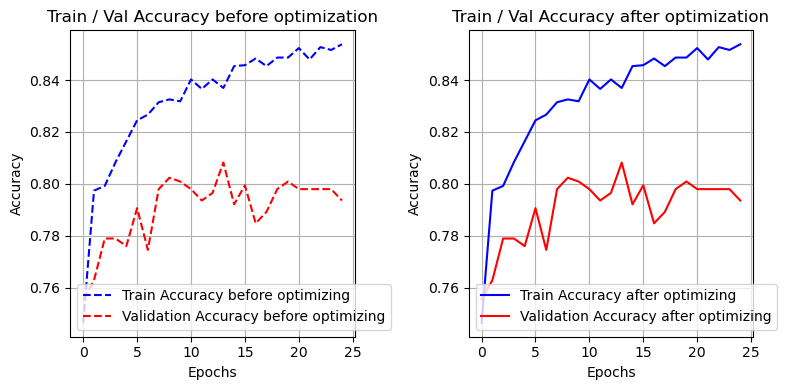

WARNING, after optimization, accuracy divergence is 0.060234785079956055, which greater than threshold of 0.01, please continue tuning this model.


In [151]:
# Call previously defined functions to create graphs that show how Training/Validation loss and accuracy converge
# It is important that the lines converge, if they do not, add more data, more epochs, or try different hyperparameter optimizations

# print current history values, use end=" " to print all output on single line
print(f"\n\ntrain_loss_history_unoptimized", end=" ") 
for value in train_loss_history_unoptimized: print(f"{value:.4f}", end=" ")
#
print(f"\n\ntrain_loss_history_optimized", end=" ") 
for value in train_loss_history_optimized: print(f"{value:.4f}", end=" ")
#
print(f"\n\nval_loss_history_unoptimized", end=" ") 
for value in val_loss_history_unoptimized: print(f"{value:.4f}", end=" ")
#
print(f"\n\nval_loss_history_optimized", end=" ") 
for value in val_loss_history_optimized: print(f"{value:.4f}", end=" ")


# sanity check to confirm the required values have already been collected, set to zeros if needed to avoid undef errors
if len(train_loss_history_unoptimized) != epoch_count: print("ERROR: incorrect len() of train_loss_history_unoptimized, resetting to all zeros") ; train_loss_history_unoptimized = [0] * epoch_count
if len(train_loss_history_optimized)   != epoch_count: print("ERROR: incorrect len() of train_loss_history_optimized,   resetting to all zeros") ; train_loss_history_optimized   = [0] * epoch_count
if len(val_loss_history_unoptimized)   != epoch_count: print("ERROR: incorrect len() of val_loss_history_unoptimized,   resetting to all zeros") ; val_loss_history_unoptimized   = [0] * epoch_count
if len(val_loss_history_optimized)     != epoch_count: print("ERROR: incorrect len() of  val_loss_history_optimized,    resetting to all zeros") ; val_loss_history_optimized     = [0] * epoch_count

# create the convergence graphs
plot_loss_history(train_loss_history_unoptimized, train_loss_history_optimized, val_loss_history_unoptimized, val_loss_history_optimized, epoch_count)
plot_accuracy_history(train_accuracy_history_unoptimized, train_accuracy_history_optimized, val_accuracy_history_unoptimized, val_accuracy_history_optimized, epoch_count)

## SimpleRNN + LSTM

### default params

In [152]:
# show a running total of elapsed time for the entire notebook
show_elapsed_time()

Current Time: 2024-05-15 20:46:57
The entire notebook runtime so far is 28 minutes


-----------------------------------------
Model Summary
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_23 (SimpleRNN)   (None, 1, 64)             5760      
                                                                 
 dropout_23 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                                 
 dense_60 (Dense)            (None, 1)                 33        
                                                                 
Total params: 18,209
Trainable params: 18,209
Non-trainable params: 0
_________________________________________________________________
None
-----------------------------------------
Training the model
Epoch 1/25
86/86 [==============================] - 4s 10ms

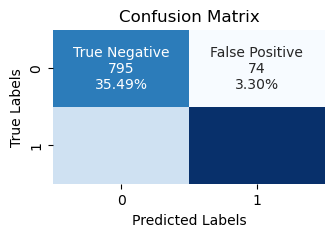




Confusion matrix

 [[ 795   74]
 [ 282 1089]]

True Negatives  (TN) =  795
False Positives (FP) =  74
False Negatives (FN) =  282
True Positives  (TP) =  1089


Accuracy:        0.8410714285714286
Sensitivity:     0.7943107221006565
Specificity:     0.9148446490218642
Geometric Mean:  0.8524499479585171


Precision:        0.8594766329446294
Recall:           0.8410714285714286
f1-score:         0.8430423222590041

------------------------------------------------

Current Time: 2024-05-15 20:47:11
The entire notebook runtime so far is 28 minutes


In [153]:
# SimpleRNN + LSTM, default parameters, 1 hidden layer

#import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, SimpleRNN, LSTM

# Define input shape based on the features in X_train_with_time_steps
input_shape = X_train_with_time_steps.shape[1:]

# Define the model
model = Sequential([
    SimpleRNN(64, input_shape=input_shape, return_sequences=True),  #input layer, SimpleRNN layer with 64 units
    Dropout(0.5),                                                   #regularization
    LSTM(32),                                                       #hidden layer 1,  LSTM layer with 32 units 
    Dense(1, activation='sigmoid')                                  # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Print model summary
print(f"-----------------------------------------")
print(f"Model Summary")
print(model.summary())


# Train the model
print(f"-----------------------------------------")
print(f"Training the model")
history = model.fit(X_train_with_time_steps, y_train, epochs=epoch_count, batch_size=32, validation_split=0.2)


# Evaluate the model on training data
print(f"-----------------------------------------")
print(f"Evaluating the model on training data")
train_loss, train_accuracy = model.evaluate(X_train_with_time_steps, y_train)
print("Training Loss:", train_loss)
print("Training Accuracy:", train_accuracy)


# Evaluate the model on test data
print(f"-----------------------------------------")
print(f"Evaluating the model on test data")
test_loss, test_accuracy = model.evaluate(X_test_with_time_steps, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


# Evaluate the model on validation data
print(f"-----------------------------------------")
print(f"Evaluating the model on validation data")
val_loss, val_accuracy = model.evaluate(X_val_with_time_steps, y_val)
print("Val Loss:", val_loss)
print("Val Accuracy:", val_accuracy)


# save results calculated for this model for later comparison to other models
test_accuracy_simplernn_lstm_unoptimized  = test_accuracy
test_loss_simplernn_lstm_unoptimized      = test_loss
train_accuracy_simplernn_lstm_unoptimized = train_accuracy
train_loss_simplernn_lstm_unoptimized     = train_loss
val_accuracy_simplernn_lstm_unoptimized   = val_accuracy
val_loss_simplernn_lstm_unoptimized       = val_loss

# Extracting accuracy and loss history from the training, will be used later for graphing convergence
train_loss_history_unoptimized     = history.history['loss']
train_accuracy_history_unoptimized = history.history['accuracy']
val_loss_history_unoptimized       = history.history['val_loss']
val_accuracy_history_unoptimized   = history.history['val_accuracy']

# call previously defined function to create confusion matrix
cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# save results calculated for this model for later comparison to other models
accuracy_simplernn_lstm_unoptimized      = Accuracy
sensitivity_simplernn_lstm_unoptimized   = Sensitivity
specificity_simplernn_lstm_unoptimized   = Specificity
geometricmean_simplernn_lstm_unoptimized = GeometricMean
precision_simplernn_lstm_unoptimized     = Precision
recall_simplernn_lstm_unoptimized        = Recall
f1_simplernn_lstm_unoptimized            = F1

# show a running total of elapsed time for the entire notebook
show_elapsed_time()

### optimized params
RNN + LSTM

We do not have a simple way to perform hyperparameter optimization on multiple depths of hidden layers, so this section has a lot of duplicated code.

The different numbers of hidden layers are configured in the create_model section

In [193]:
# Define the hyperparameters grid to search
if dataset_name == "Edge-IIoTset2023":
    param_grid = {        #smaller faster version for testing
        'units': [32, 64],
        'dropout': [0.3, 0.5]
    }
if dataset_name == "CIC_IOT_Dataset2023":
    param_grid = {        #smaller faster version for testing
        'units': [32, 64],
        'dropout': [0.3, 0.5]
    }



### define functions for models with different layers

In [194]:
# define a function to create a model with 1 hidden layer

# Define input shape based on the features in X_train
#input_shape = (X_train_with_time_steps.shape[1], X_train_with_time_steps.shape[2])  # Assuming X_train is 2D
input_shape = X_train_with_time_steps.shape[1:]


# Define a function to create a model
def create_rnn_lstm_model_with_1_hidden_layers(units=64, dropout=0.5):
    model = Sequential([
        SimpleRNN(units, input_shape=input_shape, return_sequences=True),  #input layer, must have return_sequences=True if passing to an LSTM hidden layer
        Dropout(dropout),                                                  #Optional dropout layer for regularization to randomly sets a fraction of input units to zero during training to prevent overfitting
        LSTM(round(units), dropout=dropout, return_sequences=False),       #hidden layer 1, units (neurons) must be an integer, must have return_sequences=True if passing to another LSTM hidden layer
        Dropout(dropout),                                                  #Optional dropout layer for regularization to randomly sets a fraction of input units to zero during training to prevent overfitting
        #Dense(units/2, activation='relu'),                                #add another hidden layer, this example is a Dense (fully connected) layer rather than LSTM
        Dense(1, activation='sigmoid')                                     #output layer
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [195]:
# define a function to create a model with 2 hidden layers

# Define input shape based on the features in X_train
#input_shape = (X_train_with_time_steps.shape[1], X_train_with_time_steps.shape[2])  # Assuming X_train is 2D
input_shape = X_train_with_time_steps.shape[1:]

def create_rnn_lstm_model_with_2_hidden_layers(units=64, dropout=0.5):
    model = Sequential([
        SimpleRNN(units, input_shape=input_shape, return_sequences=True),  # Input layer, , must have return_sequences=True if passing to an LSTM hidden layer
        Dropout(dropout),                                                  # Optional dropout layer for regularization
        LSTM(round(units/2), dropout=dropout, return_sequences=True),      # Hidden layer 1, units (neurons) must be an integer, must have return_sequences=True if passing to an LSTM hidden layer
        Dropout(dropout),                                                  # Optional dropout layer for regularization
        LSTM(round(units/4), dropout=dropout, return_sequences=False),     # Hidden layer 2, units (neurons) must be an integer, must have return_sequences=True if passing to an LSTM hidden layer
        Dropout(dropout),                                                  # Optional dropout layer for regularization
        #Dense(units/2, activation='relu'),                                #add another hidden layer, this example is a Dense (fully connected) layer rather than LSTM
        Dense(1, activation='sigmoid')                                     # Output layer
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model



In [196]:
# define a function to create a model with 3 hidden layers

def create_rnn_lstm_model_with_3_hidden_layers(units=64, dropout=0.5):
    model = Sequential([
        SimpleRNN(units, input_shape=input_shape, return_sequences=True),  # Input layer, , must have return_sequences=True if passing to an LSTM hidden layer
        Dropout(dropout),                                                  # Optional dropout layer for regularization
        LSTM(round(units/2), dropout=dropout, return_sequences=True),      # Hidden layer 1, units (neurons) must be an integer, must have return_sequences=True if passing to an LSTM hidden layer
        Dropout(dropout),                                                  # Optional dropout layer for regularization
        LSTM(round(units/4), dropout=dropout, return_sequences=True),      # Hidden layer 2, units (neurons) must be an integer, must have return_sequences=True if passing to an LSTM hidden layer
        Dropout(dropout),                                                  # Optional dropout layer for regularization
        LSTM(round(units/8), dropout=dropout, return_sequences=False),     # Hidden layer 3, units (neurons) must be an integer, must have return_sequences=True if passing to an LSTM hidden layer
        Dropout(dropout),                                                  # Optional dropout layer for regularization
        #Dense(units/2, activation='relu'),                                #add another hidden layer, this example is a Dense (fully connected) layer rather than LSTM
        Dense(1, activation='sigmoid')                                     # Output layer
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model



In [197]:
# define a function to create a model with 4 hidden layers

# Define input shape based on the features in X_train
#input_shape = (X_train_with_time_steps.shape[1], X_train_with_time_steps.shape[2])  # Assuming X_train is 2D
input_shape = X_train_with_time_steps.shape[1:]

def create_rnn_lstm_model_with_4_hidden_layers(units=64, dropout=0.5):
    model = Sequential([
        SimpleRNN(units, input_shape=input_shape, return_sequences=True),  # Input layer, must have return_sequences=True if passing to an LSTM hidden layer
        Dropout(dropout),                                                  # Optional dropout layer for regularization
        LSTM(round(units/2), dropout=dropout, return_sequences=True),      # Hidden layer 1, units (neurons) must be an integer, must have return_sequences=True if passing to an LSTM hidden layer
        Dropout(dropout),                                                  # Optional dropout layer for regularization
        LSTM(round(units/4), dropout=dropout, return_sequences=True),      # Hidden layer 2, units (neurons) must be an integer, must have return_sequences=True if passing to an LSTM hidden layer
        Dropout(dropout),                                                  # Optional dropout layer for regularization
        LSTM(round(units/8), dropout=dropout, return_sequences=False),     # Hidden layer 3, units (neurons) must be an integer, must have return_sequences=True if passing to an LSTM hidden layer
        Dropout(dropout),                                                  # Optional dropout layer for regularization
        Dense(round(units/4), activation='relu'),                          # Hidden layer 4, using Dense (fully connected) instead of LSTM
        Dense(1, activation='sigmoid')                                     # Output layer
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [198]:
# Create a wrapper class around the Keras model
# Note that this wrapper makes use of the value of the hidden_layers variable that is called in subsequent sections

class KerasSimpleRNNWrapper:
    def __init__(self, units=64, dropout=0.5, epochs=epoch_count, batch_size=32, verbose=0):
        self.units = units
        self.dropout = dropout
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model = None

    def fit(self, X, y):
        # figure out which previously defined function we should use
        # IMPORTANT: the hidden_layers variable must be defined!
        if hidden_layers == 1: model_name = create_rnn_lstm_model_with_1_hidden_layers
        if hidden_layers == 2: model_name = create_rnn_lstm_model_with_2_hidden_layers
        if hidden_layers == 3: model_name = create_rnn_lstm_model_with_3_hidden_layers
        if hidden_layers == 4: model_name = create_rnn_lstm_model_with_4_hidden_layers
        if hidden_layers == 5: model_name = create_rnn_lstm_model_with_5_hidden_layers
        if hidden_layers == 6: model_name = create_rnn_lstm_model_with_6_hidden_layers
        if hidden_layers == 7: model_name = create_rnn_lstm_model_with_7_hidden_layers
        if hidden_layers == 8: model_name = create_rnn_lstm_model_with_8_hidden_layers
        if hidden_layers == 9: model_name = create_rnn_lstm_model_with_9_hidden_layers
        # Now we know model_name based on the value of hidden_layers variable
        self.model = model_name(units=self.units, dropout=self.dropout)
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype(int)

    def get_params(self, deep=True):
        return {
            'units': self.units,
            'dropout': self.dropout,
            'epochs': self.epochs,
            'batch_size': self.batch_size,
            'verbose': self.verbose
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

# Create an instance of the wrapper class
model = KerasSimpleRNNWrapper()


### 1 hidden layer

In [200]:
# this variable determines which of the previously defined functions will be called
hidden_layers = 1

------------------------------------------
Performing GridSearchCV
Total number of combinations in the parameter grid: 4
Total number of cross validation folds: 10
parameter grid x CV folds = 4 x 10 = 40 GridSearchCV cycles
------------------------------------------
Fitting 10 folds for each of 4 candidates, totalling 40 fits
11/11 [==============================] - 1s 1ms/step
[CV] END ..............................dropout=0.3, units=32; total time=  10.4s
11/11 [==============================] - 1s 1ms/step
[CV] END ..............................dropout=0.3, units=32; total time=   9.6s
11/11 [==============================] - 1s 2ms/step
[CV] END ..............................dropout=0.3, units=32; total time=  10.2s
11/11 [==============================] - 1s 2ms/step
[CV] END ..............................dropout=0.3, units=32; total time=  10.3s
11/11 [==============================] - 1s 1ms/step
[CV] END ..............................dropout=0.3, units=32; total time=   9.9s
11

C:\Users\njeffrey\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

C:\Users\njeffrey\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.



-----------------------------------------
Cross validation scores: [0.85964912 0.83625731 0.84457478 0.85337243 0.84750733 0.81818182
 0.83577713 0.83870968 0.79765396 0.82404692]
Mean cross validation score: 0.835573047966936
Standard Deviation cross validation score: 0.017330452746722153
------------------------------------------
Evaluating the model on training data
107/107 [==============================] - 1s 2ms/step - loss: 0.3480 - accuracy: 0.8318
Train Loss: 0.3479764759540558
Train Accuracy: 0.8317702412605286
-----------------------------------------
Evaluating the model on test data
70/70 [==============================] - 0s 3ms/step - loss: 0.3506 - accuracy: 0.8241
Test Loss: 0.3505611717700958
Test Accuracy: 0.8241071701049805
-----------------------------------------
Evaluating the model on validation data
71/71 [==============================] - 0s 2ms/step - loss: 0.3522 - accuracy: 0.8170
Val Loss: 0.3521983325481415
Val Accuracy: 0.8170459866523743
---------------

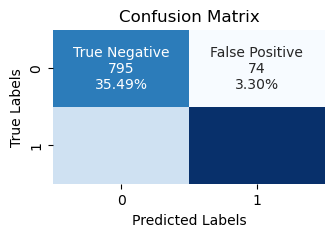




Confusion matrix

 [[ 795   74]
 [ 282 1089]]

True Negatives  (TN) =  795
False Positives (FP) =  74
False Negatives (FN) =  282
True Positives  (TP) =  1089


Accuracy:        0.8410714285714286
Sensitivity:     0.7943107221006565
Specificity:     0.9148446490218642
Geometric Mean:  0.8524499479585171


Precision:        0.8594766329446294
Recall:           0.8410714285714286
f1-score:         0.8430423222590041

------------------------------------------------

Current Time: 2024-05-15 22:23:53
The entire notebook runtime so far is 124 minutes


In [201]:
# This cell is the same for each of the different number of hidden layers

# Create an instance of the wrapper class, using the previously defined hidden_layers variable
model = KerasSimpleRNNWrapper()

# Create GridSearchCV instance
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_count, scoring=make_scorer(accuracy_score), verbose=epoch_verbosity)
# Perform grid search
print(f"------------------------------------------")
print(f"Performing GridSearchCV")
# Calculate the total number of combinations in GridSearchCV
total_combinations = 1
for param in param_grid:
    total_combinations *= len(param_grid[param])
print("Total number of combinations in the parameter grid:", total_combinations)
print("Total number of cross validation folds:", cv_count)
total_combinations_times_cv_count = total_combinations * cv_count
print(f"parameter grid x CV folds = {total_combinations} x {cv_count} = {total_combinations_times_cv_count} GridSearchCV cycles")
print(f"------------------------------------------")
grid_search_result = grid_search.fit(X_train_with_time_steps, y_train)


# Print best parameters and results
print("Best Parameters:", grid_search_result.best_params_)
print("Best Accuracy:", grid_search_result.best_score_)


# final cross validation
cross_val_score_result = cross_val_score(clf, X_train, y_train, cv=cv_count)
print(f"-----------------------------------------")
print(f"Cross validation scores: {cross_val_score_result}")
print(f"Mean cross validation score: {cross_val_score_result.mean()}")
print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")
simplernn_lstm_crossval_score_all  = cross_val_score_result         #save all folds in a list for later comparison
simplernn_lstm_crossval_score_mean = cross_val_score_result.mean()  #save mean   crossval score in a variable for later comparison
simplernn_lstm_crossval_score_std  = cross_val_score_result.std()   #save stddev crossval score in a variable for later comparison

# Evaluate the model on training data
print(f"------------------------------------------")
print(f"Evaluating the model on training data")
best_model = grid_search_result.best_estimator_
train_loss, train_accuracy = best_model.model.evaluate(X_train_with_time_steps, y_train)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)


# Evaluate the model on test data
print(f"-----------------------------------------")
print(f"Evaluating the model on test data")
test_loss, test_accuracy = best_model.model.evaluate(X_test_with_time_steps, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


# Evaluate the model on validation data
print(f"-----------------------------------------")
print(f"Evaluating the model on validation data")
val_loss, val_accuracy = best_model.model.evaluate(X_val_with_time_steps, y_val)
print("Val Loss:", val_loss)
print("Val Accuracy:", val_accuracy)
print(f"-----------------------------------------")


# save results calculated for this model for later comparison to other models
test_accuracy_simplernn_lstm_optimized  = test_accuracy
test_loss_simplernn_lstm_optimized      = test_loss
train_accuracy_simplernn_lstm_optimized = train_accuracy
train_loss_simplernn_lstm_optimized     = train_loss
val_accuracy_simplernn_lstm_optimized   = val_accuracy
val_loss_simplernn_lstm_optimized       = val_loss

# Extracting accuracy and loss history from the training, will be used later for graphing convergence
train_loss_history_optimized     = history.history['loss']
train_accuracy_history_optimized = history.history['accuracy']
val_loss_history_optimized       = history.history['val_loss']
val_accuracy_history_optimized   = history.history['val_accuracy']

# call previously defined function to create confusion matrix
cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# save results calculated for this model for later comparison to other models
accuracy_simplernn_lstm_optimized      = Accuracy
sensitivity_simplernn_lstm_optimized   = Sensitivity
specificity_simplernn_lstm_optimized   = Specificity
geometricmean_simplernn_lstm_optimized = GeometricMean
precision_simplernn_lstm_optimized     = Precision
recall_simplernn_lstm_optimized        = Recall
f1_simplernn_lstm_optimized            = F1

# show a running total of elapsed time for the entire notebook
show_elapsed_time()



train_loss_history_unoptimized 0.5352 0.4505 0.4353 0.4236 0.4147 0.4139 0.4028 0.3999 0.3984 0.3971 0.3912 0.3859 0.3888 0.3780 0.3742 0.3766 0.3717 0.3731 0.3695 0.3706 0.3659 0.3633 0.3670 0.3637 0.3645 

train_loss_history_optimized 0.5352 0.4505 0.4353 0.4236 0.4147 0.4139 0.4028 0.3999 0.3984 0.3971 0.3912 0.3859 0.3888 0.3780 0.3742 0.3766 0.3717 0.3731 0.3695 0.3706 0.3659 0.3633 0.3670 0.3637 0.3645 

val_loss_history_unoptimized 0.4716 0.4581 0.4448 0.4386 0.4375 0.4341 0.4302 0.4323 0.4273 0.4259 0.4230 0.4233 0.4163 0.4168 0.4139 0.4137 0.4073 0.4080 0.4050 0.4040 0.4029 0.4041 0.4009 0.4006 0.4003 

val_loss_history_optimized 0.4716 0.4581 0.4448 0.4386 0.4375 0.4341 0.4302 0.4323 0.4273 0.4259 0.4230 0.4233 0.4163 0.4168 0.4139 0.4137 0.4073 0.4080 0.4050 0.4040 0.4029 0.4041 0.4009 0.4006 0.4003 

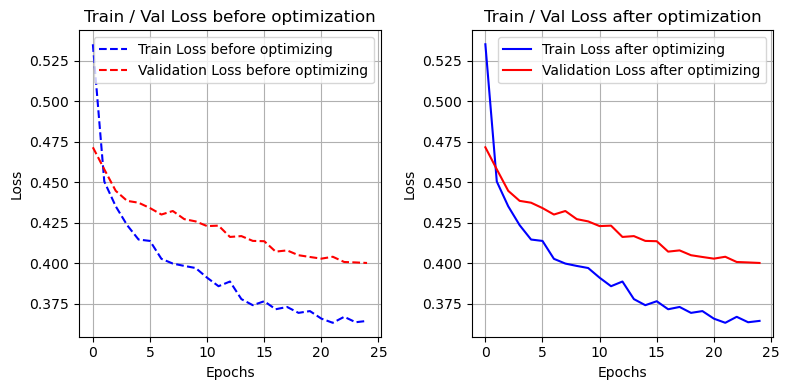

WARNING, after optimization, loss divergence is 0.035750359296798706, which greater than threshold of 0.01, please continue tuning this model.


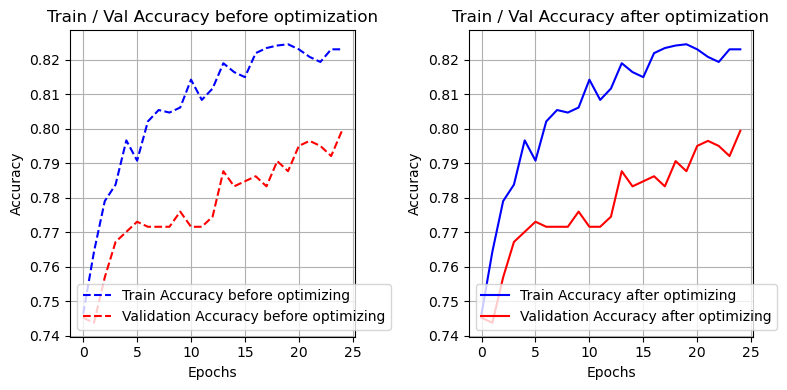

WARNING, after optimization, accuracy divergence is 0.023597776889801025, which greater than threshold of 0.01, please continue tuning this model.


In [203]:
# Call previously defined functions to create graphs that show how Training/Validation loss and accuracy converge
# It is important that the lines converge, if they do not, add more data, more epochs, or try different hyperparameter optimizations

# print current history values, use end=" " to print all output on single line
print(f"\n\ntrain_loss_history_unoptimized", end=" ") 
for value in train_loss_history_unoptimized: print(f"{value:.4f}", end=" ")
#
print(f"\n\ntrain_loss_history_optimized", end=" ") 
for value in train_loss_history_optimized: print(f"{value:.4f}", end=" ")
#
print(f"\n\nval_loss_history_unoptimized", end=" ") 
for value in val_loss_history_unoptimized: print(f"{value:.4f}", end=" ")
#
print(f"\n\nval_loss_history_optimized", end=" ") 
for value in val_loss_history_optimized: print(f"{value:.4f}", end=" ")


# sanity check to confirm the required values have already been collected, set to zeros if needed to avoid undef errors
if len(train_loss_history_unoptimized) != epoch_count: print("ERROR: incorrect len() of train_loss_history_unoptimized, resetting to all zeros") ; train_loss_history_unoptimized = [0] * epoch_count
if len(train_loss_history_optimized)   != epoch_count: print("ERROR: incorrect len() of train_loss_history_optimized,   resetting to all zeros") ; train_loss_history_optimized   = [0] * epoch_count
if len(val_loss_history_unoptimized)   != epoch_count: print("ERROR: incorrect len() of val_loss_history_unoptimized,   resetting to all zeros") ; val_loss_history_unoptimized   = [0] * epoch_count
if len(val_loss_history_optimized)     != epoch_count: print("ERROR: incorrect len() of  val_loss_history_optimized,    resetting to all zeros") ; val_loss_history_optimized     = [0] * epoch_count

# create the convergence graphs
plot_loss_history(train_loss_history_unoptimized, train_loss_history_optimized, val_loss_history_unoptimized, val_loss_history_optimized, epoch_count)
plot_accuracy_history(train_accuracy_history_unoptimized, train_accuracy_history_optimized, val_accuracy_history_unoptimized, val_accuracy_history_optimized, epoch_count)

### 2 hidden layers

In [205]:
# this variable determines which of the previously defined functions will be called
hidden_layers = 2

------------------------------------------
Performing GridSearchCV
Total number of combinations in the parameter grid: 1
Total number of cross validation folds: 10
parameter grid x CV folds = 1 x 10 = 10 GridSearchCV cycles
------------------------------------------
Fitting 10 folds for each of 1 candidates, totalling 10 fits
11/11 [==============================] - 1s 2ms/step
[CV] END ..............................dropout=0.1, units=32; total time=  16.3s
11/11 [==============================] - 1s 2ms/step
[CV] END ..............................dropout=0.1, units=32; total time=  13.9s
11/11 [==============================] - 1s 2ms/step
[CV] END ..............................dropout=0.1, units=32; total time=  14.2s
11/11 [==============================] - 1s 2ms/step
[CV] END ..............................dropout=0.1, units=32; total time=  15.7s
11/11 [==============================] - 1s 2ms/step
[CV] END ..............................dropout=0.1, units=32; total time=  14.7s
11

C:\Users\njeffrey\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

C:\Users\njeffrey\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.



-----------------------------------------
Cross validation scores: [0.85964912 0.83625731 0.84457478 0.85337243 0.84750733 0.81818182
 0.83577713 0.83870968 0.79765396 0.82404692]
Mean cross validation score: 0.835573047966936
Standard Deviation cross validation score: 0.017330452746722153
------------------------------------------
Evaluating the model on training data
107/107 [==============================] - 1s 2ms/step - loss: 0.3573 - accuracy: 0.8215
Train Loss: 0.35733217000961304
Train Accuracy: 0.8215122818946838
-----------------------------------------
Evaluating the model on test data
70/70 [==============================] - 0s 2ms/step - loss: 0.3641 - accuracy: 0.8085
Test Loss: 0.3641475737094879
Test Accuracy: 0.8084821701049805
-----------------------------------------
Evaluating the model on validation data
71/71 [==============================] - 0s 2ms/step - loss: 0.3682 - accuracy: 0.8014
Val Loss: 0.36824116110801697
Val Accuracy: 0.801427960395813
--------------

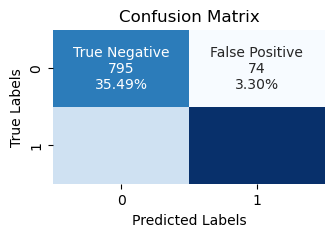




Confusion matrix

 [[ 795   74]
 [ 282 1089]]

True Negatives  (TN) =  795
False Positives (FP) =  74
False Negatives (FN) =  282
True Positives  (TP) =  1089


Accuracy:        0.8410714285714286
Sensitivity:     0.7943107221006565
Specificity:     0.9148446490218642
Geometric Mean:  0.8524499479585171


Precision:        0.8594766329446294
Recall:           0.8410714285714286
f1-score:         0.8430423222590041

------------------------------------------------

Current Time: 2024-05-15 22:28:18
The entire notebook runtime so far is 129 minutes


In [206]:
# This cell is the same for each of the different number of hidden layers

# Create an instance of the wrapper class, using the previously defined hidden_layers variable
model = KerasSimpleRNNWrapper()

# Create GridSearchCV instance
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_count, scoring=make_scorer(accuracy_score), verbose=epoch_verbosity)
# Perform grid search
print(f"------------------------------------------")
print(f"Performing GridSearchCV")
# Calculate the total number of combinations in GridSearchCV
total_combinations = 1
for param in param_grid:
    total_combinations *= len(param_grid[param])
print("Total number of combinations in the parameter grid:", total_combinations)
print("Total number of cross validation folds:", cv_count)
total_combinations_times_cv_count = total_combinations * cv_count
print(f"parameter grid x CV folds = {total_combinations} x {cv_count} = {total_combinations_times_cv_count} GridSearchCV cycles")
print(f"------------------------------------------")
grid_search_result = grid_search.fit(X_train_with_time_steps, y_train)


# Print best parameters and results
print("Best Parameters:", grid_search_result.best_params_)
print("Best Accuracy:", grid_search_result.best_score_)


# final cross validation
cross_val_score_result = cross_val_score(clf, X_train, y_train, cv=cv_count)
print(f"-----------------------------------------")
print(f"Cross validation scores: {cross_val_score_result}")
print(f"Mean cross validation score: {cross_val_score_result.mean()}")
print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")
simplernn_lstm_crossval_score_all  = cross_val_score_result         #save all folds in a list for later comparison
simplernn_lstm_crossval_score_mean = cross_val_score_result.mean()  #save mean   crossval score in a variable for later comparison
simplernn_lstm_crossval_score_std  = cross_val_score_result.std()   #save stddev crossval score in a variable for later comparison

# Evaluate the model on training data
print(f"------------------------------------------")
print(f"Evaluating the model on training data")
best_model = grid_search_result.best_estimator_
train_loss, train_accuracy = best_model.model.evaluate(X_train_with_time_steps, y_train)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)


# Evaluate the model on test data
print(f"-----------------------------------------")
print(f"Evaluating the model on test data")
test_loss, test_accuracy = best_model.model.evaluate(X_test_with_time_steps, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


# Evaluate the model on validation data
print(f"-----------------------------------------")
print(f"Evaluating the model on validation data")
val_loss, val_accuracy = best_model.model.evaluate(X_val_with_time_steps, y_val)
print("Val Loss:", val_loss)
print("Val Accuracy:", val_accuracy)
print(f"-----------------------------------------")


# save results calculated for this model for later comparison to other models
test_accuracy_simplernn_lstm_optimized  = test_accuracy
test_loss_simplernn_lstm_optimized      = test_loss
train_accuracy_simplernn_lstm_optimized = train_accuracy
train_loss_simplernn_lstm_optimized     = train_loss
val_accuracy_simplernn_lstm_optimized   = val_accuracy
val_loss_simplernn_lstm_optimized       = val_loss

# Extracting accuracy and loss history from the training, will be used later for graphing convergence
train_loss_history_optimized     = history.history['loss']
train_accuracy_history_optimized = history.history['accuracy']
val_loss_history_optimized       = history.history['val_loss']
val_accuracy_history_optimized   = history.history['val_accuracy']

# call previously defined function to create confusion matrix
cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# save results calculated for this model for later comparison to other models
accuracy_simplernn_lstm_optimized      = Accuracy
sensitivity_simplernn_lstm_optimized   = Sensitivity
specificity_simplernn_lstm_optimized   = Specificity
geometricmean_simplernn_lstm_optimized = GeometricMean
precision_simplernn_lstm_optimized     = Precision
recall_simplernn_lstm_optimized        = Recall
f1_simplernn_lstm_optimized            = F1

# show a running total of elapsed time for the entire notebook
show_elapsed_time()



train_loss_history_unoptimized 0.5352 0.4505 0.4353 0.4236 0.4147 0.4139 0.4028 0.3999 0.3984 0.3971 0.3912 0.3859 0.3888 0.3780 0.3742 0.3766 0.3717 0.3731 0.3695 0.3706 0.3659 0.3633 0.3670 0.3637 0.3645 

train_loss_history_optimized 0.5352 0.4505 0.4353 0.4236 0.4147 0.4139 0.4028 0.3999 0.3984 0.3971 0.3912 0.3859 0.3888 0.3780 0.3742 0.3766 0.3717 0.3731 0.3695 0.3706 0.3659 0.3633 0.3670 0.3637 0.3645 

val_loss_history_unoptimized 0.4716 0.4581 0.4448 0.4386 0.4375 0.4341 0.4302 0.4323 0.4273 0.4259 0.4230 0.4233 0.4163 0.4168 0.4139 0.4137 0.4073 0.4080 0.4050 0.4040 0.4029 0.4041 0.4009 0.4006 0.4003 

val_loss_history_optimized 0.4716 0.4581 0.4448 0.4386 0.4375 0.4341 0.4302 0.4323 0.4273 0.4259 0.4230 0.4233 0.4163 0.4168 0.4139 0.4137 0.4073 0.4080 0.4050 0.4040 0.4029 0.4041 0.4009 0.4006 0.4003 

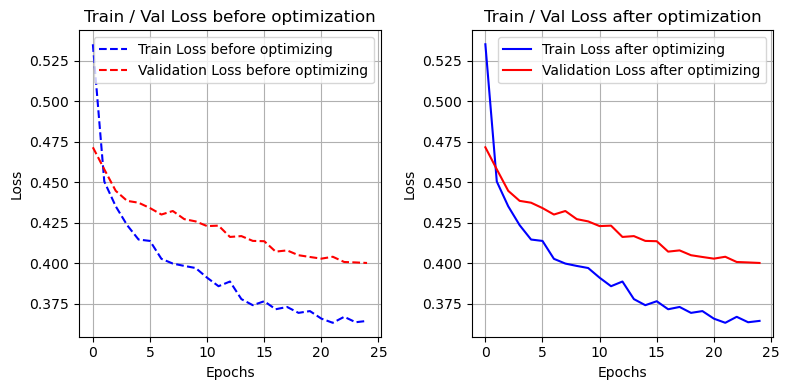

WARNING, after optimization, loss divergence is 0.035750359296798706, which greater than threshold of 0.01, please continue tuning this model.


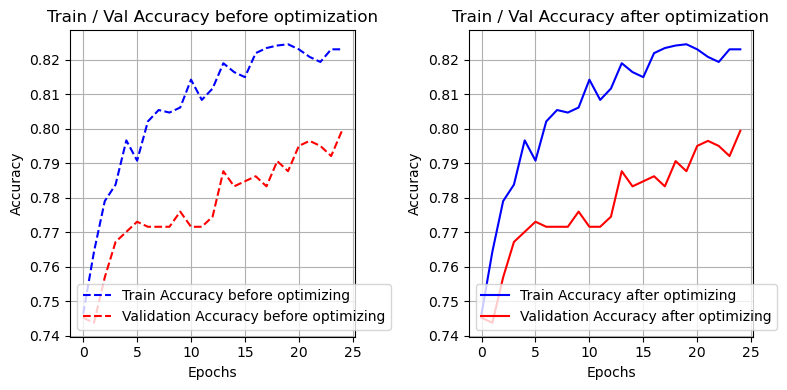

WARNING, after optimization, accuracy divergence is 0.023597776889801025, which greater than threshold of 0.01, please continue tuning this model.


In [159]:
# Call previously defined functions to create graphs that show how Training/Validation loss and accuracy converge
# It is important that the lines converge, if they do not, add more data, more epochs, or try different hyperparameter optimizations

# print current history values, use end=" " to print all output on single line
print(f"\n\ntrain_loss_history_unoptimized", end=" ") 
for value in train_loss_history_unoptimized: print(f"{value:.4f}", end=" ")
#
print(f"\n\ntrain_loss_history_optimized", end=" ") 
for value in train_loss_history_optimized: print(f"{value:.4f}", end=" ")
#
print(f"\n\nval_loss_history_unoptimized", end=" ") 
for value in val_loss_history_unoptimized: print(f"{value:.4f}", end=" ")
#
print(f"\n\nval_loss_history_optimized", end=" ") 
for value in val_loss_history_optimized: print(f"{value:.4f}", end=" ")


# sanity check to confirm the required values have already been collected, set to zeros if needed to avoid undef errors
if len(train_loss_history_unoptimized) != epoch_count: print("ERROR: incorrect len() of train_loss_history_unoptimized, resetting to all zeros") ; train_loss_history_unoptimized = [0] * epoch_count
if len(train_loss_history_optimized)   != epoch_count: print("ERROR: incorrect len() of train_loss_history_optimized,   resetting to all zeros") ; train_loss_history_optimized   = [0] * epoch_count
if len(val_loss_history_unoptimized)   != epoch_count: print("ERROR: incorrect len() of val_loss_history_unoptimized,   resetting to all zeros") ; val_loss_history_unoptimized   = [0] * epoch_count
if len(val_loss_history_optimized)     != epoch_count: print("ERROR: incorrect len() of  val_loss_history_optimized,    resetting to all zeros") ; val_loss_history_optimized     = [0] * epoch_count

# create the convergence graphs
plot_loss_history(train_loss_history_unoptimized, train_loss_history_optimized, val_loss_history_unoptimized, val_loss_history_optimized, epoch_count)
plot_accuracy_history(train_accuracy_history_unoptimized, train_accuracy_history_optimized, val_accuracy_history_unoptimized, val_accuracy_history_optimized, epoch_count)

### 3 hidden layers

In [208]:
# this variable determines which of the previously defined functions will be called
hidden_layers = 3

------------------------------------------
Performing GridSearchCV
Total number of combinations in the parameter grid: 1
Total number of cross validation folds: 10
parameter grid x CV folds = 1 x 10 = 10 GridSearchCV cycles
------------------------------------------
Fitting 10 folds for each of 1 candidates, totalling 10 fits
11/11 [==============================] - 2s 2ms/step
[CV] END ..............................dropout=0.1, units=32; total time=  18.9s
11/11 [==============================] - 1s 2ms/step
[CV] END ..............................dropout=0.1, units=32; total time=  20.4s
11/11 [==============================] - 1s 2ms/step
[CV] END ..............................dropout=0.1, units=32; total time=  19.6s
11/11 [==============================] - 1s 2ms/step
[CV] END ..............................dropout=0.1, units=32; total time=  18.4s
11/11 [==============================] - 1s 2ms/step
[CV] END ..............................dropout=0.1, units=32; total time=  18.5s
11

C:\Users\njeffrey\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

C:\Users\njeffrey\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.



-----------------------------------------
Cross validation scores: [0.85964912 0.83625731 0.84457478 0.85337243 0.84750733 0.81818182
 0.83577713 0.83870968 0.79765396 0.82404692]
Mean cross validation score: 0.835573047966936
Standard Deviation cross validation score: 0.017330452746722153
------------------------------------------
Evaluating the model on training data
107/107 [==============================] - 2s 2ms/step - loss: 0.3667 - accuracy: 0.8224
Train Loss: 0.3667459785938263
Train Accuracy: 0.8223915696144104
-----------------------------------------
Evaluating the model on test data
70/70 [==============================] - 0s 2ms/step - loss: 0.3783 - accuracy: 0.8040
Test Loss: 0.3782508969306946
Test Accuracy: 0.8040178418159485
-----------------------------------------
Evaluating the model on validation data
71/71 [==============================] - 0s 2ms/step - loss: 0.3858 - accuracy: 0.7885
Val Loss: 0.38581424951553345
Val Accuracy: 0.7884872555732727
--------------

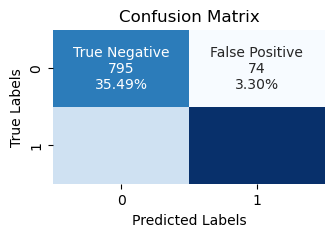




Confusion matrix

 [[ 795   74]
 [ 282 1089]]

True Negatives  (TN) =  795
False Positives (FP) =  74
False Negatives (FN) =  282
True Positives  (TP) =  1089


Accuracy:        0.8410714285714286
Sensitivity:     0.7943107221006565
Specificity:     0.9148446490218642
Geometric Mean:  0.8524499479585171


Precision:        0.8594766329446294
Recall:           0.8410714285714286
f1-score:         0.8430423222590041

------------------------------------------------

Current Time: 2024-05-15 22:48:20
The entire notebook runtime so far is 149 minutes


In [209]:
# This cell is the same for each of the different number of hidden layers

# Create an instance of the wrapper class, using the previously defined hidden_layers variable
model = KerasSimpleRNNWrapper()

# Create GridSearchCV instance
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_count, scoring=make_scorer(accuracy_score), verbose=epoch_verbosity)
# Perform grid search
print(f"------------------------------------------")
print(f"Performing GridSearchCV")
# Calculate the total number of combinations in GridSearchCV
total_combinations = 1
for param in param_grid:
    total_combinations *= len(param_grid[param])
print("Total number of combinations in the parameter grid:", total_combinations)
print("Total number of cross validation folds:", cv_count)
total_combinations_times_cv_count = total_combinations * cv_count
print(f"parameter grid x CV folds = {total_combinations} x {cv_count} = {total_combinations_times_cv_count} GridSearchCV cycles")
print(f"------------------------------------------")
grid_search_result = grid_search.fit(X_train_with_time_steps, y_train)


# Print best parameters and results
print("Best Parameters:", grid_search_result.best_params_)
print("Best Accuracy:", grid_search_result.best_score_)


# final cross validation
cross_val_score_result = cross_val_score(clf, X_train, y_train, cv=cv_count)
print(f"-----------------------------------------")
print(f"Cross validation scores: {cross_val_score_result}")
print(f"Mean cross validation score: {cross_val_score_result.mean()}")
print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")
simplernn_lstm_crossval_score_all  = cross_val_score_result         #save all folds in a list for later comparison
simplernn_lstm_crossval_score_mean = cross_val_score_result.mean()  #save mean   crossval score in a variable for later comparison
simplernn_lstm_crossval_score_std  = cross_val_score_result.std()   #save stddev crossval score in a variable for later comparison

# Evaluate the model on training data
print(f"------------------------------------------")
print(f"Evaluating the model on training data")
best_model = grid_search_result.best_estimator_
train_loss, train_accuracy = best_model.model.evaluate(X_train_with_time_steps, y_train)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)


# Evaluate the model on test data
print(f"-----------------------------------------")
print(f"Evaluating the model on test data")
test_loss, test_accuracy = best_model.model.evaluate(X_test_with_time_steps, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


# Evaluate the model on validation data
print(f"-----------------------------------------")
print(f"Evaluating the model on validation data")
val_loss, val_accuracy = best_model.model.evaluate(X_val_with_time_steps, y_val)
print("Val Loss:", val_loss)
print("Val Accuracy:", val_accuracy)
print(f"-----------------------------------------")


# save results calculated for this model for later comparison to other models
test_accuracy_simplernn_lstm_optimized  = test_accuracy
test_loss_simplernn_lstm_optimized      = test_loss
train_accuracy_simplernn_lstm_optimized = train_accuracy
train_loss_simplernn_lstm_optimized     = train_loss
val_accuracy_simplernn_lstm_optimized   = val_accuracy
val_loss_simplernn_lstm_optimized       = val_loss

# Extracting accuracy and loss history from the training, will be used later for graphing convergence
train_loss_history_optimized     = history.history['loss']
train_accuracy_history_optimized = history.history['accuracy']
val_loss_history_optimized       = history.history['val_loss']
val_accuracy_history_optimized   = history.history['val_accuracy']

# call previously defined function to create confusion matrix
cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# save results calculated for this model for later comparison to other models
accuracy_simplernn_lstm_optimized      = Accuracy
sensitivity_simplernn_lstm_optimized   = Sensitivity
specificity_simplernn_lstm_optimized   = Specificity
geometricmean_simplernn_lstm_optimized = GeometricMean
precision_simplernn_lstm_optimized     = Precision
recall_simplernn_lstm_optimized        = Recall
f1_simplernn_lstm_optimized            = F1

# show a running total of elapsed time for the entire notebook
show_elapsed_time()



train_loss_history_unoptimized 0.5352 0.4505 0.4353 0.4236 0.4147 0.4139 0.4028 0.3999 0.3984 0.3971 0.3912 0.3859 0.3888 0.3780 0.3742 0.3766 0.3717 0.3731 0.3695 0.3706 0.3659 0.3633 0.3670 0.3637 0.3645 

train_loss_history_optimized 0.5352 0.4505 0.4353 0.4236 0.4147 0.4139 0.4028 0.3999 0.3984 0.3971 0.3912 0.3859 0.3888 0.3780 0.3742 0.3766 0.3717 0.3731 0.3695 0.3706 0.3659 0.3633 0.3670 0.3637 0.3645 

val_loss_history_unoptimized 0.4716 0.4581 0.4448 0.4386 0.4375 0.4341 0.4302 0.4323 0.4273 0.4259 0.4230 0.4233 0.4163 0.4168 0.4139 0.4137 0.4073 0.4080 0.4050 0.4040 0.4029 0.4041 0.4009 0.4006 0.4003 

val_loss_history_optimized 0.4716 0.4581 0.4448 0.4386 0.4375 0.4341 0.4302 0.4323 0.4273 0.4259 0.4230 0.4233 0.4163 0.4168 0.4139 0.4137 0.4073 0.4080 0.4050 0.4040 0.4029 0.4041 0.4009 0.4006 0.4003 

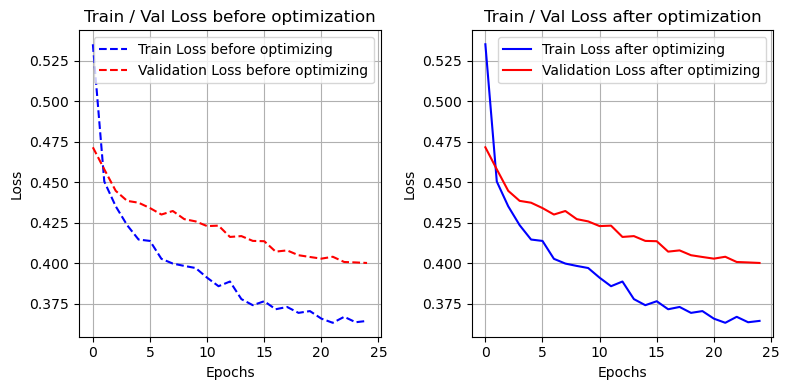

WARNING, after optimization, loss divergence is 0.035750359296798706, which greater than threshold of 0.01, please continue tuning this model.


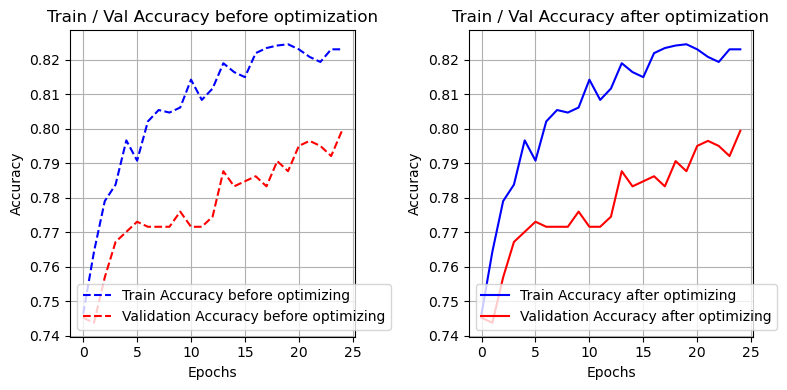

WARNING, after optimization, accuracy divergence is 0.023597776889801025, which greater than threshold of 0.01, please continue tuning this model.


In [210]:
# Call previously defined functions to create graphs that show how Training/Validation loss and accuracy converge
# It is important that the lines converge, if they do not, add more data, more epochs, or try different hyperparameter optimizations

# print current history values, use end=" " to print all output on single line
print(f"\n\ntrain_loss_history_unoptimized", end=" ") 
for value in train_loss_history_unoptimized: print(f"{value:.4f}", end=" ")
#
print(f"\n\ntrain_loss_history_optimized", end=" ") 
for value in train_loss_history_optimized: print(f"{value:.4f}", end=" ")
#
print(f"\n\nval_loss_history_unoptimized", end=" ") 
for value in val_loss_history_unoptimized: print(f"{value:.4f}", end=" ")
#
print(f"\n\nval_loss_history_optimized", end=" ") 
for value in val_loss_history_optimized: print(f"{value:.4f}", end=" ")


# sanity check to confirm the required values have already been collected, set to zeros if needed to avoid undef errors
if len(train_loss_history_unoptimized) != epoch_count: print("ERROR: incorrect len() of train_loss_history_unoptimized, resetting to all zeros") ; train_loss_history_unoptimized = [0] * epoch_count
if len(train_loss_history_optimized)   != epoch_count: print("ERROR: incorrect len() of train_loss_history_optimized,   resetting to all zeros") ; train_loss_history_optimized   = [0] * epoch_count
if len(val_loss_history_unoptimized)   != epoch_count: print("ERROR: incorrect len() of val_loss_history_unoptimized,   resetting to all zeros") ; val_loss_history_unoptimized   = [0] * epoch_count
if len(val_loss_history_optimized)     != epoch_count: print("ERROR: incorrect len() of  val_loss_history_optimized,    resetting to all zeros") ; val_loss_history_optimized     = [0] * epoch_count

# create the convergence graphs
plot_loss_history(train_loss_history_unoptimized, train_loss_history_optimized, val_loss_history_unoptimized, val_loss_history_optimized, epoch_count)
plot_accuracy_history(train_accuracy_history_unoptimized, train_accuracy_history_optimized, val_accuracy_history_unoptimized, val_accuracy_history_optimized, epoch_count)

### 4 hidden layers

In [212]:
# this variable determines which of the previously defined functions will be called
hidden_layers = 4

------------------------------------------
Performing GridSearchCV
Total number of combinations in the parameter grid: 1
Total number of cross validation folds: 10
parameter grid x CV folds = 1 x 10 = 10 GridSearchCV cycles
------------------------------------------
Fitting 10 folds for each of 1 candidates, totalling 10 fits
11/11 [==============================] - 1s 2ms/step
[CV] END ..............................dropout=0.1, units=32; total time=  20.3s
11/11 [==============================] - 2s 2ms/step
[CV] END ..............................dropout=0.1, units=32; total time=  20.4s
11/11 [==============================] - 2s 2ms/step
[CV] END ..............................dropout=0.1, units=32; total time=  20.4s
11/11 [==============================] - 1s 2ms/step
[CV] END ..............................dropout=0.1, units=32; total time=  19.8s
11/11 [==============================] - 1s 2ms/step
[CV] END ..............................dropout=0.1, units=32; total time=  19.3s
11

C:\Users\njeffrey\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

C:\Users\njeffrey\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.



-----------------------------------------
Cross validation scores: [0.85964912 0.83625731 0.84457478 0.85337243 0.84750733 0.81818182
 0.83577713 0.83870968 0.79765396 0.82404692]
Mean cross validation score: 0.835573047966936
Standard Deviation cross validation score: 0.017330452746722153
------------------------------------------
Evaluating the model on training data
107/107 [==============================] - 2s 2ms/step - loss: 0.3693 - accuracy: 0.8145
Train Loss: 0.36925098299980164
Train Accuracy: 0.81447833776474
-----------------------------------------
Evaluating the model on test data
70/70 [==============================] - 0s 2ms/step - loss: 0.3720 - accuracy: 0.8045
Test Loss: 0.3719976544380188
Test Accuracy: 0.8044642806053162
-----------------------------------------
Evaluating the model on validation data
71/71 [==============================] - 0s 2ms/step - loss: 0.3770 - accuracy: 0.7952
Val Loss: 0.37696176767349243
Val Accuracy: 0.7951807379722595
---------------

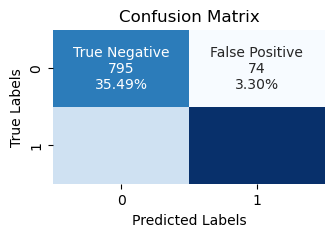




Confusion matrix

 [[ 795   74]
 [ 282 1089]]

True Negatives  (TN) =  795
False Positives (FP) =  74
False Negatives (FN) =  282
True Positives  (TP) =  1089


Accuracy:        0.8410714285714286
Sensitivity:     0.7943107221006565
Specificity:     0.9148446490218642
Geometric Mean:  0.8524499479585171


Precision:        0.8594766329446294
Recall:           0.8410714285714286
f1-score:         0.8430423222590041

------------------------------------------------

Current Time: 2024-05-15 22:52:57
The entire notebook runtime so far is 153 minutes


In [213]:
# This cell is the same for each of the different number of hidden layers

# Create an instance of the wrapper class, using the previously defined hidden_layers variable
model = KerasSimpleRNNWrapper()

# Create GridSearchCV instance
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_count, scoring=make_scorer(accuracy_score), verbose=epoch_verbosity)
# Perform grid search
print(f"------------------------------------------")
print(f"Performing GridSearchCV")
# Calculate the total number of combinations in GridSearchCV
total_combinations = 1
for param in param_grid:
    total_combinations *= len(param_grid[param])
print("Total number of combinations in the parameter grid:", total_combinations)
print("Total number of cross validation folds:", cv_count)
total_combinations_times_cv_count = total_combinations * cv_count
print(f"parameter grid x CV folds = {total_combinations} x {cv_count} = {total_combinations_times_cv_count} GridSearchCV cycles")
print(f"------------------------------------------")
grid_search_result = grid_search.fit(X_train_with_time_steps, y_train)


# Print best parameters and results
print("Best Parameters:", grid_search_result.best_params_)
print("Best Accuracy:", grid_search_result.best_score_)


# final cross validation
cross_val_score_result = cross_val_score(clf, X_train, y_train, cv=cv_count)
print(f"-----------------------------------------")
print(f"Cross validation scores: {cross_val_score_result}")
print(f"Mean cross validation score: {cross_val_score_result.mean()}")
print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")
simplernn_lstm_crossval_score_all  = cross_val_score_result         #save all folds in a list for later comparison
simplernn_lstm_crossval_score_mean = cross_val_score_result.mean()  #save mean   crossval score in a variable for later comparison
simplernn_lstm_crossval_score_std  = cross_val_score_result.std()   #save stddev crossval score in a variable for later comparison

# Evaluate the model on training data
print(f"------------------------------------------")
print(f"Evaluating the model on training data")
best_model = grid_search_result.best_estimator_
train_loss, train_accuracy = best_model.model.evaluate(X_train_with_time_steps, y_train)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)


# Evaluate the model on test data
print(f"-----------------------------------------")
print(f"Evaluating the model on test data")
test_loss, test_accuracy = best_model.model.evaluate(X_test_with_time_steps, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


# Evaluate the model on validation data
print(f"-----------------------------------------")
print(f"Evaluating the model on validation data")
val_loss, val_accuracy = best_model.model.evaluate(X_val_with_time_steps, y_val)
print("Val Loss:", val_loss)
print("Val Accuracy:", val_accuracy)
print(f"-----------------------------------------")


# save results calculated for this model for later comparison to other models
test_accuracy_simplernn_lstm_optimized  = test_accuracy
test_loss_simplernn_lstm_optimized      = test_loss
train_accuracy_simplernn_lstm_optimized = train_accuracy
train_loss_simplernn_lstm_optimized     = train_loss
val_accuracy_simplernn_lstm_optimized   = val_accuracy
val_loss_simplernn_lstm_optimized       = val_loss

# Extracting accuracy and loss history from the training, will be used later for graphing convergence
train_loss_history_optimized     = history.history['loss']
train_accuracy_history_optimized = history.history['accuracy']
val_loss_history_optimized       = history.history['val_loss']
val_accuracy_history_optimized   = history.history['val_accuracy']

# call previously defined function to create confusion matrix
cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# save results calculated for this model for later comparison to other models
accuracy_simplernn_lstm_optimized      = Accuracy
sensitivity_simplernn_lstm_optimized   = Sensitivity
specificity_simplernn_lstm_optimized   = Specificity
geometricmean_simplernn_lstm_optimized = GeometricMean
precision_simplernn_lstm_optimized     = Precision
recall_simplernn_lstm_optimized        = Recall
f1_simplernn_lstm_optimized            = F1

# show a running total of elapsed time for the entire notebook
show_elapsed_time()



train_loss_history_unoptimized 0.5352 0.4505 0.4353 0.4236 0.4147 0.4139 0.4028 0.3999 0.3984 0.3971 0.3912 0.3859 0.3888 0.3780 0.3742 0.3766 0.3717 0.3731 0.3695 0.3706 0.3659 0.3633 0.3670 0.3637 0.3645 

train_loss_history_optimized 0.5352 0.4505 0.4353 0.4236 0.4147 0.4139 0.4028 0.3999 0.3984 0.3971 0.3912 0.3859 0.3888 0.3780 0.3742 0.3766 0.3717 0.3731 0.3695 0.3706 0.3659 0.3633 0.3670 0.3637 0.3645 

val_loss_history_unoptimized 0.4716 0.4581 0.4448 0.4386 0.4375 0.4341 0.4302 0.4323 0.4273 0.4259 0.4230 0.4233 0.4163 0.4168 0.4139 0.4137 0.4073 0.4080 0.4050 0.4040 0.4029 0.4041 0.4009 0.4006 0.4003 

val_loss_history_optimized 0.4716 0.4581 0.4448 0.4386 0.4375 0.4341 0.4302 0.4323 0.4273 0.4259 0.4230 0.4233 0.4163 0.4168 0.4139 0.4137 0.4073 0.4080 0.4050 0.4040 0.4029 0.4041 0.4009 0.4006 0.4003 

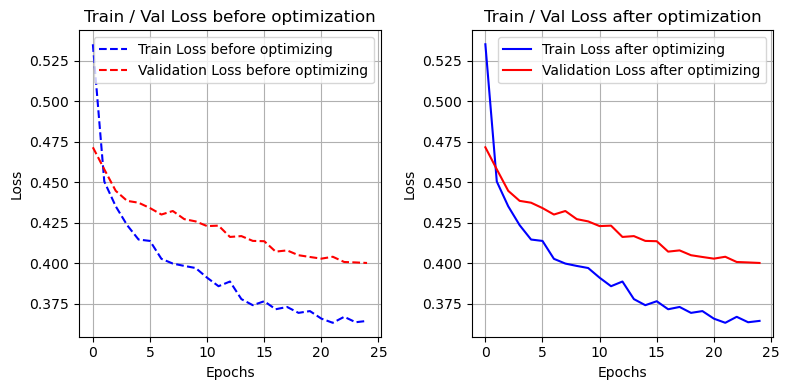

WARNING, after optimization, loss divergence is 0.035750359296798706, which greater than threshold of 0.01, please continue tuning this model.


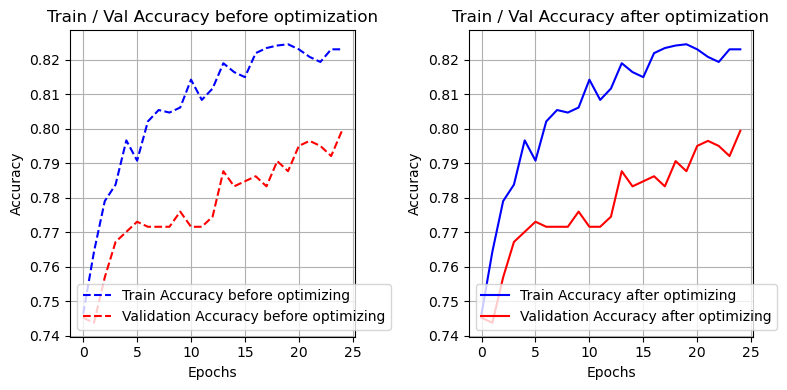

WARNING, after optimization, accuracy divergence is 0.023597776889801025, which greater than threshold of 0.01, please continue tuning this model.


In [214]:
# Call previously defined functions to create graphs that show how Training/Validation loss and accuracy converge
# It is important that the lines converge, if they do not, add more data, more epochs, or try different hyperparameter optimizations

# print current history values, use end=" " to print all output on single line
print(f"\n\ntrain_loss_history_unoptimized", end=" ") 
for value in train_loss_history_unoptimized: print(f"{value:.4f}", end=" ")
#
print(f"\n\ntrain_loss_history_optimized", end=" ") 
for value in train_loss_history_optimized: print(f"{value:.4f}", end=" ")
#
print(f"\n\nval_loss_history_unoptimized", end=" ") 
for value in val_loss_history_unoptimized: print(f"{value:.4f}", end=" ")
#
print(f"\n\nval_loss_history_optimized", end=" ") 
for value in val_loss_history_optimized: print(f"{value:.4f}", end=" ")


# sanity check to confirm the required values have already been collected, set to zeros if needed to avoid undef errors
if len(train_loss_history_unoptimized) != epoch_count: print("ERROR: incorrect len() of train_loss_history_unoptimized, resetting to all zeros") ; train_loss_history_unoptimized = [0] * epoch_count
if len(train_loss_history_optimized)   != epoch_count: print("ERROR: incorrect len() of train_loss_history_optimized,   resetting to all zeros") ; train_loss_history_optimized   = [0] * epoch_count
if len(val_loss_history_unoptimized)   != epoch_count: print("ERROR: incorrect len() of val_loss_history_unoptimized,   resetting to all zeros") ; val_loss_history_unoptimized   = [0] * epoch_count
if len(val_loss_history_optimized)     != epoch_count: print("ERROR: incorrect len() of  val_loss_history_optimized,    resetting to all zeros") ; val_loss_history_optimized     = [0] * epoch_count

# create the convergence graphs
plot_loss_history(train_loss_history_unoptimized, train_loss_history_optimized, val_loss_history_unoptimized, val_loss_history_optimized, epoch_count)
plot_accuracy_history(train_accuracy_history_unoptimized, train_accuracy_history_optimized, val_accuracy_history_unoptimized, val_accuracy_history_optimized, epoch_count)

## Gated Recurrent Unit (GRU)
### (needed reshaping to add time steps)

Note that it is possible to combine a Gated Recurrent Unit (GRU) layer with a Long Short-Term Memory (LSTM) layer in a neural network architecture. However, it's less common to do so because both GRU and LSTM layers are types of recurrent neural network (RNN) layers designed to address the vanishing gradient problem and capture long-term dependencies in sequential data.

Typically, you would choose either GRU or LSTM based on the specific requirements of your task and the characteristics of your data. Both GRU and LSTM have similar capabilities, but they have slightly different architectures and computational properties.

If you choose to combine GRU and LSTM layers in a neural network, you would stack them sequentially or in parallel depending on your design choices. However, it's important to consider the computational complexity and potential overfitting when stacking multiple types of RNN layers.

In most cases, using either GRU or LSTM layers alone is sufficient to model sequential data effectively.

### default params

In [ ]:
# #from tensorflow.keras.layers import Dense, GRU



# # Define input shape based on the features in X_train
# input_shape = X_train_with_time_steps.shape[1:]

# # Define the model
# model = Sequential([
#     GRU(units=64, input_shape=input_shape),
#     Dropout(0.5),
#     Dense(32, activation='relu'),
#     Dropout(0.5),
#     Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
# ])

# # Compile the model
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# # Print model summary
# print(f"-----------------------------------------")
# print(f"Model Summary")
# print(model.summary())

# # Train the model
# print(f"-----------------------------------------")
# print(f"Training the model")
# history = model.fit(X_train_with_time_steps, y_train, epochs=epoch_count, batch_size=32, validation_split=0.2)

# # Evaluate the model on training data
# print(f"-----------------------------------------")
# print(f"Evaluating the model on training data")
# train_loss, train_accuracy = model.evaluate(X_train_with_time_steps, y_train)
# print("Training Loss:", train_loss)
# print("Training Accuracy:", train_accuracy)


# # Evaluate the model on test data
# print(f"-----------------------------------------")
# print(f"Evaluating the model on test data")
# test_loss, test_accuracy = model.evaluate(X_test_with_time_steps, y_test)
# print("Test Loss:", test_loss)
# print("Test Accuracy:", test_accuracy)


# # Evaluate the model on validation data
# print(f"-----------------------------------------")
# print(f"Evaluating the model on validation data")
# val_loss, val_accuracy = model.evaluate(X_val_with_time_steps, y_val)
# print("Val Loss:", val_loss)
# print("Val Accuracy:", val_accuracy)
# print(f"-----------------------------------------")


# # save results calculated for this model for later comparison to other models
# test_accuracy_gru_unoptimized  = test_accuracy
# test_loss_gru_unoptimized      = test_loss
# train_accuracy_gru_unoptimized = train_accuracy
# train_loss_gru_unoptimized     = train_loss
# val_accuracy_gru_unoptimized   = val_accuracy
# val_loss_gru_unoptimized       = val_loss

# # call previously defined function to create confusion matrix
# cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# # save results calculated for this model for later comparison to other models
# accuracy_gru_unoptimized      = Accuracy
# sensitivity_gru_unoptimized   = Sensitivity
# specificity_gru_unoptimized   = Specificity
# geometricmean_gru_unoptimized = GeometricMean
# precision_gru_unoptimized     = Precision
# recall_gru_unoptimized        = Recall
# f1_gru_unoptimized            = F1

# # show a running total of elapsed time for the entire notebook
# show_elapsed_time()

### optimized params
Gated Recurrent Unit (GRU)

In [ ]:
# Sanity check to confirm X_train and y_train have equal number of samples
print(f"X_train_with_time_steps has ", len(X_train_with_time_steps), "samples")
print(f"y_train                 has ", len(y_train),                 "samples")
if ( len(X_train_with_time_steps) != len(y_train) ):
  raise ValueError ("X_train_with_time_steps and y_train are different lengths, please investigate!")


In [ ]:
# # NOTE: Crashed on this step after using all available RAM!  2025-04-19

# # GRU hyperparameter optimization

# #import numpy as np
# #from sklearn.model_selection import GridSearchCV
# #from tensorflow.keras.models import Sequential
# #from tensorflow.keras.layers import Dense, GRU, Dropout
# #from sklearn.metrics import make_scorer, accuracy_score

# # Define input shape based on the features in X_train
# input_shape = (X_train_with_time_steps.shape[1], X_train_with_time_steps.shape[2])  # Assuming X_train is 3D

# # Define a function to create a model
# def create_model(units=64, dropout=0.5):
#     model = Sequential([
#         GRU(units, input_shape=input_shape),
#         Dropout(dropout),
#         Dense(32, activation='relu'),
#         Dropout(0.5),
#         Dense(1, activation='sigmoid')
#     ])
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# # Create a wrapper class around the Keras model
# class KerasGRUWrapper:
#     def __init__(self, units=64, dropout=0.5, epochs=epoch_count, batch_size=32, verbose=0):
#         self.units = units
#         self.dropout = dropout
#         self.epochs = epochs
#         self.batch_size = batch_size
#         self.verbose = verbose
#         self.model = None

#     def fit(self, X, y):
#         self.model = create_model(units=self.units, dropout=self.dropout)
#         self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)

#     def predict(self, X):
#         return (self.model.predict(X) > 0.5).astype(int)

#     def get_params(self, deep=True):
#         return {
#             'units': self.units,
#             'dropout': self.dropout,
#             'epochs': self.epochs,
#             'batch_size': self.batch_size,
#             'verbose': self.verbose
#         }

#     def set_params(self, **params):
#         for param, value in params.items():
#             setattr(self, param, value)
#         return self

# # Create an instance of the wrapper class
# model = KerasGRUWrapper()

# # Define the hyperparameters grid to search
# #param_grid = {
# #    'units': [32, 64, 128],
# #    'dropout': [0.3, 0.5, 0.7]
# #}
# param_grid = {          #smaller faster version for testing
#     'units': [64],
#     'dropout': [0.5]
# }

# # Create GridSearchCV instance
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_count, scoring=make_scorer(accuracy_score), verbose=epoch_verbosity)

# # Perform grid search
# print(f"Performing grid search")
# grid_search_result = grid_search.fit(X_train_with_time_steps, y_train)

# # Print best parameters and results
# print("Best Parameters:", grid_search_result.best_params_)
# print("Best Accuracy:", grid_search_result.best_score_)

# # final cross validation
# cross_val_score_result = cross_val_score(clf, X_train, y_train, cv=cv_count)
# print(f"-----------------------------------------")
# print(f"Cross validation scores: {cross_val_score_result}")
# print(f"Mean cross validation score: {cross_val_score_result.mean()}")
# print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")
# gru_crossval_score_all  = cross_val_score_result         #save all folds in a list for later comparison
# gru_crossval_score_mean = cross_val_score_result.mean()  #save mean   crossval score in a variable for later comparison
# gru_crossval_score_std  = cross_val_score_result.std()   #save stddev crossval score in a variable for later comparison

# # Evaluate the model on training data
# print(f"------------------------------------------")
# print(f"Evaluating the model on training data")
# best_model = grid_search_result.best_estimator_
# train_loss, train_accuracy = best_model.model.evaluate(X_train_with_time_steps, y_train)
# print("Train Loss:", train_loss)
# print("Train Accuracy:", train_accuracy)


# # Evaluate the model on test data
# print(f"-----------------------------------------")
# print(f"Evaluating the model on test data")
# test_loss, test_accuracy = best_model.model.evaluate(X_test_with_time_steps, y_test)
# print("Test Loss:", test_loss)
# print("Test Accuracy:", test_accuracy)


# # Evaluate the model on validation data
# print(f"-----------------------------------------")
# print(f"Evaluating the model on validation data")
# val_loss, val_accuracy = best_model.model.evaluate(X_val_with_time_steps, y_val)
# print("Val Loss:", val_loss)
# print("Val Accuracy:", val_accuracy)
# print(f"-----------------------------------------")


# # save results calculated for this model for later comparison to other models
# test_accuracy_gru_optimized  = test_accuracy
# test_loss_gru_optimized      = test_loss
# train_accuracy_gru_optimized = train_accuracy
# train_loss_gru_optimized     = train_loss
# val_accuracy_gru_optimized   = val_accuracy
# val_loss_gru_optimized       = val_loss

# # Extracting accuracy and loss history from the training, will be used later for graphing convergence
# train_loss_history_optimized     = history.history['loss']
# train_accuracy_history_optimized = history.history['accuracy']
# val_loss_history_optimized       = history.history['val_loss']
# val_accuracy_history_optimized   = history.history['val_accuracy']


# # call previously defined function to create confusion matrix
# cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# # save results calculated for this model for later comparison to other models
# accuracy_gru_optimized      = Accuracy
# sensitivity_gru_optimized   = Sensitivity
# specificity_gru_optimized   = Specificity
# geometricmean_gru_optimized = GeometricMean
# precision_gru_optimized     = Precision
# recall_gru_optimized        = Recall
# f1_gru_optimized            = F1

# # show a running total of elapsed time for the entire notebook
# show_elapsed_time()

In [ ]:
# Call previously defined functions to create graphs that show how Training/Validation loss and accuracy converge
# It is important that the lines converge, if they do not, add more data, more epochs, or try different hyperparameter optimizations

# print current history values, use end=" " to print all output on single line
print(f"\n\ntrain_loss_history_unoptimized", end=" ") 
for value in train_loss_history_unoptimized: print(f"{value:.4f}", end=" ")
#
print(f"\n\ntrain_loss_history_optimized", end=" ") 
for value in train_loss_history_optimized: print(f"{value:.4f}", end=" ")
#
print(f"\n\nval_loss_history_unoptimized", end=" ") 
for value in val_loss_history_unoptimized: print(f"{value:.4f}", end=" ")
#
print(f"\n\nval_loss_history_optimized", end=" ") 
for value in val_loss_history_optimized: print(f"{value:.4f}", end=" ")


#print(f"\ntrain_loss_history_optimized")  ; for value in train_loss_history_unoptimized: print(f"{value:.4f}"))
#print(f"\nval_loss_history_unoptimized")  ; for value in train_loss_history_unoptimized: print(f"{value:.4f}"))
#print(f"\nval_loss_history_optimized")    ; for value in train_loss_history_unoptimized: print(f"{value:.4f}"))

# sanity check to confirm the required values have already been collected, set to zeros if needed to avoid undef errors
if len(train_loss_history_unoptimized) != epoch_count: print("ERROR: incorrect len() of train_loss_history_unoptimized, resetting to all zeros") ; train_loss_history_unoptimized = [0] * epoch_count
if len(train_loss_history_optimized)   != epoch_count: print("ERROR: incorrect len() of train_loss_history_optimized,   resetting to all zeros") ; train_loss_history_optimized   = [0] * epoch_count
if len(val_loss_history_unoptimized)   != epoch_count: print("ERROR: incorrect len() of val_loss_history_unoptimized,   resetting to all zeros") ; val_loss_history_unoptimized   = [0] * epoch_count
if len(val_loss_history_optimized)     != epoch_count: print("ERROR: incorrect len() of  val_loss_history_optimized,    resetting to all zeros") ; val_loss_history_optimized     = [0] * epoch_count

# create the convergence graphs
plot_loss_history(train_loss_history_unoptimized, train_loss_history_optimized, val_loss_history_unoptimized, val_loss_history_optimized, epoch_count)
plot_accuracy_history(train_accuracy_history_unoptimized, train_accuracy_history_optimized, val_accuracy_history_unoptimized, val_accuracy_history_optimized, epoch_count)

In [ ]:
# show a running total of elapsed time for the entire notebook
show_elapsed_time()

# Comparison of all models

In [ ]:
# this section compares the accuracy of different methods:

from tabulate import tabulate
# Define headers for the table
headers = ["Model", "Accuracy Un-optimized", "Accuracy Optimized"]
# Define data for the trable
data = [
    ["LR",         accuracy_lr_unoptimized,             accuracy_lr_optimized],
    ["NB",         accuracy_nb_unoptimized,             accuracy_nb_optimized],
    ["KNN",        accuracy_knn_unoptimized,            accuracy_knn_optimized],
    ["SVM",        accuracy_svm_unoptimized,            accuracy_svm_optimized],
    ["DT",         accuracy_dt_unoptimized,             accuracy_dt_optimized],
    ["RF",         accuracy_rf_unoptimized,             accuracy_rf_optimized],
    ["GB",         accuracy_gb_unoptimized,             accuracy_gb_optimized],
    ["MLP",        accuracy_mlp_unoptimized,            accuracy_mlp_optimized],
    ["Sequential", accuracy_sequential_unoptimized,     accuracy_sequential_optimized],
    ["FNN-LSTM",   accuracy_lstm_unoptimized,           accuracy_lstm_optimized],
    ["RNN",        accuracy_simplernn_unoptimized,      accuracy_simplernn_optimized],
    ["RNN-LSTM",   accuracy_simplernn_lstm_unoptimized, accuracy_simplernn_lstm_optimized],
    ["GRU",        accuracy_gru_unoptimized,            accuracy_gru_optimized]
]

# Round all floats in the data list to 4 decimal places
data_rounded = [[elem if isinstance(elem, str) else round(elem, 4) for elem in row] for row in data]

# Generate the table
table = tabulate(data_rounded, headers=headers, tablefmt="fancy_grid")

# Print the table
print(table)


# sanity checks to confirm that hyperparameter optimization did not make things worse instead of better
if accuracy_lr_unoptimized              > accuracy_lr_optimized:              print("WARNING: LR optimization made the accuracy worse, please tweak hyperparameters")
if accuracy_nb_unoptimized              > accuracy_nb_optimized:              print("WARNING: NB optimization made the accuracy worse, please tweak hyperparameters")
if accuracy_knn_unoptimized             > accuracy_knn_optimized:             print("WARNING: KNN optimization made the accuracy worse, please tweak hyperparameters")
if accuracy_svm_unoptimized             > accuracy_svm_optimized:             print("WARNING: SVM optimization made the accuracy worse, please tweak hyperparameters")
if accuracy_dt_unoptimized              > accuracy_dt_optimized:              print("WARNING: DT optimization made the accuracy worse, please tweak hyperparameters")
if accuracy_rf_unoptimized              > accuracy_rf_optimized:              print("WARNING: RF optimization made the accuracy worse, please tweak hyperparameters")
if accuracy_gb_unoptimized              > accuracy_gb_optimized:              print("WARNING: GB optimization made the accuracy worse, please tweak hyperparameters")
if accuracy_mlp_unoptimized             > accuracy_mlp_optimized:             print("WARNING: MLP optimization made the accuracy worse, please tweak hyperparameters")
if accuracy_sequential_unoptimized      > accuracy_sequential_optimized:      print("WARNING: FNN Sequential optimization made the accuracy worse, please tweak hyperparameters")
if accuracy_lstm_unoptimized            > accuracy_lstm_optimized:            print("WARNING: FNN-LSTM optimization made the accuracy worse, please tweak hyperparameters")
if accuracy_simplernn_unoptimized       > accuracy_simplernn_optimized:       print("WARNING: RNN optimization made the accuracy worse, please tweak hyperparameters")
if accuracy_simplernn_lstm_unoptimized  > accuracy_simplernn_lstm_optimized:  print("WARNING: RNN-LSTM optimization made the accuracy worse, please tweak hyperparameters")
if accuracy_gru_unoptimized             > accuracy_gru_optimized:             print("WARNING: GRU optimization made the accuracy worse, please tweak hyperparameters")


In [ ]:
# sanity check to see if hyperparameter optimizations made accuracy worse instead of better

from tabulate import tabulate
# Define headers for the table
headers = ["Model", "Val Accuracy Un-optimized", "Val Accuracy Optimized"]
# Define data for the trable
data = [
    ["MLP",        val_accuracy_mlp_unoptimized,            val_accuracy_mlp_optimized],
    ["Sequential", val_accuracy_sequential_unoptimized,     val_accuracy_sequential_optimized],
    ["FNN-LSTM",   val_accuracy_lstm_unoptimized,           val_accuracy_lstm_optimized],
    ["RNN",        val_accuracy_simplernn_unoptimized,      val_accuracy_simplernn_optimized],
    ["RNN-LSTM",   val_accuracy_simplernn_lstm_unoptimized, val_accuracy_simplernn_lstm_optimized],
    ["GRU",        val_accuracy_gru_unoptimized,            val_accuracy_gru_optimized]
]

# Round all floats in the data list to 4 decimal places
data_rounded = [[elem if isinstance(elem, str) else round(elem, 4) for elem in row] for row in data]

# Generate the table
table = tabulate(data_rounded, headers=headers, tablefmt="fancy_grid")

# Print the table
print(table)


# sanity checks to confirm that hyperparameter optimization did not make things worse instead of better
if val_accuracy_mlp_unoptimized             > val_accuracy_mlp_optimized:             print("WARNING: MLP optimization made the accuracy worse, please tweak hyperparameters")
if val_accuracy_sequential_unoptimized      > val_accuracy_sequential_optimized:      print("WARNING: FNN Sequential optimization made the accuracy worse, please tweak hyperparameters")
if val_accuracy_lstm_unoptimized            > val_accuracy_lstm_optimized:            print("WARNING: FNN-LSTM optimization made the accuracy worse, please tweak hyperparameters")
if val_accuracy_simplernn_unoptimized       > val_accuracy_simplernn_optimized:       print("WARNING: RNN optimization made the accuracy worse, please tweak hyperparameters")
if val_accuracy_simplernn_lstm_unoptimized  > val_accuracy_simplernn_lstm_optimized:  print("WARNING: RNN-LSTM optimization made the accuracy worse, please tweak hyperparameters")
if val_accuracy_gru_unoptimized             > val_accuracy_gru_optimized:             print("WARNING: GRU optimization made the accuracy worse, please tweak hyperparameters")



In [ ]:
# Create a bar graph that shows the accuracy of the base classifiers and NN classifiers

# Show the values that will be used in the graph
print(f"The following accuracy values will be used for visualization:")
print(f"   GB       {accuracy_gb_optimized:.4f}")
print(f"   DT       {accuracy_dt_optimized:.4f}")
print(f"   RF       {accuracy_rf_optimized:.4f}")
print(f"   MLP      {accuracy_mlp_optimized:.4f}")
print(f"   FNN      {accuracy_sequential_optimized:.4f}")
print(f"   LSTM     {accuracy_lstm_optimized:.4f}")

labels = ["GB", "DT", "RF", "MLP", "FNN", "FNN-LSTM", "RNN", "RNN-LSTM", "GRU"]
values = [accuracy_gb_optimized*100, accuracy_dt_optimized*100, accuracy_rf_optimized*100, accuracy_mlp_optimized*100, accuracy_sequential_optimized*100, accuracy_lstm_optimized*100, accuracy_simplernn_optimized*100, accuracy_simplernn_lstm_optimized*100, accuracy_gru_optimized*100]
#values = [accuracy_gb_optimized*100, accuracy_dt_optimized*100, accuracy_rf_optimized*100, accuracy_mlp_optimized*100, test_accuracy_sequential_optimized*100, test_accuracy_lstm_optimized*100, test_accuracy_simplernn_optimized*100, test_accuracy_simplernn_lstm_optimized*100,test_accuracy_gru_optimized*100]


# Increase the width of the graph
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figsize as needed

# Increase spacing between bars
bar_width = 0.6  # Adjust the width as needed
bar_positions = range(len(labels))

# Create a bar graph
#bars = plt.bar(bar_positions, values, width=bar_width, color='blue')
bars = plt.bar(bar_positions, values, width=bar_width, color=['lightgreen']*3 + ['darkgreen']*6)  # Last 6 bars are darkgreen

# Dynamically set y-axis limits
plt.ylim(min(values*100) - 5, max(values) + 5)

# Add labels and title
plt.xlabel('')
plt.ylabel('Accuracy (%)')
if   dataset_name == "Edge-IIoTset2023":    plt.title('Model Accuracies for Edge-IIoTset2023 dataset (note identical values for NN models)')
elif dataset_name == "CIC_IOT_Dataset2023": plt.title('Model Accuracies for CIC_IOT_Dataset2023 (note identical values for NN models)')

# Set x-axis ticks and labels
plt.xticks(bar_positions, labels)

# Annotate each bar with its respective value
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{value:.2f}%', ha='center', va='bottom')

# Save the figure with 600dpi resolution to allow a high-quality image to be imported to a manuscript
if   dataset_name == "Edge-IIoTset2023":    plt.savefig('Edge-IIoTset2023_model_accuracies.png'   , dpi=600)
elif dataset_name == "CIC_IOT_Dataset2023": plt.savefig('CIC_IOT_Dataset2023_model_accuracies.png', dpi=600)

# Display the bar graph
plt.show()

In [ ]:
# Create a bar graph that shows the accuracy of the classifiers

# Show the values that will be used in the graph
print(f"The following accuracy values will be used for visualization:")
print(f"   GB       {accuracy_gb_optimized:.4f}")
print(f"   DT       {accuracy_dt_optimized:.4f}")
print(f"   RF       {accuracy_rf_optimized:.4f}")
print(f"   MLP      {accuracy_mlp_optimized:.4f}")
print(f"   FNN      {accuracy_sequential_optimized:.4f}")
print(f"   LSTM     {accuracy_lstm_optimized:.4f}")

labels = ["GB", "DT", "RF", "MLP", "FNN", "FNN-LSTM", "RNN", "RNN-LSTM", "GRU"]
#values = [accuracy_gb_optimized*100, accuracy_dt_optimized*100, accuracy_rf_optimized*100, accuracy_mlp_optimized*100, accuracy_sequential_optimized*100, accuracy_lstm_optimized*100, accuracy_simplernn_optimized*100, accuracy_simplernn_lstm_optimized*100, accuracy_gru_optimized*100]
values = [accuracy_gb_optimized*100, accuracy_dt_optimized*100, accuracy_rf_optimized*100, test_accuracy_mlp_optimized*100, test_accuracy_sequential_optimized*100, test_accuracy_lstm_optimized*100, test_accuracy_simplernn_optimized*100, test_accuracy_simplernn_lstm_optimized*100,test_accuracy_gru_optimized*100]


# Increase the width of the graph
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figsize as needed

# Increase spacing between bars
bar_width = 0.6  # Adjust the width as needed
bar_positions = range(len(labels))

# Create a bar graph
#bars = plt.bar(bar_positions, values, width=bar_width, color='blue')
bars = plt.bar(bar_positions, values, width=bar_width, color=['lightgreen']*3 + ['darkgreen']*6)  # Last 6 bars are darkgreen

# Dynamically set y-axis limits
plt.ylim(min(values*100) - 5, max(values) + 5)

# Add labels and title
plt.xlabel('')
plt.ylabel('Accuracy (%)')
if   dataset_name == "Edge-IIoTset2023":    plt.title('Model Accuracies for Edge-IIoTset2023 dataset (using test_accuracy)')
elif dataset_name == "CIC_IOT_Dataset2023": plt.title('Model Accuracies for CIC_IOT_Dataset2023 (using test_accuracy)')

# Set x-axis ticks and labels
plt.xticks(bar_positions, labels)

# Annotate each bar with its respective value
# Adjust bar.get_height() + ?? to adjust spacing between bar and label above bar
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{value:.2f}%', ha='center', va='bottom')

# Save the figure with 600dpi resolution to allow a high-quality image to be imported to a manuscript
if   dataset_name == "Edge-IIoTset2023":    plt.savefig('Edge-IIoTset2023_model_accuracies.png'   , dpi=600)
elif dataset_name == "CIC_IOT_Dataset2023": plt.savefig('CIC_IOT_Dataset2023_model_accuracies.png', dpi=600)

# Display the bar graph
plt.show()

In [ ]:
# Create a bar graph that shows the accuracy of the base classifiers and NN classifiers

# Show the values that will be used in the graph
print(f"The following accuracy values will be used for visualization:")
print(f"   GB       {accuracy_gb_optimized:.4f}")
print(f"   DT       {accuracy_dt_optimized:.4f}")
print(f"   RF       {accuracy_rf_optimized:.4f}")
print(f"   MLP      {accuracy_mlp_optimized:.4f}")
print(f"   FNN      {accuracy_sequential_optimized:.4f}")
print(f"   LSTM     {accuracy_lstm_optimized:.4f}")

labels = ["GB", "DT", "RF", "MLP", "FNN", "FNN-LSTM", "RNN", "RNN-LSTM", "GRU"]
#values = [accuracy_gb_optimized*100, accuracy_dt_optimized*100, accuracy_rf_optimized*100, accuracy_mlp_optimized*100, accuracy_sequential_optimized*100, accuracy_lstm_optimized*100, accuracy_simplernn_optimized*100, accuracy_simplernn_lstm_optimized*100, accuracy_gru_optimized*100]
values = [accuracy_gb_optimized*100, accuracy_dt_optimized*100, accuracy_rf_optimized*100, val_accuracy_mlp_optimized*100, val_accuracy_sequential_optimized*100, val_accuracy_lstm_optimized*100, val_accuracy_simplernn_optimized*100, val_accuracy_simplernn_lstm_optimized*100, val_accuracy_gru_optimized*100]


# Increase the width of the graph
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figsize as needed

# Increase spacing between bars
bar_width = 0.6  # Adjust the width as needed
bar_positions = range(len(labels))

# Create a bar graph
#bars = plt.bar(bar_positions, values, width=bar_width, color='blue')
bars = plt.bar(bar_positions, values, width=bar_width, color=['lightgreen']*3 + ['darkgreen']*6)  # Last 6 bars are darkgreen

# Dynamically set y-axis limits
plt.ylim(min(values*100) - 5, max(values) + 5)

# Add labels and title
plt.xlabel('')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracies for Edge-IIoTset2023 dataset (using val_accuracy)')
if   dataset_name == "Edge-IIoTset2023":    plt.title('Model Accuracies for Edge-IIoTset2023 dataset')
elif dataset_name == "CIC_IOT_Dataset2023": plt.title('Model Accuracies for CIC_IOT_Dataset2023')

# Set x-axis ticks and labels
plt.xticks(bar_positions, labels)

# Annotate each bar with its respective value
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{value:.2f}%', ha='center', va='bottom')

# Save the figure with 600dpi resolution to allow a high-quality image to be imported to a manuscript
if   dataset_name == "Edge-IIoTset2023":    plt.savefig('Edge-IIoTset2023_model_accuracies.png'   , dpi=600)
elif dataset_name == "CIC_IOT_Dataset2023": plt.savefig('CIC_IOT_Dataset2023_model_accuracies.png', dpi=600)

# Display the bar graph
plt.show()

In [ ]:
# Create a bar graph that shows the accuracy of the base classifiers and NN classifiers

# Show the values that will be used in the graph
print(f"The following accuracy values will be used for visualization:")
print(f"   GB       {accuracy_gb_optimized:.4f}")
print(f"   DT       {accuracy_dt_optimized:.4f}")
print(f"   RF       {accuracy_rf_optimized:.4f}")
print(f"   MLP      {accuracy_mlp_optimized:.4f}")
print(f"   FNN      {accuracy_sequential_optimized:.4f}")
print(f"   LSTM     {accuracy_lstm_optimized:.4f}")

labels = ["GB", "DT", "RF", "MLP", "RNN", "RNN-LSTM"]
#values = [accuracy_gb_optimized*100, accuracy_dt_optimized*100, accuracy_rf_optimized*100, accuracy_mlp_optimized*100, accuracy_sequential_optimized*100, accuracy_lstm_optimized*100, accuracy_simplernn_optimized*100, accuracy_simplernn_lstm_optimized*100, accuracy_gru_optimized*100]
values = [accuracy_gb_optimized*100, accuracy_dt_optimized*100, accuracy_rf_optimized*100, val_accuracy_mlp_optimized*100, val_accuracy_simplernn_optimized*100, val_accuracy_simplernn_lstm_optimized*100]


# Increase the width of the graph
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figsize as needed

# Increase spacing between bars
bar_width = 0.6  # Adjust the width as needed
bar_positions = range(len(labels))

# Create a bar graph
#bars = plt.bar(bar_positions, values, width=bar_width, color='blue')
bars = plt.bar(bar_positions, values, width=bar_width, color=['lightgreen']*3 + ['darkgreen']*3)  # Last 3 bars are darkgreen

# Dynamically set y-axis limits
plt.ylim(min(values*100) - 5, max(values) + 5)

# Add labels and title
plt.xlabel('')
plt.ylabel('Accuracy (%)')
if   dataset_name == "Edge-IIoTset2023":    plt.title('Model Accuracies for Edge-IIoTset2023 dataset')
elif dataset_name == "CIC_IOT_Dataset2023": plt.title('Model Accuracies for CIC_IOT_Dataset2023 dataset')

# Set x-axis ticks and labels
plt.xticks(bar_positions, labels)

# Annotate each bar with its respective value
# Adjust bar.get_height() + ?? to adjust spacing between bar and label above bar
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{value:.2f}%', ha='center', va='bottom')

# Save the figure with 600dpi resolution to allow a high-quality image to be imported to a manuscript
if   dataset_name == "Edge-IIoTset2023":    plt.savefig('Edge-IIoTset2023_model_accuracies.png'   , dpi=600)
elif dataset_name == "CIC_IOT_Dataset2023": plt.savefig('CIC_IOT_Dataset2023_model_accuracies.png', dpi=600)

# Display the bar graph
plt.show()

In [ ]:
# create a graph that shows model accuracy vs runtime
# this gives us an idea of the tradeoff between speed and accuracy

# these values need to be manually set after the notebook has finished running
gb_runtime = 30
dt_runtime = 8
rf_runtime = 15
mlp_runtime = 20
simplernn_runtime = 38
simplernn_lstm_runtime = 58
print(f"\n\n\n ---------------\nIMPORTANT NOTE:")
print(f"The runtimes need to be manually entered!")
print(f"Please look at the elapsed time for each section of this notebook and update the XXX_runtime variables for graphing!")
print(f"gb_runtime             {gb_runtime} minutes")
print(f"dt_runtime             {dt_runtime} minutes")
print(f"rf_runtime             {rf_runtime} minutes")
print(f"mlp_runtime            {mlp_runtime} minutes")
print(f"simplernn_runtime      {simplernn_runtime} minutes")
print(f"simplernn_lstm_runtime {simplernn_lstm_runtime} minutes")
print(f"---------------")


labels = ["GB", "DT", "RF", "MLP", "RNN", "RNN-LSTM"]
values_bar  = [accuracy_gb_optimized*100, accuracy_dt_optimized*100, accuracy_rf_optimized*100, val_accuracy_mlp_optimized*100, val_accuracy_simplernn_optimized*100, val_accuracy_simplernn_lstm_optimized*100]
values_line = [gb_runtime, dt_runtime, rf_runtime, mlp_runtime, simplernn_runtime, simplernn_lstm_runtime]


fig, ax1 = plt.subplots(figsize=(10, 6))  # Adjust the figsize as needed

# Increase spacing between bars
bar_width = 0.6  # Adjust the width as needed
bar_positions = range(len(labels))

# Create a bar chart
# Adjust the width and align parameters for bar width and spacing
ax1.bar(labels, values_bar, label='Accuracy', width=bar_width, align='center', color=['lightgreen']*3 + ['darkgreen']*3)  # Last 3 bars are darkgreen

# Dynamically set y-axis limits
ax1.set_ylim(min(values_bar) - 2, max(values_bar) + 2)

# Set label and ticks for the left vertical axis
ax1.set_ylabel('Accuracy (%)', color='g')
ax1.tick_params('y', colors='g')

# Dynamically set y-axis limits
ax1.set_ylim(min(values_bar) - 3, max(values_bar) + 3)

# Annotate each bar with its respective value
# Adjust bar.get_height() + ?? to adjust spacing between bar and label above bar
for bar, value in zip(bars, values_bar):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2, f'{value:.2f}%', ha='center', va='bottom')


# Line graph
ax2 = ax1.twinx()
ax2.plot(labels, values_line, color='r', marker='o', label='Runtime')

# Set label and ticks for the right vertical axis
ax2.set_ylabel('Minutes runtime', color='r')
ax2.tick_params('y', colors='r')

# Dynamically set y-axis limits
ax2.set_ylim(min(values_line) - 3, max(values_line) + 3)

# Title
plt.title('Accuracy vs Runtime')
if   dataset_name == "Edge-IIoTset2023":    plt.title('Accuracy vs Runtime for Edge-IIoTset2023')
elif dataset_name == "CIC_IOT_Dataset2023": plt.title('Accuracy vs Runtime for CICIoT2023')

# Show legend
fig.legend(loc='upper right')

# Save the figure with 600dpi resolution to allow a high-quality image to be imported to a manuscript
if   dataset_name == "Edge-IIoTset2023":    plt.savefig('Edge-IIoTset2023_model_accuracies.png'   , dpi=600)
elif dataset_name == "CIC_IOT_Dataset2023": plt.savefig('CIC_IOT_Dataset2023_model_accuracies.png', dpi=600)

# Show plot
plt.show()


In [ ]:
# NOTE: these box plots use the cross validation scores,
# but perhaps the MLP/RNN/RNN-LSTM models should use their validation accuracy scores instead?
# Make some tweaks in the next cell

# This code generates a box plot with the given mean and standard deviation values for each classifier.
# The showmeans=True option ensures that the means are displayed as red dots, and sym='' removes the outliers for a cleaner representation.
# Adjust the code as needed for your specific requirements.

# Show the values that will be used in the graph
print(f"The following Mean and Standard Deviation values will be used for visualization:")
print(f"   GB       {gb_crossval_score_mean:.4f}               {gb_crossval_score_std:.4f}")
print(f"   DT       {dt_crossval_score_mean:.4f}               {dt_crossval_score_std:.4f}")
print(f"   RF       {rf_crossval_score_mean:.4f}               {rf_crossval_score_std:.4f}")
print(f"   MLP      {mlp_crossval_score_mean:.4f}              {mlp_crossval_score_std:.4f}")
print(f"   RNN      {simplernn_crossval_score_mean:.4f}        {simplernn_crossval_score_std:.4f}")
print(f"   RNN-LSTM {simplernn_lstm_crossval_score_mean:.4f}   {simplernn_lstm_crossval_score_std:.4f}")

# Prepare the data
labels   = ["GB", "DT", "RF", "MLP", "RNN", "RNN-LSTM"]
means    = [gb_crossval_score_mean*100, dt_crossval_score_mean*100, rf_crossval_score_mean*100, mlp_crossval_score_mean*100, simplernn_crossval_score_mean*100, simplernn_lstm_crossval_score_mean*100]
std_devs = [gb_crossval_score_std*100,  dt_crossval_score_std*100,  rf_crossval_score_std*100,  mlp_crossval_score_std*100,  simplernn_crossval_score_std*100,  simplernn_lstm_crossval_score_std*100]

# Create the box plot
fig, ax = plt.subplots()

# Plot the box plots
box_data = [np.random.normal(mean, std, 100) for mean, std in zip(means, std_devs)]
ax.boxplot(box_data, labels=labels, showmeans=True, meanline=True, sym='')

# Rotate the x-axis labels by 45 degrees to make them fit
plt.xticks(rotation=45, ha='right')

# Set labels and title
ax.set_xlabel('Classifiers')
ax.set_ylabel('Mean Accuracy % with Std-Dev')
if   dataset_name == "Edge-IIoTset2023":    ax.set_title('Classifier Performance for Edge-IIoT2023')
elif dataset_name == "CIC_IOT_Dataset2023": ax.set_title('Classifier Performance for CIC_IOT_Dataset2023')

# Show the plot
plt.show()

# Save the figure with 600dpi resolution to allow a high-quality image to be imported to a manuscript
if   dataset_name == "Edge-IIoTset2023":    plt.savefig('Edge-IIoTset2023_model_performance_boxplots.png', dpi=600)
elif dataset_name == "CIC_IOT_Dataset2023": plt.savefig('CIC_IOT_Dataset2023_model_performance_boxplots.png', dpi=600)


In [ ]:
# NOTE: these box plots use the cross validation scores,
# but perhaps the MLP/RNN/RNN-LSTM models should use their validation accuracy scores instead?
# This cell tweaks the values from the previous cell, see the commented out lines below

# This code generates a box plot with the given mean and standard deviation values for each classifier.
# The showmeans=True option ensures that the means are displayed as red dots, and sym='' removes the outliers for a cleaner representation.
# Adjust the code as needed for your specific requirements.

# Show the values that will be used in the graph
print(f"The following Mean and Standard Deviation values will be used for visualization:")
print(f"   GB       {gb_crossval_score_mean:.4f}               {gb_crossval_score_std:.4f}")
print(f"   DT       {dt_crossval_score_mean:.4f}               {dt_crossval_score_std:.4f}")
print(f"   RF       {rf_crossval_score_mean:.4f}               {rf_crossval_score_std:.4f}")
#print(f"   MLP      {mlp_crossval_score_mean:.4f}              {mlp_crossval_score_std:.4f}")
#print(f"   RNN      {simplernn_crossval_score_mean:.4f}        {simplernn_crossval_score_std:.4f}")
#print(f"   RNN-LSTM {simplernn_lstm_crossval_score_mean:.4f}   {simplernn_lstm_crossval_score_std:.4f}")
print(f"   MLP      {val_accuracy_mlp_optimized:.4f}            {mlp_crossval_score_std:.4f}")
print(f"   RNN      {val_accuracy_simplernn_optimized:.4f}      {simplernn_crossval_score_std:.4f}")
print(f"   RNN-LSTM {val_accuracy_simplernn_lstm_optimized:.4f} {simplernn_lstm_crossval_score_std:.4f}")



# Prepare the data
labels   = ["GB", "DT", "RF", "MLP", "RNN", "RNN-LSTM"]
#means    = [gb_crossval_score_mean*100, dt_crossval_score_mean*100, rf_crossval_score_mean*100, mlp_crossval_score_mean*100, simplernn_crossval_score_mean*100, simplernn_lstm_crossval_score_mean*100]
means    = [gb_crossval_score_mean*100, dt_crossval_score_mean*100, rf_crossval_score_mean*100, val_accuracy_mlp_optimized*100, val_accuracy_simplernn_optimized*100, val_accuracy_simplernn_lstm_optimized*100]
std_devs = [gb_crossval_score_std*100,  dt_crossval_score_std*100,  rf_crossval_score_std*100,  mlp_crossval_score_std*100,  simplernn_crossval_score_std*100,  simplernn_lstm_crossval_score_std*100]

# Create the box plot
fig, ax = plt.subplots()

# Plot the box plots
box_data = [np.random.normal(mean, std, 100) for mean, std in zip(means, std_devs)]
ax.boxplot(box_data, labels=labels, showmeans=True, meanline=True, sym='')

# Rotate the x-axis labels by 45 degrees to make them fit
plt.xticks(rotation=45, ha='right')

# Set labels and title
ax.set_xlabel('Classifiers')
ax.set_ylabel('Mean Accuracy % with Std-Dev')
if   dataset_name == "Edge-IIoTset2023":    ax.set_title('Classifier Performance for Edge-IIoT2023')
elif dataset_name == "CIC_IOT_Dataset2023": ax.set_title('Classifier Performance for CIC_IOT_Dataset2023')

# Save the figure with 600dpi resolution to allow a high-quality image to be imported to a manuscript
if   dataset_name == "Edge-IIoTset2023":    plt.savefig('Edge-IIoTset2023_model_performance_boxplots.png', dpi=600)
elif dataset_name == "CIC_IOT_Dataset2023": plt.savefig('CIC_IOT_Dataset2023_model_performance_boxplots.png', dpi=600)

# Show the plot
plt.show()



In [ ]:
# create table showing model performance

from tabulate import tabulate
# Define headers for the table
headers = ["Metric", "GB", "DT", "RF", "MLP", "RNN", "RNN-LSTM"]
# Define data for the trable
data = [
    ["Accuracy",    accuracy_gb_optimized,      accuracy_dt_optimized,      accuracy_rf_optimized,      accuracy_mlp_optimized,      accuracy_simplernn_optimized,      accuracy_simplernn_lstm_optimized],
    ["Sensitivity", sensitivity_gb_optimized,   sensitivity_dt_optimized,   sensitivity_rf_optimized,   sensitivity_mlp_optimized,   sensitivity_simplernn_optimized,   sensitivity_simplernn_lstm_optimized],
    ["Specificity", specificity_gb_optimized,   specificity_dt_optimized,   specificity_rf_optimized,   specificity_mlp_optimized,   specificity_simplernn_optimized,   specificity_simplernn_lstm_optimized],
    ["GeoMean",     geometricmean_gb_optimized, geometricmean_dt_optimized, geometricmean_rf_optimized, geometricmean_mlp_optimized, geometricmean_simplernn_optimized, geometricmean_simplernn_lstm_optimized],
    ["Precision",   precision_gb_optimized,     precision_dt_optimized,     precision_rf_optimized,     precision_mlp_optimized,     precision_simplernn_optimized,     precision_simplernn_lstm_optimized],
    ["Recall",      recall_gb_optimized,        recall_dt_optimized,        recall_rf_optimized,        recall_mlp_optimized,        recall_simplernn_optimized,        recall_simplernn_lstm_optimized],
    ["F1-score",    f1_gb_optimized,            f1_dt_optimized,            f1_rf_optimized,            f1_mlp_optimized,            f1_simplernn_optimized,            f1_simplernn_lstm_optimized]
]

# Round all floats in the data list to 4 decimal places
data_rounded = [[elem if isinstance(elem, str) else round(elem, 4) for elem in row] for row in data]

# Generate the table
table = tabulate(data_rounded, headers=headers, tablefmt="fancy_grid")

# Print the table
print(table)


In [ ]:
# create table showing cross-fold validation scores

from tabulate import tabulate
# Define headers for the table
headers = ["Fold", "GB", "DT", "RF", "MLP", "RNN", "RNN-LSTM"]
# Define data for the trable
data = [
    ["1",      gb_crossval_score_all[0], dt_crossval_score_all[0], rf_crossval_score_all[0], mlp_crossval_score_all[0], simplernn_crossval_score_all[0], simplernn_lstm_crossval_score_all[0] ],
    ["2",      gb_crossval_score_all[1], dt_crossval_score_all[1], rf_crossval_score_all[1], mlp_crossval_score_all[1], simplernn_crossval_score_all[1], simplernn_lstm_crossval_score_all[1] ],
    ["3",      gb_crossval_score_all[2], dt_crossval_score_all[2], rf_crossval_score_all[2], mlp_crossval_score_all[2], simplernn_crossval_score_all[2], simplernn_lstm_crossval_score_all[2] ],
    ["4",      gb_crossval_score_all[3], dt_crossval_score_all[3], rf_crossval_score_all[3], mlp_crossval_score_all[3], simplernn_crossval_score_all[3], simplernn_lstm_crossval_score_all[3] ],
    ["5",      gb_crossval_score_all[4], dt_crossval_score_all[4], rf_crossval_score_all[4], mlp_crossval_score_all[4], simplernn_crossval_score_all[4], simplernn_lstm_crossval_score_all[4] ],
    ["6",      gb_crossval_score_all[5], dt_crossval_score_all[5], rf_crossval_score_all[5], mlp_crossval_score_all[5], simplernn_crossval_score_all[5], simplernn_lstm_crossval_score_all[5] ],
    ["7",      gb_crossval_score_all[6], dt_crossval_score_all[6], rf_crossval_score_all[6], mlp_crossval_score_all[6], simplernn_crossval_score_all[6], simplernn_lstm_crossval_score_all[6] ],
    ["8",      gb_crossval_score_all[7], dt_crossval_score_all[7], rf_crossval_score_all[7], mlp_crossval_score_all[7], simplernn_crossval_score_all[7], simplernn_lstm_crossval_score_all[7] ],
    ["9",      gb_crossval_score_all[8], dt_crossval_score_all[8], rf_crossval_score_all[8], mlp_crossval_score_all[8], simplernn_crossval_score_all[8], simplernn_lstm_crossval_score_all[8] ],
    ["10",     gb_crossval_score_all[9], dt_crossval_score_all[9], rf_crossval_score_all[9], mlp_crossval_score_all[9], simplernn_crossval_score_all[9], simplernn_lstm_crossval_score_all[9] ],
    ["Mean",   gb_crossval_score_mean,   dt_crossval_score_mean,   rf_crossval_score_mean,   mlp_crossval_score_mean,   simplernn_crossval_score_mean,   simplernn_lstm_crossval_score_mean   ],
    ["StdDev", gb_crossval_score_std,    dt_crossval_score_std,    rf_crossval_score_std,    mlp_crossval_score_std,    simplernn_crossval_score_std,    simplernn_lstm_crossval_score_std    ]
]

# Round all floats in the data list to 4 decimal places
data_rounded = [[elem if isinstance(elem, str) else round(elem, 4) for elem in row] for row in data]

# Generate the table
table = tabulate(data_rounded, headers=headers, tablefmt="fancy_grid")

# Print the table
print(table)


In [ ]:
# show a running total of elapsed time for the entire notebook
show_elapsed_time()